# Capstone project: predicting the location of electric car charging points based on traffic flow

![alt text](./images/public-ev-charging-networks-c63e58c0.jpeg "Electric car charging station")

From [Zap-map](https://www.zap-map.com/)

## Table of Contents
* [Hypothesis](#Hypothesis)
* [1. Data Extraction](#1.-Data-Extraction)
    * [1.0 Package import](#1.0-Package-import)
    * [1.1 Traffic flow data](#1.1-Traffic-flow-data)
        * [1.1.1 Extracting download links](#1.1.1-Extracting-download-links)
        * [1.1.2 Unzipping & aggregating data](#1.1.2-Unzipping-&-aggregating-data)
    * [1.2 Electric car charging point data](#1.2-Electric-car-charging-point-data)
* [2. Data Cleaning and Processing](#2.-Data-Cleaning-and-Processing)
    * [2.1 Traffic data](#2.1-Traffic-data)
        * [2.1.1 Traffic flow data](#2.1.1-Traffic-flow-data)
        * [2.1.2 Location data for traffic sites](#2.1.2-Location-data-for-traffic-sites)
        * [2.1.3 Aggregate traffic & location data](#2.1.3-Aggregate-traffic-&-location-data)
        * [2.1.4 House price data](#2.1.4-House-price-data)
    * [2.2 Charging data](#2.2-Charging-data)  
        * [2.2.1 Postal code data](#2.2.1-Postal-code-data)
        * [2.2.2 Charging point data](#2.2.2-Charging-point-data)
    * [2.3 Aggregation of traffic and charging data](#2.3-Aggregation-of-traffic-and-charging-data)   
    * [2.4 House price data](#2.4-House-price-data)
    * [2.5 Geographical area data](#2.5-Geographical-area-data)
* [3. Exploratory Data Analysis](#3.-Exploratory-Data-Analysis)    
    * [3.1 Individual charging points across England](#3.1-Individual-charging-points-across-England)
    * [3.2 Aggregated charging points](#3.2-Aggregated-charging-points)
    * [3.3 Traffic data](#3.3-Traffic-data)
    * [3.4 Other variables](#3.4-Other-variables)
* [4. Modelling](#4.-Modelling)
    * [4.1 Regression models](#4.1-Regression-models)
    * [4.2 Stats models](#4.2-Stats-models)
    * [4.3 Classification models](#4.2-Classification-models)
        * [4.3.1 Initial models](#4.2.1-Initial-models)
        * [4.2.2 Logistic regression](#4.2.2-Logistic-regression)
        * [4.2.3 Decision tree classifier](#4.2.3-Decision-tree-classifier)
* [Conclusion](#Conclusion)

# Hypothesis

This project analyses the hypothesis that the number of electric car charging stations within a specific location can be predicted from the traffic flow of the surrounding area.

Government data containing the location of all electric car charging points around the UK was used in order to test this hypothesis. The data was aggregated by outcode (the inital part of a postcode e.g. NW1) and joined with additional data about that area (house price, geographical location etc.). Concurrently, data from highways England was wrangled to find the average number of cars passing through major roads in England each minute. Driving distances between the aggreagted charging point locations and the traffic sites were then mapped using API requests, and used to give a metric of traffic flow around that area. The final stage was to create regression models to see if traffic flow could predict the number of charging stations in each area.

# 1. Data Extraction

### 1.0 Package import

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import re
import warnings

# Packages for scraping
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from time import time, sleep
import bs4
from bs4 import BeautifulSoup

# Packages for extracting download links
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from retry import retry

# packages for data processing
from pyproj import CRS, Proj, transform, Transformer
import geopy
from geopy.geocoders import Nominatim
from geopy.distance import great_circle
from geopy.distance import geodesic
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# packages for EDA
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from shapely.geometry import Point, Polygon, shape

# packages for modelling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_auc_score, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
from sklearn.neural_network import MLPClassifier

In [2]:
warnings.filterwarnings('ignore')

## 1.1 Traffic flow data

The highways England website consists of a series of clickable links, each corresponding to one of England's 153 motorways and major A roads. Clicking each link causes an accordion style expansion, revealing a series of download links organised by the year in which the data was collected and the site along the road from which it was collected. Opening the link downloads a zipped file containing a csv with the following information:
1. The road from which the data was collected
2. Coordinates (in easting and northing) of the exact location along the road
3. Timestamped data showing the number of cars that passed per hour for set one minute intervals on numerous dates throughout the year. 
    * Note: traffic data for each date is collected every hour on the following minutes (14, 29, 44, 59)

The aim was to scrape the download links for all locations in 2022 in order to find the average number of cars driving through each location per minute.

#### Highways England website layout
The below image shows the layout of the highways England website. The heading 'A1' has been clicked showing the scope of the years for which the data has been collected. The year 2022 has been clicked showing a selection of the download links available.

<img align="centre" width="700" height="700" src=./images/highways-england-withfiles.png>


### 1.1.1 Extracting download links

The first step was to extract all of the download links from highways england. This was achieved using selenium to click and expand the section for each road, causing the download links to become visible. Beautiful soup was then used to extract the html.

In [2]:
# define the links from which to extract necessary data
url = 'https://tris.highwaysengland.co.uk/detail/trafficflowdata'
baseurl = 'https://tris.highwaysengland.co.uk'

In [3]:
# the website had a bug meaning some links were duplicated & pressing the second link collaposed the first
# create a function to find the duplicated links (e.g. M6 Toll and M6-Toll)
def duplicates(cards):
    all_links = [x.text.replace('-',' ') for x in cards]
    
    unique_roads = set()
    duplicated_roads = [i for i in all_links if i in unique_roads or unique_roads.add(i)]            
            
    return duplicated_roads

In [4]:
# some of the links were organised by year instead of road (only up until 2014)
# create a function to exclude the links corresponding to years
def years(cards):
    all_links = [x.text for x in cards]
    year = re.compile(r'^\d{4}')
    all_years = [''.join(re.findall(year, x)) for x in all_links if len(re.findall(year, x))]
    return all_years

In [17]:
# Scrape the download links using selenium and beautiful soup

# create a webdriver instance
options = webdriver.ChromeOptions() 
options.add_argument('--disable-blink-features=AutomationControlled')
options.add_argument('--incognito')
options.add_argument('--headless')

s=Service('/Applications/chromedriver')
driver = webdriver.Chrome(service=s)

# open the traffic data link using selenium 
driver.get(url)

# collect all the clickable links
cards = driver.find_elements(By.XPATH, "//a[@data-toggle='collapse']")

# if the link name is not a year or a duplicated road, click to expand it
for x in range(0, len(cards)):
    link_name = cards[x].text
    if link_name not in years(cards) and link_name not in duplicates(cards):
        cards[x].click()
        sleep(5)

# save the html of the page using beautiful soup        
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

# Find the data for each road from 2022
pattern = re.compile('.*2022')
recent_year = soup.find_all("div", {"id" : pattern})

# iterate over each 2022 table for each road and save the download links to a df
names = []
year_data = []
links = []
for road in recent_year:
    href_link = road.find_all('a', href=True)
    for link in href_link:
        names.append(road.get('id').split('+')[0])
        year_data.append(road.get('id').split('+')[1])
        links.append(baseurl+link.get('href'))

df_links = pd.DataFrame({'road_name':names, 
                          'year_data': year_data, 
                          'link' : links})

sleep(3)
driver.quit()

In [18]:
# data was scraped in two chunks to speed up the extraction of the html - concatenate the files
all_links = pd.concat([df_links,df_links2])

In [19]:
# display the dimensions of the df
all_links.shape

(122551, 3)

In [22]:
# drop the measurement site mapping link - this data is not required
all_links = all_links[all_links['road_name']!='Measurement_Site_Mapping']

In [23]:
# reset the index and look at the final dimensions
all_links.reset_index(drop = True, inplace = True)
all_links.shape

(122550, 3)

In [24]:
# save the file to csv
all_links.to_csv('./data/links.csv', index = False)

In [3]:
# read the df back in
all_links = pd.read_csv('./data/links.csv')

In [4]:
# define a variable for the unique road names in the dataset
all_road_names = all_links['road_name'].unique()

In [5]:
# inspect the number of roads within the dataset
len(all_road_names)

153

#### Dataframe containing download links of traffic data per road:
After this initial stage of webscraping, the results was a dataframe of 122550 download links, each corresponding to traffic data for particular sites along motorways or major A roads in England:

In [6]:
all_links.head()

road_name  year_data                                               link
0        A1       2022  https://tris.highwaysengland.co.uk/download/0f...
1        A1       2022  https://tris.highwaysengland.co.uk/download/f5...
2        A1       2022  https://tris.highwaysengland.co.uk/download/b2...
3        A1       2022  https://tris.highwaysengland.co.uk/download/01...
4        A1       2022  https://tris.highwaysengland.co.uk/download/50...

### 1.1.2 Unzipping & aggregating data

After collecting the download links, the file within each link needed to be unzipped and aggregated.Each csv was made up of two tables:

**Table 1:**
Information containing the site name and the coordinates of the site in easting and northing

**Table 2:**
Timestamped data containing the number of cars passing that location at set times

The following approach was therefore taken:
1. Create one master table for all location data (each row corresponding to one link - meaning 122550 rows). This data contains:
    * filename
    * road name
    * site id
    * site name (from which location coordinates were extracted)
2. Aggregate the traffic data per road, creating one file for each with all of the traffic data for each location along that road. Note: Missing (NaN) data was dropped in the process
3. Create an average number of cars for each site and concatenate that with the location data into one dataframe (one row per location)

Many of the locations had multiple csv files due to the large volume of data. Each file relating to the same site had the same name, therefore this was recorded for traceability.

#### Functions for extracting zipfiles:

In [4]:
# define a function to open the download link and read the zipfile 
@retry(delay=5, tries=3)
def open_link(link):
    # open url 
    resp = urlopen(link)
    # read zipfile
    zipfile = ZipFile(BytesIO(resp.read()))
    # get the file name
    fname = zipfile.namelist()[0]   
    return zipfile, fname

In [5]:
# Define a function to create two dataframes from each csv by taking filename and zipfile from the previous function 
def open_trafficloc(zipfile, fname):
    try:
        # create first df of site location data by opening zipfile and reading row 1
        location = pd.read_csv(zipfile.open(fname), nrows = 1)
        # Rename columns so that they are uniform across csvs (e.g. some say TMU ID and some say MIDAS ID)
        location.columns = ['id','legacy_id','sitename']

        # create a df of the traffic data by opening the zipefile and reading from row 3 (just traffic flow cols)
        traffic = pd.read_csv(zipfile.open(fname), 
                              usecols = ['Local Date', 'Local Time', 'Day Type ID', 'Total Carriageway Flow', 
                                         'Total Flow vehicles less than 5.2m', 'Total Flow vehicles 5.21m - 6.6m', 
                                         'Total Flow vehicles 6.61m - 11.6m', 'Total Flow vehicles above 11.6m'],
                              skiprows = 2, skipinitialspace=True)
        # Drop missing data
        traffic.dropna(subset = 'Total Carriageway Flow', inplace = True)
        
    except:
        # a small number of files had a different format & had to be treated differently
        # create first df of site location data by opening zipfile and reading row 1
        location = pd.read_csv(zipfile.open(fname), nrows = 1)
        # Rename columns so that they are uniform across csvs 
        location.columns = ['id','legacy_id','sitename']
        # Files of these formats have multiple sitenames (unclear which is relevant) 
        # instead use file name for sitename and remove .csv suffix     
        location['sitename'] = fname.split('.')[0]

        # create a df of the traffic data by opening the zipefile and reading from row 5 (just traffic flow cols)
        traffic = pd.read_csv(zipfile.open(fname), 
                              usecols = ['Local Date', 'Local Time', 'Day Type ID', 'Total Carriageway Flow', 
                                         'Total Flow vehicles less than 5.2m', 'Total Flow vehicles 5.21m - 6.6m', 
                                         'Total Flow vehicles 6.61m - 11.6m', 'Total Flow vehicles above 11.6m'],
                              skiprows = 4, skipinitialspace=True)
        # Drop missing data
        traffic.dropna(subset = 'Total Carriageway Flow', inplace = True)
    
    # For each df insert the filename, the roadname and the download link from links df for traceability
    for df in [traffic, location]:
        df.insert(loc = 0, column = 'filename', value = fname)
        df.insert(loc = 1, column = 'road_name', value = road_name)
        df.insert(loc = 2, column = 'link', value = link)
    
    return location, traffic

In [6]:
# define a function to cast object columns as category to save memory on large amounts of data
def cast_objects(df):
    df[['filename', 'road_name', 'link']] = df[['filename', 'road_name', 'link']].astype('category')
    return df    

#### Code for iterating through all download links and aggregating data:

In [25]:
# code for opening download links and saving data

#create dfs to save the data for all roads - issues df will be for links which could not be processed
location_all = pd.DataFrame()
issues_all = pd.DataFrame()

# find all unique roads
all_road_names = all_links['road_name'].unique()
# loop over each road
for road_name in all_road_names:
    # Create a subsetted df containing only links from that road
    road_data = all_links[all_links['road_name'] == road_name]
    # Create a df to save the traffic data per road
    traffic_data = pd.DataFrame()
    # Iterate over each row in the df for that road - opening and saving data from each link
    for index, row in road_data.iterrows():
        # save the link as a variable
        link = row['link']

        try:
            # call function to open the link
            zipfile, fname = open_link(link)
            
            # call function to open csv and create two dfs - traffic and location
            location,traffic = open_trafficloc(zipfile, fname)
                 
            # concatenate traffic data to df for that road and location data to df for all data
            traffic_data = pd.concat([traffic_data, traffic])
            location_all = pd.concat([location_all, location])
            
            # Cast rows as category so the dfs use less memory
            traffic_data = cast_objects(traffic_data)
            location_all = cast_objects(location_all)
    
            # print success if the file was successfully opened and saved
            print('success')

        except:
            # Create a df for files which could not be opened for that road
            file_issue= pd.DataFrame({'road_name': [road_name], 'link' : [link]})
            # concatenate to df for links from all roads which could not be opened
            issues_all = pd.concat([issues_all, file_issue])
            
            # print fail if there was an issue opening the file
            print('fail')

        # close zipfile
        zipfile.close()    
            
        # Print the number of the link that has been processed out of the total number of links
        print(str(index+1)+'/'+str(len(all_links)))
        
    # Save a parquet file of traffic data for each road   
    filepath = './data/per_road/'+road_name
    traffic_data.to_parquet(filepath) 

    # Print completed road name
    print(road_name)

# save location and issues dfs for all data to parquet    
location_all.to_parquet('./data/aggregated_traffic/location_all')
issues_all.to_parquet('./data/aggregated_traffic/issues_all')

After running all 122550 files, there were 11 links which were not initially processed and added to the issues df. These files were reran through the above code and then joined to the rest of the data.

In [27]:
# the above code was run in chunks due to how long it took to run the code

# concatenate files containing issue links from each run
issues = pd.DataFrame()
file_endings = ['100','120','130','140','142','145','end']
for x in file_endings: 
    filepath = './data/aggregated_traffic/issues_all_' + str(x)
    file_issue = pd.read_parquet(filepath)
    issues = pd.concat([issues,file_issue])

In [28]:
# look at how many files didn't run
issues.shape

(11, 2)

In [29]:
# join location files from all runs into one dataframe
location = pd.DataFrame()
files = ['100','120','130','140','142','145', 'end','issues']
for x in files: 
    filepath = './data/aggregated_traffic/location_all_' + str(x)
    loc = pd.read_parquet(filepath)
    location = pd.concat([location,loc])

In [30]:
# Look at the dimensions of location - should correspond to the number of links in all_links df ()
location.shape

(122550, 6)

In [31]:
# save the location file for all data
location.to_parquet('./data/aggregated_traffic/location_all_data')

#### Dataframes showing traffic and location data:
After this data wrangling stage, the result was one dataframe containing the location information for all sites, as well as a dataframe per each of the 153 motorways and major A roads with timestamped traffic data for each of the sites along that road for 2022. Examples of this are shown below:

In [7]:
# location data
pd.set_option('display.max_colwidth', 30)
location = pd.read_parquet('./data/aggregated_traffic/location_all_data')
location.head(2)

filename road_name                           link  \
0  MIDAS Site -  10285 at A1 ...        A1  https://tris.highwaysengla...   
0  MIDAS Site -  10315 at A1 ...        A1  https://tris.highwaysengla...   

                              id  legacy_id                       sitename  
0  1CA11B60B214133BE053812011...   30036462  MIDAS site at A1/2951A pri...  
0  1CA11B60C9DB1340E053812011...   30036464  MIDAS site at A1/2962A pri...

In [8]:
# example of the traffic data for one road
pd.set_option('display.max_colwidth', 30)
A1 = pd.read_parquet('./data/per_road/A1')
A1.head(2)

filename road_name                           link  \
0  MIDAS Site -  10285 at A1 ...        A1  https://tris.highwaysengla...   
1  MIDAS Site -  10285 at A1 ...        A1  https://tris.highwaysengla...   

   Local Date Local Time  Day Type ID  Total Carriageway Flow  \
0  2022-01-01   00:14:00           14                    23.0   
1  2022-01-01   00:29:00           14                    35.0   

   Total Flow vehicles less than 5.2m  Total Flow vehicles 5.21m - 6.6m  \
0                           22.0                                 0.0      
1                           28.0                                 0.0      

   Total Flow vehicles 6.61m - 11.6m  Total Flow vehicles above 11.6m  
0                            1.0                                0.0    
1                            0.0                                7.0

## 1.2 Electric car charging point data

Electric car charging point data was downloaded from the government national charging point registry: https://www.gov.uk/guidance/find-and-use-data-on-public-electric-vehicle-chargepoints as a csv. Data includes details of charging points across the UK (location as well as features like owner, payment required etc.)

In order to aggregate charging points per location, data detailing coordinates of UK postcal codes was downloaded from: https://www.freemaptools.com/download-uk-postcode-lat-lng.htm as a csv. Additional data regarding the postal locations used for aggregation was taken from ONS https://geoportal.statistics.gov.uk/datasets/ons-postcode-directory-november-2022/about.

# 2. Data Cleaning and Processing

## 2.1 Traffic data
In order for the collected traffic data to be usable, the traffic data per road was aggregated and averaged to give an average flow of traffic per site, per minute. The coordinates for the site locations were extracted from each sitename and converted to longitude and latitude. The traffic data and the location data of each site was then merged. 

### 2.1.1 Traffic flow data

#### Code to aggregate all traffic data into a single file:
The code below reads in the file for each road and averages the data across the various time stamps to find an average flow of traffic at that site per minute. Sites which had less than 50 days worth of data for the year were dropped.

In [9]:
# Average the traffic flow per road and concatenate to a df for all roads
traffic = pd.DataFrame({})
# first check if there are any roads that do not have 24 hours
for road_name in all_road_names:
    path = './data/per_road/'+road_name
    df = pd.read_parquet(path, columns = ['filename', 'road_name', 'link', 'Local Date', 'Local Time',
                                          'Day Type ID', 'Total Carriageway Flow', 'Total Flow vehicles less than 5.2m'])

    # only include roads that have data and where all values are not 0 
    if df.shape[0] != 0: 

        # Create a datetime column 
        df['datetime'] = df['Local Date'] + ' ' + df['Local Time']
        df.drop(columns = ['Local Date', 'Local Time'], inplace = True)
        # rename columns
        df.columns = ['filename', 'road', 'link', 'day_type', 'total_flow', 'flow_cars', 'datetime']
        # change column to datetime and add relevant date/time cols
        df['datetime'] = pd.to_datetime(df['datetime'])
        df['date'] = df['datetime'].dt.date
        # find a count of the number of measurements taken per day
        per_day = df.groupby(['filename','date'], as_index=False).count()
        # find the number of days measured per measurements site
        per_site = per_day.groupby('filename', as_index = False)[['date']].count()
        # find measurements where too few days have been recorded
        few_days = per_site['filename'][per_site['date'] < 50].to_list()
        # drop the rows of the files which do not have enough data
        df = df[~df['filename'].isin(few_days)]
        if df.shape[0] != 0:
            avg_traffic = df.groupby('filename', as_index = False)[['flow_cars']].mean()

            # drop rows where the average traffic flow is 0 - this is clearly missing data
            avg_traffic = avg_traffic[avg_traffic['flow_cars']!=0]
            avg_traffic.reset_index(inplace = True)

            traffic = pd.concat([traffic, avg_traffic])
            
traffic.reset_index(drop = True, inplace = True)

In [11]:
# inspect how many traffic sites the data covers
traffic.shape

(9052, 2)

In [12]:
# confirm there is no missing data
traffic.isna().sum()

filename     0
flow_cars    0
dtype: int64

In [15]:
# save file
traffic.to_parquet('./data/aggregated_traffic/traffic_all', index = False)

In [17]:
# read file back in 
traffic = pd.read_parquet('./data/aggregated_traffic/traffic_all')

#### Dataframe containing traffic data:
The result of this stage was a single dataframe containing the average flow of traffic through each site along the main roads per minute:

In [18]:
traffic.head()

filename   flow_cars
0  MIDAS Site -  10285 at A1 ...  275.089669
1  MIDAS Site -  10315 at A1 ...  277.167323
2  MIDAS Site -  10529 at A1 ...  285.005883
3  MIDAS Site -  17868 at A1 ...  221.594772
4  MIDAS Site -  17869 at A1 ...   20.968727

### 2.1.2 Location data for traffic sites
The location data was then cleaned to extract the coordinate data in easting and northing for each site. This was then converted to longitude and latitude

In [20]:
# reset the index
location.reset_index(drop = True, inplace = True)

In [21]:
# check for missing values
location.isna().sum()

filename     0
road_name    0
link         0
id           0
legacy_id    0
sitename     0
dtype: int64

In [22]:
# drop the link columns - not needed now we know we have data for all links
location.drop(columns = 'link', inplace = True)

In [23]:
# drop duplicates - sometimes multiple links corresponded to the same site so this information is duplicated
# (exclude sitename from subset as this may have differing formats if taken from filename)
location.drop_duplicates(subset = ['filename', 'id','legacy_id'], inplace = True)

In [24]:
# reset index
location.reset_index(drop = True, inplace = True)
# inspect the new dimensions - corresponds to the number of unique traffic locations
location.shape

(11347, 5)

#### Extract the coordinate information for each traffic site:

In [25]:
# extract direction of traffic flow, sitetype and coordinates from sitename
# some of the coordinates where written in different forms, so try and except statements were built in to account
site_type = []
road_direction = []
easting = []
northing = []
for x in location['sitename']:
    try:
        site = re.compile(r'\S*(?= site)', re.IGNORECASE)
        site_type.append(re.search(site, x).group())
    except:
        site_type.append(np.nan)
    try:
        direction = re.compile(r'Northbound|Southbound|Eastbound|Westbound')
        road_direction.append(re.search(direction, x).group())
    except:
        road_direction.append(np.nan)
    try:
        coordinates = re.compile(r'(?<=GPS Ref: )\d{5,6};\d{5,6}')
        easting.append(re.search(coordinates, x).group().split(';')[0])
        northing.append(re.search(coordinates, x).group().split(';')[1])
    except:
        try:
            coordinates = re.compile(r'(?<=GPS Ref -  )\d{5,6} - \d{5,6}')    
            easting.append(re.search(coordinates, x).group().split(' - ')[0])
            northing.append(re.search(coordinates, x).group().split(' - ')[1])
        except:   
            easting.append(np.nan)
            northing.append(np.nan)
        
# add data to location df
location['site_type'] = site_type
location['direction'] = road_direction
location['easting'] = easting
location['northing'] = northing

In [26]:
# check NaN count of new columns
location.iloc[:,-4:].isna().sum()

site_type       0
direction    1348
easting         3
northing        3
dtype: int64

In [27]:
# check cases where the coordinates are missing
missing_coords = location[location['easting'].isna()]
missing_coords.head()

filename road_name                             id  \
3546   MIDAS Site -  10159 at M1 ...        M1  183BEE8C55B975C3E053812011...   
3547   MIDAS Site -  10159 at M1 ...        M1  183BEE8C55B975C3E053812011...   
10585  MIDAS Site -  17582 at lin...       M61  65CD6DBEF9F92E5DE053692011...   

       legacy_id                       sitename site_type direction easting  \
3546    30035676  MIDAS Site -  10159 at M1 ...     MIDAS       NaN     NaN   
3547    30035676  MIDAS Site -  10159 at M1 ...     MIDAS       NaN     NaN   
10585   30038157  MIDAS Site -  17582 at lin...     MIDAS       NaN     NaN   

      northing  
3546       NaN  
3547       NaN  
10585      NaN

In [28]:
# it appears coordinate data is not available for these 3 cases 
# data will be dropped after joining with traffic data)
for sitename in missing_coords['sitename']:
    print(sitename)

MIDAS Site -  10159 at M1 northbound between J39 and J40 (116018301)
MIDAS Site -  10159 at M1 northbound within J39 (116019402)
MIDAS Site -  17582 at link road from A580 to M61 northbound at J2 (115014101)


In [25]:
# Check road direction NaNs - some data is not directional but a connector between roads
for index, row in location.iterrows():
    if type(row['direction']) == float:
        print(row['sitename'])

MIDAS site at M11/6462M priority 1 on link 200029245; GPS Ref: 551335;221064; Carriageway Connector
TAME Site 30360692 on link link road from A120 westbound to M11 J8 southbound; GPS Ref: 551518;221482; Carriageway Connector
TMU Site 6359/3 on roundabout at A120/M11 (eastern); GPS Ref: 552315;221725; Roundabout
TMU Site 7098/1 on connector at A120/M11 J8; GPS Ref: 552117;221885; Carriageway Connector
TMU Site 7099/1 on connector at A120/M11 J8; GPS Ref: 552494;221543; Carriageway Connector
TMU Site 7099-1 on connector at A120-M11 J8 -  GPS Ref -  552581 - 221538 -  Carriageway Connector (9411)
TMU Site 9953/3 on link A20 eastbound at a minor junction between B2011 and A256 near Dover (west); GPS Ref: 631593;140517; Carriageway Connector
TMU Site 9953/4 on link A20 westbound at a minor junction between A256 near Dover (west) and B2011; GPS Ref: 631600;140521; Carriageway Connector
TMU Site 5773/1 on link connector at A23/A27; GPS Ref: 529818;109269; Carriageway Connector
MIDAS site at M

In [269]:
# Add whether a site is on a connector point between two roads
connectors = []
for x in location['sitename']:
    try:
        pattern = re.compile(r'connector', re.IGNORECASE)
        re.search(pattern, x).group()
        connectors.append(1)
    except:
        connectors.append(0)
        
location['connector'] = connectors        

In [270]:
# count how many locations are connectors between two roads
location.connector.value_counts()

0    11325
1       22
Name: connector, dtype: int64

#### Convert easting and northing coordinate system to longitude/latitude

In [33]:
# convert easting northing coordinates to longitude / latitude
# first confirm epgs code for our data
CRS.from_user_input(27700)

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [34]:
# create a transformer which will transform from British national grid to lat/long
transformer = Transformer.from_crs("EPSG:27700", "EPSG:4326")

# define a function to transform coordinates from British national grid to lat/long
def transform_coordinates(df):
    lat, long = transformer.transform(df['easting'].values, df['northing'].values)
    df['longitude'] = long
    df['latitude'] = lat
    return df

# apply the function to location dataframe
location = transform_coordinates(location)

In [31]:
# save data
location.to_parquet('./data/aggregated_traffic/location_all_cleaned')

#### Dataframe containing location data for traffic sites:
The result of this stage was a single dataframe containing the coordinate data for each traffic site, as shown below.

In [37]:
location.head(3)

filename road_name                             id  \
0  MIDAS Site -  10285 at A1 ...        A1  1CA11B60B214133BE053812011...   
1  MIDAS Site -  10315 at A1 ...        A1  1CA11B60C9DB1340E053812011...   
2  MIDAS Site -  10518 at A1 ...        A1  1CA1293383994310E053802011...   

   legacy_id                       sitename site_type   direction easting  \
0   30036462  MIDAS site at A1/2951A pri...     MIDAS  Northbound  448599   
1   30036464  MIDAS site at A1/2962A pri...     MIDAS  Northbound  448691   
2   30036465  MIDAS site at A1/2966A pri...     MIDAS  Northbound  448891   

  northing  longitude   latitude  
0   418316  -1.266078  53.659084  
1   419287  -1.264534  53.667802  
2   420126  -1.261376  53.675324

### 2.1.3 Aggregate traffic & location data
The final step in this stage was to merge the traffic flow data with the location data so that the precise location of each measurement point was known. The merge was completed on the filename.

In [38]:
# join traffic and location data 
traffic = traffic.join(location.set_index('filename'), on = 'filename', how = 'left')

In [39]:
# look at the dimensions
traffic.shape

(9052, 12)

In [40]:
# check if there are any sites where we have no coordinates
traffic[['longitude','latitude']].isna().sum()

longitude    0
latitude     0
dtype: int64

In [41]:
traffic[['easting', 'northing']].isna().sum()

easting     3
northing    3
dtype: int64

In [42]:
# drop these columns
traffic = traffic[~traffic['northing'].isna()]
traffic.reset_index(drop = True, inplace = True)

In [43]:
# look at the final dimensions
traffic.shape

(9049, 12)

In [45]:
# drop the unecessary columns
traffic.drop(columns = ['legacy_id', 'id', 'sitename'], inplace = True)

In [286]:
# save file to parquet
traffic.to_parquet('./data/aggregated_traffic/traffic_withloc')

In [ ]:
# read file back in 
traffic = pd.read_parquet('./data/aggregated_traffic/traffic_withloc')

#### Cleaned traffic flow data:
The result of this stage was a single dataframe containing the coordinate data for each traffic site, as shown below.

In [47]:
traffic.head(3)

filename   flow_cars road_name site_type   direction  \
0  MIDAS Site -  10285 at A1 ...  275.089669        A1     MIDAS  Northbound   
1  MIDAS Site -  10315 at A1 ...  277.167323        A1     MIDAS  Northbound   
2  MIDAS Site -  10529 at A1 ...  285.005883        A1     MIDAS  Northbound   

  easting northing  connector  longitude   latitude  
0  448599   418316          0  -1.266078  53.659084  
1  448691   419287          0  -1.264534  53.667802  
2  448573   418852          0  -1.266388  53.663903

## 2.2 Postal code data

In order to aggregate the charging data by location, information on postal codes was required. Several files were joined providing coordinate information per outcode, as well as aggregations regarding local authorities and the urban/rural classification. 

In [48]:
# import outcodes file (outcode + longitude and latitude)
outcodes = pd.read_csv('./data/postcode-outcodes.csv')
# drop id column
outcodes.drop(columns = ['id'], inplace = True)
# rename postcode to outcode
outcodes.columns = ['outcode' if x == 'postcode' else x for x in outcodes.columns]
# inspect the top of the df
outcodes.head()

outcode  latitude  longitude
0    AB10  57.13514   -2.11731
1    AB11  57.13875   -2.09089
2    AB12  57.10100   -2.11060
3    AB13  57.10801   -2.23776
4    AB14  57.10076   -2.27073

In [49]:
# look at how many outcodes are in the UK
outcodes.shape

(3003, 3)

In [50]:
# find the one or two letter postal code
code = re.compile(r'[A-Z]*')
outcodes['postal_code'] = outcodes['outcode'].map(lambda x: re.search(code,x).group())
outcodes.head()

outcode  latitude  longitude postal_code
0    AB10  57.13514   -2.11731          AB
1    AB11  57.13875   -2.09089          AB
2    AB12  57.10100   -2.11060          AB
3    AB13  57.10801   -2.23776          AB
4    AB14  57.10076   -2.27073          AB

In [51]:
# import file which gives country & district of each postal code 
postal_codes = pd.read_csv('./data/postal_codes.csv')
postal_codes.dropna(how = 'all', axis = 1, inplace = True)
postal_codes.columns = ['postal_code', 'district', 'country']
postal_codes.head()

postal_code    district   country
0          AB    Aberdeen  Scotland
1          AL   St Albans   England
2           B  Birmingham   England
3          BA        Bath   England
4          BB   Blackburn   England

In [52]:
# look at the number of unique districts
postal_codes['district'].nunique()

124

In [53]:
# look at unique districts
postal_codes['district'].unique()[-10:]

array(['Warrington', 'London\xa0WC', 'Watford', 'Wakefield', 'Wigan',
       'Worcester', 'Walsall', 'Wolverhampton', 'York',
       'Lerwick\xa0/\xa0Zetland'], dtype=object)

In [54]:
# clean up districts
dist_new = []
for x in postal_codes['district']:
    district = re.findall(r'[\S]*',x)
    district = [i for i in district if len(i)]
    dist_new.append(' '.join(district))
postal_codes['district'] = dist_new 

postal_codes['district'].unique()[-10:]

array(['Warrington', 'London WC', 'Watford', 'Wakefield', 'Wigan',
       'Worcester', 'Walsall', 'Wolverhampton', 'York',
       'Lerwick / Zetland'], dtype=object)

In [55]:
# merge the two files on the postal code
outcodes = outcodes.merge(postal_codes, how='left', on='postal_code' )
outcodes.head()

outcode  latitude  longitude postal_code  district   country
0    AB10  57.13514   -2.11731          AB  Aberdeen  Scotland
1    AB11  57.13875   -2.09089          AB  Aberdeen  Scotland
2    AB12  57.10100   -2.11060          AB  Aberdeen  Scotland
3    AB13  57.10801   -2.23776          AB  Aberdeen  Scotland
4    AB14  57.10076   -2.27073          AB  Aberdeen  Scotland

In [56]:
# create an outcodes file for England vs the rest of UK (traffic data is only for england)
outcodes_eng = outcodes[outcodes['country']=='England']
outcodes_uk = outcodes[outcodes['country']!='England']

In [57]:
# look at the dimensions of the outcodes just for england
outcodes_eng.drop(columns = ['country','postal_code'], inplace = True)
outcodes_eng.reset_index(drop = True, inplace = True)
outcodes_eng.shape

(2189, 4)

In [58]:
# check for zero values - correspond to non geographic postcodes
# These will be dropped these later after validating car charging point postcodes
outcodes_eng[outcodes_eng['latitude']==0].sort_values(by='outcode').head()

outcode  latitude  longitude    district
2180    BN91       0.0        0.0    Brighton
2188     BS0       0.0        0.0     Bristol
2174    CM92       0.0        0.0  Chelmsford
2175    CM98       0.0        0.0  Chelmsford
2172    CR44       0.0        0.0     Croydon

In [59]:
# print the number of unique districts and the value counts for each
print(outcodes_eng.district.nunique())
print('-------')
print(outcodes_eng.district.value_counts().sort_values(ascending = False)[:10])

96
-------
Birmingham             78
Newcastle upon Tyne    66
Sheffield              51
Liverpool              50
Manchester             46
Bristol                41
Tonbridge              40
Guildford              40
Peterborough           37
Plymouth               36
Name: district, dtype: int64


In [60]:
# import a file containing rural urban classification for each outcode
ons = pd.read_csv('./data/ONSPD_NOV_2022_UK.csv', usecols = ['pcd', 'ctry', 'ru11ind'])
ons.head()

pcd       ctry ru11ind
0  AB1 0AA  S92000003     3.0
1  AB1 0AB  S92000003     3.0
2  AB1 0AD  S92000003     3.0
3  AB1 0AE  S92000003     6.0
4  AB1 0AF  S92000003     3.0

In [61]:
# take only the english postcodes
ons = ons[ons['ctry'] == 'E92000001']
# drop country column as it is now uniform
ons.drop(columns = 'ctry', inplace = True)

In [62]:
# define a function to extract the outcode for each postcode
def find_outcode(df, col):
    outcodes = []
    for x in df[col]:
        # If postcode is formatted in the usual way (e.g. N1 4AE) just take the first half
        if ' ' in x:
                outcodes.append(x.split(' ')[0]) 
        # otherwise split based on length        
        elif len(x) == 7:
                outcodes.append(x[:4])
        elif len(x) == 6:
                outcodes.append(x[:3])
        elif len(x) == 5:
                outcodes.append(x[:2]) 
    return outcodes            

# Apply the function to obtain the outcodes within the df       
ons['outcode'] = find_outcode(ons, 'pcd')

In [63]:
# group rows by outcodes and look at the counts of each urban classification index
grouped_outcode = ons.groupby(['outcode', 'ru11ind'], as_index = False).count()
grouped_outcode.sort_values(by = ['outcode','pcd'], ascending = [True, False], inplace = True)
grouped_outcode.head()

outcode ru11ind   pcd
0     AL1      C1  1998
1    AL10      C1  1176
2    AL10      E1     2
3    AL10      F1     1
5     AL2      C1   889

**Key**  
**A1** : urban major conurbation,  
**B1** : urban minor conurbation,  
**C1** : urban city and town,  
**C2** : urban city and town (sparse setting),  
**D1** : rural town and fringe,  
**D2** : rural town and fringe (sparse setting),  
**E1** : rural village,  
**E2** : rural village (sparse setting),  
**F1** : rural hamlet/isolated dwellings,  
**F2** : rural hamlet/isolated dwellings (sparse setting)<sup>1</sup>
    

<sup>1</sup> https://geoportal.statistics.gov.uk/datasets/ons-postcode-directory-november-2022/about

In [64]:
# determine an 'urban index' - the proportion of postcodes within an outcode that have urban classication ()
urban = ['A1', 'B1', 'C1', 'C2']

# map the rural index codes to 'urban' if they are in the list above or 'rural' if not
grouped_outcode['urban'] = grouped_outcode['ru11ind'].map(lambda x: 1 if x in urban else 0)
grouped_outcode.head()

outcode ru11ind   pcd  urban
0     AL1      C1  1998      1
1    AL10      C1  1176      1
2    AL10      E1     2      0
3    AL10      F1     1      0
5     AL2      C1   889      1

In [65]:
# determind the number of postcodes within an outcode which are marked as urban
grouped_outcode['number_urban']=grouped_outcode['urban']*grouped_outcode['pcd']
grouped_outcode.head()

outcode ru11ind   pcd  urban  number_urban
0     AL1      C1  1998      1          1998
1    AL10      C1  1176      1          1176
2    AL10      E1     2      0             0
3    AL10      F1     1      0             0
5     AL2      C1   889      1           889

In [66]:
# determine the total number of postcodes in an outcode
num_postcodes = grouped_outcode.groupby('outcode')[['pcd']].sum()
num_postcodes.head()

pcd
outcode      
AL1      1998
AL10     1179
AL2       980
AL3      1304
AL4      1058

In [67]:
# determine the number of postcodes within that outcode that are marked as urban
urban_postcodes = grouped_outcode.groupby('outcode')[['number_urban']].sum()
urban_postcodes.head()

number_urban
outcode              
AL1              1998
AL10             1176
AL2               922
AL3               831
AL4               754

In [68]:
# combine this information into a new df
urban_rating = pd.DataFrame()
urban_rating['urban_index'] = urban_postcodes['number_urban']/num_postcodes['pcd']
urban_rating.reset_index(inplace = True)
urban_rating.head()

outcode  urban_index
0     AL1     1.000000
1    AL10     0.997455
2     AL2     0.940816
3     AL3     0.637270
4     AL4     0.712665

In [69]:
# Find the most commonly occuring urban/rural code so that we can differentiate between degrees of urban/rural
grouped_outcode.sort_values(by = ['outcode','pcd'], ascending = [True, False], inplace = True)
grouped_outcode.head()

outcode ru11ind   pcd  urban  number_urban
0     AL1      C1  1998      1          1998
1    AL10      C1  1176      1          1176
2    AL10      E1     2      0             0
3    AL10      F1     1      0             0
5     AL2      C1   889      1           889

In [70]:
# Only keep the most commonly occurring code per outcode (e.g. C1 for AL10 above)
grouped_outcode.drop_duplicates(subset = 'outcode', keep = 'first', inplace = True)
# drop postcode column as this is not necessary
grouped_outcode.drop(columns = ['pcd', 'number_urban'], inplace = True)
# merge with urban index
grouped_outcode = grouped_outcode.merge(urban_rating, on ='outcode')
# rename columns to something more readable
grouped_outcode.columns = ['outcode','urban_code', 'urban', 'urban_index']
grouped_outcode.head()

outcode urban_code  urban  urban_index
0     AL1         C1      1     1.000000
1    AL10         C1      1     0.997455
2     AL2         C1      1     0.940816
3     AL3         C1      1     0.637270
4     AL4         C1      1     0.712665

In [71]:
# merge this data to the file with the location information
outcodes_eng = outcodes_eng.merge(grouped_outcode, how = 'left', on ='outcode')
outcodes_eng.head()

outcode  latitude  longitude   district urban_code  urban  urban_index
0     AL1  51.74836   -0.32237  St Albans         C1    1.0     1.000000
1    AL10  51.75958   -0.22920  St Albans         C1    1.0     0.997455
2     AL2  51.72064   -0.33353  St Albans         C1    1.0     0.940816
3     AL3  51.77781   -0.37057  St Albans         C1    1.0     0.637270
4     AL4  51.77133   -0.29398  St Albans         C1    1.0     0.712665

In [72]:
# add information on the local authorities covered by each postcode
authorities = pd.read_csv('./data/Postcodes___Local_Authorities_only_v01.csv', usecols = ['Postcode 1', 'Local Authority Name'])
authorities.columns = ['postcode', 'auth_name']
authorities.head()

postcode  auth_name
0  RM1 3DB   Havering
1  SM1 4NR     Sutton
2  SE218AL  Southwark
3  BR1 4EJ    Bromley
4  DN220QL  Bassetlaw

In [73]:
# use the previously defined function to find an outcode for each postcode
authorities['outcode'] = find_outcode(authorities, 'postcode')

In [74]:
# Group by outcode to find the number of each postcodes in that outcode that belongs to each local authority
auth_grouped = authorities.groupby(['outcode', 'auth_name'], as_index = False).count()
# order by outcode and then counts so that the authority with the highest counts is first
auth_grouped.sort_values(by = ['outcode', 'postcode'], ascending = [True, False], inplace = True)
auth_grouped.head(10)

outcode      auth_name  postcode
0    AB10  Aberdeen City       673
1    AB11  Aberdeen City       637
2    AB12  Aberdeen City       560
3    AB12  Aberdeenshire       243
4    AB13  Aberdeen City        85
5    AB13  Aberdeenshire         1
6    AB14  Aberdeen City       142
7    AB14  Aberdeenshire         1
8    AB15  Aberdeen City      1087
9    AB15  Aberdeenshire         6

In [75]:
# Check what is the largest number of the largest number of local authorities covered by one outcode 
auth_grouped['outcode'].value_counts().max()

6

In [76]:
# save each of the unique outcodes as a list
unique_outcodes = auth_grouped['outcode'].unique()

In [77]:
# create an empty df in which local authorities from 1 to 6 that each outcode covers will be placed
auth_outcode = pd.DataFrame(index = unique_outcodes, columns = ['authority_' + str(x) for x in range(1,7)])
auth_outcode.head()

authority_1 authority_2 authority_3 authority_4 authority_5 authority_6
AB10         NaN         NaN         NaN         NaN         NaN         NaN
AB11         NaN         NaN         NaN         NaN         NaN         NaN
AB12         NaN         NaN         NaN         NaN         NaN         NaN
AB13         NaN         NaN         NaN         NaN         NaN         NaN
AB14         NaN         NaN         NaN         NaN         NaN         NaN

In [80]:
# iterate through each outcode and find a list of local authorities that are covered by that outcode in descending order
# if there are not 6 authorities 'none' will be appended
for outcode in unique_outcodes:
    df = auth_grouped[auth_grouped['outcode'] == outcode]
    auths = list(df['auth_name'].values)
    all_auths = auths + (6-len(auths))*['none']
    auth_outcode.loc[outcode] = all_auths

auth_outcode.reset_index(inplace = True)
auth_outcode.rename(columns = {'index':'outcode'}, inplace = True)
auth_outcode.head()    

outcode    authority_1    authority_2 authority_3 authority_4 authority_5  \
0    AB10  Aberdeen City           none        none        none        none   
1    AB11  Aberdeen City           none        none        none        none   
2    AB12  Aberdeen City  Aberdeenshire        none        none        none   
3    AB13  Aberdeen City  Aberdeenshire        none        none        none   
4    AB14  Aberdeen City  Aberdeenshire        none        none        none   

  authority_6  
0        none  
1        none  
2        none  
3        none  
4        none

In [81]:
# merge this with the other data
outcodes_eng = outcodes_eng.merge(auth_outcode, how = 'left', on = 'outcode')

#### Cleaned outcodes data
The result of this stage was a single dataframe containing the coordinate location of each outcode as well as the local authorities covered by each outcode and whether it is considered a rural or urban area, as shown below.

In [82]:
outcodes_eng.head()

outcode  latitude  longitude   district urban_code  urban  urban_index  \
0     AL1  51.74836   -0.32237  St Albans         C1    1.0     1.000000   
1    AL10  51.75958   -0.22920  St Albans         C1    1.0     0.997455   
2     AL2  51.72064   -0.33353  St Albans         C1    1.0     0.940816   
3     AL3  51.77781   -0.37057  St Albans         C1    1.0     0.637270   
4     AL4  51.77133   -0.29398  St Albans         C1    1.0     0.712665   

       authority_1          authority_2           authority_3 authority_4  \
0        St Albans                 none                  none        none   
1  Welwyn Hatfield                 none                  none        none   
2        St Albans            Hertsmere                  none        none   
3        St Albans              Dacorum  Central Bedfordshire        none   
4        St Albans  North Hertfordshire       Welwyn Hatfield   Hertsmere   

  authority_5 authority_6  
0        none        none  
1        none        none  
2        none        none  
3        none        none  
4        none        none

## 2.3 Charging point data
The next stage of the data cleaning focused on the charging point data from the national charge point registry. Efforts were focused on ensuring all of the postcode data was complete and valid (as this is how the charging data would be aggregated) and extracting additional features of interest

In [83]:
# read in charging point data
charge = pd.read_csv('./data/national-charge-point-registry.csv')
# drop any duplicate values and reset index
charge.drop_duplicates(inplace = True)
charge.reset_index(drop = True, inplace = True)
# display the top 5 rows
charge.head()

chargeDeviceID reference                        name  \
0  c911241d00294e8bb714eee2e8...  PP-12289          Alex F Noble & Son   
1  fa6c94460e902005a0b6602661...  PP-12295  Ancaster Nissan Dealership   
2  eb1848290d5a7de9c9ccabc67f...  PP-12290         Beadles Nissan Ltd    
3  91e50fe1e39af2869d3336eaae...  PP-12292             Benfield Motors   
4  65b1e92c585fd4c2159d5f33b5...  PP-12198                 Circus Road   

    latitude  longitude subBuildingName buildingName buildingNumber  \
0  55.875053  -3.173333             NaN          NaN            NaN   
1  51.411173  -0.055369             NaN          NaN             61   
2  51.451127   0.050619             NaN          NaN          43-53   
3  54.978947  -1.599306             NaN          NaN            176   
4  51.533633  -0.172353             NaN          NaN            NaN   

         thoroughfare         street  ... connector8Type  \
0                 NaN  Swinton Place  ...            NaN   
1        Croydon Road            NaN  ...            NaN   
2  Eltham High Street            NaN  ...            NaN   
3       Portland Road            NaN  ...            NaN   
4         Circus Road            NaN  ...            NaN   

  connector8RatedOutputKW connector8OutputCurrent connector8RatedVoltage  \
0                     NaN                     NaN                    NaN   
1                     NaN                     NaN                    NaN   
2                     NaN                     NaN                    NaN   
3                     NaN                     NaN                    NaN   
4                     NaN                     NaN                    NaN   

  connector8ChargeMethod connector8ChargeMode connector8TetheredCable  \
0                    NaN                  NaN                     NaN   
1                    NaN                  NaN                     NaN   
2                    NaN                  NaN                     NaN   
3                    NaN                  NaN                     NaN   
4                    NaN                  NaN                     NaN   

  connector8Status connector8Description connector8Validated  
0              NaN                   NaN                 NaN  
1              NaN                   NaN                 NaN  
2              NaN                   NaN                 NaN  
3              NaN                   NaN                 NaN  
4              NaN                   NaN                 NaN  

[5 rows x 158 columns]

In [84]:
# look at the dimensions of the df
charge.shape

(25617, 158)

### Removing missing values & feature extraction

In [85]:
# look at missing values
missing = charge.isna().sum().sort_values(ascending = False)
missing

connector8Description      25617
connector7Description      25617
uprn                       25616
deviceOwnerContactName     25615
connector6Description      25615
                           ...  
deviceNetworks                 0
deviceControllerWebsite        0
deviceControllerName           0
deviceOwnerName                0
chargeDeviceID                 0
Length: 158, dtype: int64

In [86]:
# look at column names of columns which have > 10000 missing values
na_cols = missing.index[missing>10000].to_list()
na_cols[:10]

['connector8Description',
 'connector7Description',
 'uprn',
 'deviceOwnerContactName',
 'connector6Description',
 'dateDeleted',
 'deviceControllerContactName',
 'connector4Description',
 'connector5Description',
 'connector8Validated']

In [87]:
# remove columns with connector details from list (could be aggregated in a useful way)
connector_cols = [x for x in charge.columns if 'connector' in x]
# remove the other columns with greater than 10000 missing values from the df
for x in na_cols:
    if x not in connector_cols:
        charge.drop(columns = x, inplace = True)

In [88]:
# inspect the connector cols
connector_cols[:11]

['connector1ID',
 'connector1Type',
 'connector1RatedOutputKW',
 'connector1OutputCurrent',
 'connector1RatedVoltage',
 'connector1ChargeMethod',
 'connector1ChargeMode',
 'connector1TetheredCable',
 'connector1Status',
 'connector1Description',
 'connector1Validated']

In [89]:
# look at how many rows are missing for connector 1
charge[[x for x in charge.columns if 'connector1' in x]].isna().sum()

connector1ID                   4
connector1Type                 4
connector1RatedOutputKW        4
connector1OutputCurrent        4
connector1RatedVoltage         4
connector1ChargeMethod         4
connector1ChargeMode           4
connector1TetheredCable        4
connector1Status               4
connector1Description      25187
connector1Validated            4
dtype: int64

In [90]:
# drop the rows where all information is missing for connector 1 
charge = charge[~charge['connector1ID'].isna()]

In [91]:
# sum the number of connector across each row 

# use connector ID cols to count the number of connectors
connector_id = [x for x in charge.columns if 'connector' in x and 'ID' in x]

# map connector id col to 0 if nan (assuming that the connector doesn't exist) or 1 if there is an id
for col in connector_id:
    name = col[:-2]
    charge[name] = charge[col].apply(lambda x: 0 if np.isnan(x) else 1)

# sum across connector points to find number of connectors    
charge['num_connectors'] = charge[['connector' + str(x) for x in range(1,9)]].sum(axis = 1)

# drop the mapped columns
charge.drop(columns = ['connector'+str(x) for x in range(1,9)], inplace = True)    

In [92]:
# define the columns which mention the output of each connector type
output = [x for x in charge.columns if 'OutputKW' in x]

# map the rated output of each connector to slow, fast or rapid charging
for i in range(len(output)):
    col = (output[i])
    new_col = 'charge_speed'+str(i+1)
    charge[new_col] = charge[col].apply(lambda x: 'slow' if x <= 6 else 'fast' if x == 7 or x == 22 else 'rapid' if x > 43 else np.nan)
     

In [93]:
# display the newly added columns
charge.iloc[:,-9:].head()

num_connectors charge_speed1 charge_speed2 charge_speed3 charge_speed4  \
0               2          slow          slow           NaN           NaN   
1               2          slow          slow           NaN           NaN   
2               2          slow          slow           NaN           NaN   
3               2          slow          slow           NaN           NaN   
4               2          slow          slow           NaN           NaN   

  charge_speed5 charge_speed6 charge_speed7 charge_speed8  
0           NaN           NaN           NaN           NaN  
1           NaN           NaN           NaN           NaN  
2           NaN           NaN           NaN           NaN  
3           NaN           NaN           NaN           NaN  
4           NaN           NaN           NaN           NaN

In [94]:
# drop all of the connector columns
charge.drop(columns = connector_cols, inplace = True)

In [95]:
# drop unnecessary columns
charge.drop(columns = ['reference', 'deviceOwnerWebsite', 'deviceOwnerTelephoneNo','deviceControllerWebsite',
       'deviceControllerTelephoneNo', 'publishStatus', 'moderated'], inplace = True)

In [96]:
# look at the country code value counts
charge['countryCode'].value_counts()

gb    25612
ie        1
Name: countryCode, dtype: int64

In [97]:
# drop the row which is in Ireland - only want to look at England data
charge = charge[charge['countryCode'] == 'gb']

# drop the country code column as it now only has the value GB
charge.drop(columns = ['countryCode'], inplace = True)

In [98]:
# describe columns
charge.describe()

latitude     longitude  deviceValidated  paymentRequired  \
count  25612.000000  25612.000000          25612.0     25612.000000   
mean      52.239658     -1.033517              0.0         0.469389   
std        1.754741      1.608895              0.0         0.499072   
min       -0.179309    -60.953945              0.0         0.000000   
25%       51.474913     -1.590836              0.0         0.000000   
50%       51.538794     -0.311711              0.0         0.000000   
75%       52.820538     -0.160821              0.0         1.000000   
max       60.759109     51.595946              0.0         1.000000   

       subscriptionRequired  parkingFeesFlag  accessRestrictionFlag  \
count          25612.000000     25612.000000           25612.000000   
mean               0.341090         0.047634               0.028580   
std                0.474085         0.212995               0.166627   
min                0.000000         0.000000               0.000000   
25%                0.000000         0.000000               0.000000   
50%                0.000000         0.000000               0.000000   
75%                1.000000         0.000000               0.000000   
max                1.000000         1.000000               1.000000   

       physicalRestrictionFlag  access24Hours  num_connectors  
count             25019.000000   24431.000000    25612.000000  
mean                  0.004317       0.967296        1.615298  
std                   0.065561       0.177865        0.652395  
min                   0.000000       0.000000        1.000000  
25%                   0.000000       1.000000        1.000000  
50%                   0.000000       1.000000        2.000000  
75%                   0.000000       1.000000        2.000000  
max                   1.000000       1.000000        8.000000

In [99]:
# drop the device validated column - all are 0
charge.drop(columns = 'deviceValidated', inplace = True)

In [101]:
# look at the distribution of values in different columns
print(charge.chargeDeviceStatus.value_counts())
print('\n', charge.paymentRequired.value_counts())
print('\n', charge.subscriptionRequired.value_counts())
print('\n', charge.accessRestrictionFlag.value_counts())
print('\n', charge.physicalRestrictionFlag.value_counts())
print('\n', charge.access24Hours.value_counts())

In service        25394
Out of service      132
Planned              86
Name: chargeDeviceStatus, dtype: int64

 0.0    13590
1.0    12022
Name: paymentRequired, dtype: int64

 0.0    16876
1.0     8736
Name: subscriptionRequired, dtype: int64

 0.0    24880
1.0      732
Name: accessRestrictionFlag, dtype: int64

 0.0    24911
1.0      108
Name: physicalRestrictionFlag, dtype: int64

 1.0    23632
0.0      799
Name: access24Hours, dtype: int64


In [102]:
# drop this column as there is not enough distribution
charge.drop(columns = ['chargeDeviceStatus', 'accessRestrictionFlag', 'physicalRestrictionFlag', 
                      'access24Hours'], inplace = True)

In [103]:
# compare the following columns
charge[['deviceOwnerName','deviceControllerName','deviceNetworks','attribution']].head()

deviceOwnerName deviceControllerName deviceNetworks attribution
0       POD Point            POD Point      POD Point   POD Point
1       POD Point            POD Point      POD Point   POD Point
2       POD Point            POD Point      POD Point   POD Point
3       POD Point            POD Point      POD Point   POD Point
4       POD Point            POD Point      POD Point   POD Point

In [104]:
# try and find columns where device networks and controller name are different
unmatched = charge[charge['deviceNetworks']!=charge['deviceControllerName']]

# only show unique instances of this 
unmatched[['deviceOwnerName','deviceControllerName','deviceNetworks','attribution']].drop_duplicates()

deviceOwnerName deviceControllerName  \
54                     Milton Keynes             BP Pulse   
64                     Milton Keynes             BP Pulse   
82                   Barnsdale Lodge             BP Pulse   
93                Greetham Golf Club             BP Pulse   
96           City of Lincoln Council             BP Pulse   
...                              ...                  ...   
24711         Woking Borough Council       *No Controller   
25304        Portsmouth City Council             Joju Ltd   
25366  South Holland District Cou...             BP Pulse   
25549    London Borough of Southwark              Char.gy   
25614           SSE Energy Solutions     Swarco E.Connect   

                      deviceNetworks           attribution  
54     BP-Pulse (POLAR),Milton Ke...      BP-Pulse (POLAR)  
64                     Milton Keynes         Milton Keynes  
82     BP-Pulse (POLAR),Plugged-i...      BP-Pulse (POLAR)  
93     BP-Pulse (POLAR),Plugged-i...      BP-Pulse (POLAR)  
96     BP-Pulse (POLAR),Plugged-i...      BP-Pulse (POLAR)  
...                              ...                   ...  
24711                    *No Network           *No Network  
25304                            Mer                   Mer  
25366               BP-Pulse (POLAR)      BP-Pulse (POLAR)  
25549             Car charged UK ltd    Car charged UK ltd  
25614           SSE Energy Solutions  SSE Energy Solutions  

[320 rows x 4 columns]

In [105]:
# there is a huge overlap between deviceController name, device networks and attribuion
# drop attributions and device networks columns
charge.drop(columns = ['deviceNetworks','attribution'], inplace = True)

In [106]:
# look at unique values of device controller name
charge.deviceControllerName.value_counts().sort_index()[:20]

*No Controller                             295
APT                                         27
Alfa Power                                  64
Allego                                       6
Aylesford Electric                           2
BP Pulse                                  4298
BP-Pulse (POLAR)                             1
Be.EV                                      133
Boston Borough Council                       7
Bradford Metropolitan District Council       3
CBRE                                         2
Car charged UK ltd                           6
Char.gy                                   1133
Charge Your Car                            930
ChargePlace Scotland                       861
Charging Solutions                           2
CitiPark                                    20
City EV                                     53
Clenergy EV                                 42
Connected Kerb                             689
Name: deviceControllerName, dtype: int64

In [107]:
# Make names consistent
# make all BP networks BP Pulse
charge['deviceControllerName'] = charge['deviceControllerName'].map(lambda x: 'BP Pulse' if 'BP-Pulse' in x else x)
# map shell recharge solutions to shell recharge
charge['deviceControllerName'] = charge['deviceControllerName'].map(lambda x: 'Shell Recharge' if x == 'Shell Recharge Solutions' else x)

In [108]:
# if a maker has less than 100 rows - group this as other
controller_counts = charge['deviceControllerName'].value_counts()
# save a list of all indexes with a controller that has less than 100 rows
low_controllers = controller_counts[controller_counts < 100].index.to_list()
charge['deviceControllerName'] = charge['deviceControllerName'].map(lambda x: 'Other' if x in low_controllers else x) 

In [109]:
# show the new value counts of device controller names
charge['deviceControllerName'].value_counts()

ubitricity                      5960
BP Pulse                        4299
POD Point                       3096
SureCharge/FM Conway            1536
Source London                   1528
Char.gy                         1133
EV Solutions                    1012
Charge Your Car                  930
ChargePlace Scotland             861
EB Charging                      727
Connected Kerb                   689
Other                            637
Osprey                           359
Liberty Charge                   343
GRIDSERVE Sustainable Energy     306
*No Controller                   295
InstaVolt Ltd                    278
Mer                              245
ecars ESB                        233
Shell Recharge                   228
Joju Ltd                         224
ESB EV Solutions                 158
Swarco E.Connect                 149
Be.EV                            133
Silverstone Green Energy         127
EZ-Charge                        126
Name: deviceControllerName, dtype: int

In [110]:
# map no controller to other 
charge['deviceControllerName'] = charge['deviceControllerName'].map(lambda x: 'Other' if x == '*No Controller' else x)

In [111]:
# look at the device owner names
charge['deviceOwnerName'].value_counts()[:10]

*No Owner                                   2940
BP-Pulse (POLAR)                            2636
London Borough of Hammersmith and Fulham    1578
Source London                               1528
Charge Your Car                             1509
City of Westminster                         1477
EV Solutions                                 932
EB Charging                                  628
London Borough of Wandsworth                 625
ChargePlace Scotland                         571
Name: deviceOwnerName, dtype: int64

In [112]:
# it would be interesting to map charging points owned by the council to those owned privately
# note everything here that is not owned by a council/borough is considered private
# this makes the assumption that words such as 'borough' and 'council' are always present
council_owned = []
for x in charge['deviceOwnerName']:
    if 'Borough' in x or 'City' in x or 'District' in x or 'Milton Keynes' in x:
        council_owned.append(1)
    else:
        council_owned.append(0)
charge['council_owned'] = council_owned     

In [113]:
# drop the date updated column as this is not useful
charge.drop(columns = ['dateUpdated'], inplace = True)

In [114]:
# map the date created to a datetime and extract the year 
def convert_date(x):
    try:
        return pd.to_datetime(x)
    except:
        return np.nan
    
charge['dateCreated'] = charge['dateCreated'].map(convert_date) 
charge['date'] = charge['dateCreated'].dt.date
charge['year'] = charge['dateCreated'].dt.year

In [115]:
# look at the distribution of the year created
charge.year.value_counts()

2021.0    7737
2022.0    6571
2020.0    4790
2019.0    2643
2013.0    1257
2015.0    1179
2016.0     362
2018.0     343
2023.0     260
2017.0     148
2012.0     121
2014.0     114
Name: year, dtype: int64

In [116]:
# look at the location type 
charge['locationType'].value_counts()

On-street                    11818
Public car park               4560
Other                         3114
Retail car park               2300
Workplace car park             722
Leisure centre                 704
Service station                636
Park & Ride site               451
Hotel / Accommodation          350
Educational establishment      297
NHS property                   251
Dealership forecourt           234
Public estate                  115
Private home                    60
Name: locationType, dtype: int64

### Postcode cleanup

In [117]:
# try and fill missing postcodes as this will be needed for aggregation
charge[charge['postcode'].isna()]

chargeDeviceID                           name   latitude  \
1227  17d6adbfbdb7e94b4012bce72a...                            NaN  54.526820   
1475  2c2264c170f13a15c0a47bfc97...  Mercers Yard Long Stay Car...  52.588602   
1508  b4857835b5b69aef8e214f5e00...             Cartergate Carpark  53.564583   
1509  7a5e06a8ab99eb8b1732907b4a...     St Peter's Avenue Car Park  53.558684   

      longitude                         street       town county postcode  \
1227  -1.551709                            NaN        NaN    NaN      NaN   
1475  -0.721827              North Street East  Uppingham    NaN      NaN   
1508  -0.090847  Cartergate Carpark, Carter...        NaN    NaN      NaN   
1509  -0.030395  St Peter's Avenue Car Park...        NaN    NaN      NaN   

             deviceOwnerName deviceControllerName  ... charge_speed2  \
1227         Charge Your Car      Charge Your Car  ...           NaN   
1475  Uppingham Town Council             BP Pulse  ...          fast   
1508               POD Point            POD Point  ...          fast   
1509               POD Point            POD Point  ...          fast   

      charge_speed3  charge_speed4  charge_speed5 charge_speed6  \
1227            NaN            NaN            NaN           NaN   
1475            NaN            NaN            NaN           NaN   
1508            NaN            NaN            NaN           NaN   
1509            NaN            NaN            NaN           NaN   

      charge_speed7 charge_speed8 council_owned        date    year  
1227            NaN           NaN             0  2013-09-25  2013.0  
1475            NaN           NaN             0  2014-05-28  2014.0  
1508            NaN           NaN             0  2013-09-24  2013.0  
1509            NaN           NaN             0  2013-09-24  2013.0  

[4 rows x 27 columns]

In [118]:
# Define a function to clean up existing postcodes
# remove white spaces at the start/end and commas in postcodes. Make everything upper case
# add spaces if there are none
def postcode_clean(x):
    try:
        x = x.strip().upper().replace(',','')
        if ' ' in x:
            x = x
        elif len(x) == 7:
            x = x[:4] + ' ' + x[4:]
        elif len(x) == 6:
            x = x[:3] + ' ' + x[3:]  
        elif len(x) == 5:
            x = x[:2] + ' ' + x[2:]   
        else:
            x=x
    except:
        x = np.nan
    return x    

charge['postcode'] = charge['postcode'].map(postcode_clean)

In [119]:
charge.reset_index(drop = True, inplace = True)

In [120]:
# find postcodes which are not valid full length
not_post = []
for x in range(charge['postcode'].shape[0]):
    postcode = charge['postcode'].iloc[x]
    if type(postcode) == float or len(postcode) < 6:
        not_post.append(x)
        
# display the rows which contain postcodes of a non valid length         
charge[['latitude','longitude','town','county','postcode']].iloc[not_post]

latitude  longitude         town              county postcode
13     51.295963  -2.198609   Trowbridge           Wiltshire     BA14
238    54.992927  -7.313118  Londonderry  County Londonderry     BT47
390    54.753928  -6.326239       Antrim       County Antrim     BT41
780    54.686217  -1.204029          NaN          Hartlepool     TS24
781    54.686117  -1.204029          NaN          Hartlepool     TS24
...          ...        ...          ...                 ...      ...
21534  51.500442  -0.229902  Hammersmith      Greater London      W!2
21537   0.000000   0.000000  Hammersmith      Greater London      TBA
21547  51.488715  -0.220913  Hammersmith      Greater London      TBA
21568  51.476244  -0.208230  Hammersmith      Greater London      TBA
22775  52.406807  -0.743834    Kettering    Northamptonshire     NN16

[68 rows x 5 columns]

In [121]:
# Invalid postcodes can be derived from lat/long. First need to check the latitudes & longitudes

# drop rows with faulty postcodes and where latitude and longitude = 0
charge = charge[~((charge['latitude']==0)&(charge['longitude']==0)&(charge.index.isin(not_post)))]
charge.reset_index(drop = True, inplace = True)

In [122]:
# update indices due to dropped rows 
not_post = []
for x in range(charge['postcode'].shape[0]):
    postcode = charge['postcode'].iloc[x]
    if type(postcode) == float or len(postcode) < 6:
        not_post.append(x)
        
# check none of the problem postcodes have long/lats that are out of reasonable UK range
postcode_error = charge[['latitude','longitude','town','county','postcode']].iloc[not_post]
print(postcode_error[(postcode_error['latitude'] < 50.0)|(postcode_error['latitude'] > 60.9)].shape[0])
print(postcode_error[(postcode_error['longitude'] < -7.7)|(postcode_error['longitude'] > 1.8)].shape[0])

0
0


In [123]:
# define a function to get postcode from longitude and latitude
def get_postcode(df, geolocator, lat_field, lon_field):
    try:
        location = geolocator.reverse((df[lat_field], df[lon_field]))
        return location.raw['address']['postcode']
    except:
        return np.nan

geolocator = Nominatim(user_agent="floraescott@gmail.com")

In [124]:
# replace invalid postcodes by calculating from geopy using the function above
charge['postcode'].iloc[not_post] = charge.iloc[not_post].apply(get_postcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude')

In [125]:
# inspect the newly mapped postcodes
charge.iloc[not_post].head()

chargeDeviceID                           name   latitude  \
13   494c08f7a144d3cc4cfa661ed1...         Hitachi Trowbridge - A  51.295963   
238  7371364b3d72ac9a3ed8638e6f...  Railway Yard, L'Derry (Soc...  54.992927   
390  ea9b6cd30546ce1e20bd2f6df7...     Portglenone Rd Randalstown  54.753928   
780  07db8d8b0ac1f36c817ca394f9...              Lynn Street Depot  54.686217   
781  02e8ca2ad17d56e17e1fc2edcb...              Lynn Street Depot  54.686117   

     longitude        street         town              county  postcode  \
13   -2.198609           NaN   Trowbridge           Wiltshire  BA14 0FL   
238  -7.313118  Spencer Road  Londonderry  County Londonderry  BT47 1DH   
390  -6.326239           NaN       Antrim       County Antrim  BT41 3EH   
780  -1.204029           NaN          NaN          Hartlepool  TS24 7AJ   
781  -1.204029           NaN          NaN          Hartlepool  TS24 7AJ   

     deviceOwnerName deviceControllerName  ... charge_speed2  charge_speed3  \
13         POD Point            POD Point  ...          slow            NaN   
238        ecars ESB            ecars ESB  ...          fast            NaN   
390        ecars ESB            ecars ESB  ...          fast            NaN   
780  Charge Your Car      Charge Your Car  ...           NaN            NaN   
781  Charge Your Car      Charge Your Car  ...           NaN            NaN   

     charge_speed4  charge_speed5 charge_speed6  charge_speed7 charge_speed8  \
13             NaN            NaN           NaN            NaN           NaN   
238            NaN            NaN           NaN            NaN           NaN   
390            NaN            NaN           NaN            NaN           NaN   
780            NaN            NaN           NaN            NaN           NaN   
781            NaN            NaN           NaN            NaN           NaN   

    council_owned        date    year  
13              0  2012-06-18  2012.0  
238             0  2012-04-16  2012.0  
390             0  2013-05-24  2013.0  
780             0  2013-09-25  2013.0  
781             0  2013-09-25  2013.0  

[5 rows x 27 columns]

In [126]:
# check if any postcodes are still missing
charge[charge['postcode'].isna()]

chargeDeviceID                      name   latitude  \
15952  a74c9cc33c58df9f60b2497291...  Bungalow Railway Station  54.251382   

       longitude street           town       county postcode deviceOwnerName  \
15952   -4.46381    A18  Mountain Road  Isle of Man      NaN       *No Owner   

      deviceControllerName  ... charge_speed2  charge_speed3  charge_speed4  \
15952            POD Point  ...           NaN            NaN            NaN   

       charge_speed5 charge_speed6  charge_speed7 charge_speed8 council_owned  \
15952            NaN           NaN            NaN           NaN             0   

             date    year  
15952  2021-05-04  2021.0  

[1 rows x 27 columns]

In [127]:
# drop this row 
charge.drop(labels = 15952, inplace = True)
charge.reset_index(drop = True, inplace = True)

#### Extract outcode from the postcode
An outcode was then extracted from each postcode by splitting them on the space. Extracted outcodes were then validated against the dataframe containing all English outcodes. Outcodes that could not be matched were investigated and subsequently cleaned.

In [128]:
# find an outcode for each postcode
outcodes = []
for x in charge['postcode']:
    # If postcode is formatted in the usual way (e.g. N1 4AE) just take the first half
    if ' ' in x:
            outcodes.append(x.split(' ')[0])  
    else:
        outcodes.append(np.nan)
        
# Add outcode to df        
charge['outcode'] = outcodes        

In [129]:
# Create a list of all UK outcodes outside of England (from the df created in step 2.2.1)
uk = outcodes_uk['outcode'].unique()
# drop rows outside of England by comparison to this list
charge = charge[~charge['outcode'].isin(uk)]
charge.reset_index(drop = True, inplace = True)

In [130]:
# Create a list of all English outcodes (also from df created in step 2.2.1)
out = outcodes_eng['outcode'].to_list()

# Create a list of the rows containing outcodes which could not be matched to this list
indices = []
for x in range(charge['outcode'].shape[0]):
    if charge['outcode'].iloc[x] not in out:
        indices.append(x)

In [131]:
# display outcodes which are not in the list of validated English outcodes
charge[['town','county','postcode','outcode']].loc[indices]

town           county  postcode outcode
134             NaN    County Durham  ES25 2BZ    ES25
2058   Isle of Bute  Argyll and Bute  PA20 0DZ     NaN
2657       Lonsdale          Cumbria  LA26 2HG    LA26
5728       Ormskirk       Lancashire  LA39 2BA    LA39
5729       Ormskirk       Lancashire  LA39 2BA    LA39
...             ...              ...       ...     ...
23360       Wicklow   County Wicklow  A98 KW13     A98
23361        Galway    County Galway  H91 F38Y     H91
23362        Galway    County Galway  H91 F38Y     H91
23363        Galway    County Galway  H91 F38Y     H91
23364        Galway    County Galway  H91 F38Y     H91

[69 rows x 4 columns]

In [132]:
# Some of the data is also for charging points in mainland Ireland despite having gB as country code
print('\nIrish county examples',charge['county'].unique()[-4:])


Irish county examples ['County Cork' 'County Limerick' 'County Wicklow' 'County Galway']


In [133]:
# Create a list of all the counties that are in Ireland
outside_counties = ['County Galway', 'County Wicklow', 'County Limerick', 'County Cork', 'County Dublin', 
                  'Galway County', 'Dublin', 'Wexford']
# Drop data that is in Ireland (only want to look at England)
charge = charge[~charge['county'].isin(outside_counties)]

In [134]:
# Drop row that is in St Lucia 
charge = charge[charge['postcode']!='ST.LUCIA']

charge.reset_index(drop = True, inplace = True)

In [135]:
# update the list of indices that have invalid outcodes
indices = []
for x in range(charge['outcode'].shape[0]):
    if charge['outcode'].iloc[x] not in out:
        indices.append(x)
# Inspect the rows with outcodes that are still invalid 
charge[['latitude','longitude','town','county','postcode','outcode']].iloc[indices][:20]

latitude  longitude          town               county  postcode  \
134    54.637585  -1.184721           NaN        County Durham  ES25 2BZ   
2058   55.837353  -5.053654  Isle of Bute      Argyll and Bute  PA20 0DZ   
2657   54.201440  -2.600043      Lonsdale              Cumbria  LA26 2HG   
5728   53.564602  -2.873848      Ormskirk           Lancashire  LA39 2BA   
5729   53.564602  -2.873848      Ormskirk           Lancashire  LA39 2BA   
7626   52.222271  -2.193829     Worcester                Worcs  WR 3 8SB   
15759  51.500606  -0.154117        London  City of Westminster   W1X 8SA   
18153  51.372790  -0.118270       Croydon               London   CRO 4XJ   
18154  51.372790  -0.118270       Croydon               London   CRO 4XJ   
18155  51.372790  -0.118270       Croydon               London   CRO 4XJ   
18156  51.372790  -0.118270       Croydon               London   CRO 4XJ   
18157  51.372790  -0.118270       Croydon               London   CRO 4XJ   
18158  51.372790  -0.118270       Croydon               London   CRO 4XJ   
19848  52.421648  -1.527515      Coventry        West Midlands   CV76 1J   
19849  52.421649  -1.527515      Coventry        West Midlands  CV76 1JS   
22493  53.984797  -2.105180       Skipton           Lancashire  BA23 3RN   

      outcode  
134      ES25  
2058      NaN  
2657     LA26  
5728     LA39  
5729     LA39  
7626       WR  
15759     W1X  
18153     CRO  
18154     CRO  
18155     CRO  
18156     CRO  
18157     CRO  
18158     CRO  
19848    CV76  
19849    CV76  
22493    BA23

In [136]:
# the rest of the postcodes seem to have typos/errors. These can be derived from long/lat

# drop rows with faulty postcodes and where latitude and longitude = 0
charge = charge[~((charge['latitude']==0)&(charge['longitude']==0)&(charge.index.isin(indices)))]

In [137]:
# reset index
charge.reset_index(drop = True, inplace = True)

In [138]:
# update indices due to dropped rows and check none of the problem postcodes have long/lats that are out of UK range
indices = []
for x in range(charge['outcode'].shape[0]):
    if charge['outcode'].iloc[x] not in out:
        indices.append(x)

postcode_error = charge[['latitude','longitude','town','county','postcode','outcode']].iloc[indices]
print(postcode_error[(postcode_error['latitude'] < 50.0)|(postcode_error['latitude'] > 60.9)].shape[0])
print(postcode_error[(postcode_error['longitude'] < -7.7)|(postcode_error['longitude'] > 1.8)].shape[0])

0
0


In [139]:
# replace postcodes by calculating from geopy
charge['postcode'].iloc[indices] = charge.iloc[indices].apply(get_postcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude')

In [140]:
# map outcodes from postcodes
charge['outcode'].iloc[indices] = charge['postcode'].iloc[indices].apply(lambda x: x.split(' ')[0])

In [141]:
# confirm all of our outcodes are now in the geographic outcodes file
indices = []
for x in range(charge['outcode'].shape[0]):
    if charge['outcode'].iloc[x] not in out:
        indices.append(x)

charge[['latitude','longitude','town','county','postcode','outcode']].iloc[indices]

latitude  longitude          town           county  postcode outcode
2058  55.837353  -5.053654  Isle of Bute  Argyll and Bute  PA20 9AR    PA20

In [142]:
# drop this row - it is part of Scotland
charge.drop(labels = 2058, inplace = True)

charge.reset_index(drop = True, inplace = True)

In [143]:
# check for outliers in long/lat of the rest of the data (outside of reasonable UK ranges)
outliers = (charge['latitude'] < 50.0)|(charge['latitude'] > 60.9)|(charge['longitude'] < -9)|(charge['longitude'] > 1.8)
charge[['latitude','longitude','postcode','outcode']][outliers]

latitude  longitude  postcode outcode
9807   -0.179309  51.496127   SW7 5JW     SW7
17604  51.466588  51.466588   SW6 3HF     SW6
19475  51.595946  51.595946   E17 4DJ     E17
19681  51.420576  51.420576  SW16 3DE    SW16
20197  50.414509   4.159801   PL5 3RF     PL5
20214  51.559976  51.559976   NW2 6PJ     NW2
22472  54.152134   2.469701   LA6 3HG     LA6
23004  52.489491   1.931320   B18 7QH     B18
23060   5.000000   4.999684  SO41 6AE    SO41

In [144]:
# save the indices of these rows 
faulty_coords = charge.index[outliers].to_list()

In [145]:
# now that the postcodes have been validated, they can be used to map the faulty coordinates
# define a function to extract latitude and longitude from postcode
def get_longlat(df, geolocator, postcode):
    address = geolocator.geocode(df[postcode])
    latitude = address.latitude
    longitude = address.longitude

    return latitude, longitude

# geolocator = geopy.Nominatim(user_agent='my-application')
geolocator = Nominatim(user_agent="floraescott@gmail.com")

In [146]:
# apply the function and map the correct coordinates
coordinates = charge.loc[faulty_coords].apply(get_longlat, axis=1, geolocator=geolocator, postcode='postcode')

charge.loc[faulty_coords, 'latitude'] = [i[0] for i in coordinates]
charge.loc[faulty_coords, 'longitude'] = [i[1] for i in coordinates]

In [147]:
# confirm we have removed all outliers from lat and long
outliers = (charge['latitude'] < 50.0)|(charge['latitude'] > 60.9)|(charge['longitude'] < -9)|(charge['longitude'] > 1.8)
charge[['latitude','longitude','postcode','outcode']][outliers]

Empty DataFrame
Columns: [latitude, longitude, postcode, outcode]
Index: []

In [148]:
# check how many outcodes are covered by our data
charge['outcode'].nunique()

1678

### Cleaned charging point data

In [155]:
# inspect the remaining columns
charge.head()

chargeDeviceID                        name   latitude  \
0  fa6c94460e902005a0b6602661...  Ancaster Nissan Dealership  51.411173   
1  eb1848290d5a7de9c9ccabc67f...         Beadles Nissan Ltd   51.451127   
2  91e50fe1e39af2869d3336eaae...             Benfield Motors  54.978947   
3  65b1e92c585fd4c2159d5f33b5...                 Circus Road  51.533633   
4  243be2818a23c980ad664f30f4...      Covent Garden Car Park  52.293000   

   longitude street                 town          county  postcode  \
0  -0.055369    NaN              Anerley  Greater London  SE20 7TF   
1   0.050619    NaN               Eltham  Greater London   SE9 1DH   
2  -1.599306    NaN  Newcastle upon Tyne   Tyne and Wear   NE2 1AR   
3  -0.172353    NaN      St. John's Wood  Greater London   NW8 6PE   
4  -1.538000    NaN       Leamington Spa    Warwickshire  CV32 5QB   

  deviceOwnerName deviceControllerName  ... charge_speed3  charge_speed4  \
0       POD Point            POD Point  ...           NaN            NaN   
1       POD Point            POD Point  ...           NaN            NaN   
2       POD Point            POD Point  ...           NaN            NaN   
3       POD Point            POD Point  ...           NaN            NaN   
4       POD Point            POD Point  ...           NaN            NaN   

   charge_speed5  charge_speed6 charge_speed7  charge_speed8 council_owned  \
0            NaN            NaN           NaN            NaN             0   
1            NaN            NaN           NaN            NaN             0   
2            NaN            NaN           NaN            NaN             0   
3            NaN            NaN           NaN            NaN             0   
4            NaN            NaN           NaN            NaN             0   

         date    year outcode  
0  2012-06-18  2012.0    SE20  
1  2012-06-18  2012.0     SE9  
2  2012-06-18  2012.0     NE2  
3  2012-06-18  2012.0     NW8  
4  2012-06-18  2012.0    CV32  

[5 rows x 28 columns]

## 2.2.4 Aggregation of charging data per outcode

The next step was to aggregate the charging data and relevant information by outcode

In [156]:
# count the number of charging points, grouped per outcode
grouped = charge.groupby('outcode', as_index = False)[['chargeDeviceID']].count()
grouped.columns =['outcode','charging_points']
grouped.head()

outcode  charging_points
0     AL1               10
1    AL10               17
2     AL2                9
3     AL3                5
4     AL4                3

In [157]:
# Binary columns within the charging data can be averaged to give a proportion per outcode
# (e.g. proportion of charging points per outcode where payment is required)
average_vals = charge.groupby('outcode', as_index = False)[['paymentRequired', 'subscriptionRequired', 'parkingFeesFlag', 
                                                    'council_owned', 'num_connectors']].mean()

# merge this with the above df
grouped = grouped.merge(average_vals, on = 'outcode')
grouped.head()

outcode  charging_points  paymentRequired  subscriptionRequired  \
0     AL1               10         0.500000              0.000000   
1    AL10               17         0.000000              0.235294   
2     AL2                9         0.222222              0.111111   
3     AL3                5         0.200000              0.200000   
4     AL4                3         0.000000              0.333333   

   parkingFeesFlag  council_owned  num_connectors  
0              0.0            0.3        2.200000  
1              0.0            0.0        2.000000  
2              0.0            0.0        1.777778  
3              0.0            0.0        2.200000  
4              0.0            0.0        1.666667

In [158]:
# find the proportion of each location type per postcode
location_type = charge.groupby('outcode')['locationType'].value_counts(normalize = True).unstack()
location_type.fillna(0, inplace = True)
location_type = location_type.round(2)
location_type.head()

locationType  Dealership forecourt  Educational establishment  \
outcode                                                         
AL1                           0.00                       0.00   
AL10                          0.00                       0.47   
AL2                           0.11                       0.00   
AL3                           0.00                       0.00   
AL4                           0.67                       0.00   

locationType  Hotel / Accommodation  Leisure centre  NHS property  On-street  \
outcode                                                                        
AL1                             0.0             0.3           0.0       0.30   
AL10                            0.0             0.0           0.0       0.06   
AL2                             0.0             0.0           0.0       0.00   
AL3                             0.0             0.0           0.0       0.20   
AL4                             0.0             0.0           0.0       0.00   

locationType  Other  Park & Ride site  Private home  Public car park  \
outcode                                                                
AL1            0.10               0.0          0.00             0.10   
AL10           0.12               0.0          0.00             0.35   
AL2            0.00               0.0          0.56             0.00   
AL3            0.20               0.0          0.00             0.60   
AL4            0.00               0.0          0.00             0.33   

locationType  Public estate  Retail car park  Service station  \
outcode                                                         
AL1                     0.0              0.2             0.00   
AL10                    0.0              0.0             0.00   
AL2                     0.0              0.0             0.22   
AL3                     0.0              0.0             0.00   
AL4                     0.0              0.0             0.00   

locationType  Workplace car park  
outcode                           
AL1                         0.00  
AL10                        0.00  
AL2                         0.11  
AL3                         0.00  
AL4                         0.00

In [159]:
# merge this with the above df
grouped = grouped.merge(location_type, on = 'outcode')
grouped.head()

outcode  charging_points  paymentRequired  subscriptionRequired  \
0     AL1               10         0.500000              0.000000   
1    AL10               17         0.000000              0.235294   
2     AL2                9         0.222222              0.111111   
3     AL3                5         0.200000              0.200000   
4     AL4                3         0.000000              0.333333   

   parkingFeesFlag  council_owned  num_connectors  Dealership forecourt  \
0              0.0            0.3        2.200000                  0.00   
1              0.0            0.0        2.000000                  0.00   
2              0.0            0.0        1.777778                  0.11   
3              0.0            0.0        2.200000                  0.00   
4              0.0            0.0        1.666667                  0.67   

   Educational establishment  Hotel / Accommodation  ...  NHS property  \
0                       0.00                    0.0  ...           0.0   
1                       0.47                    0.0  ...           0.0   
2                       0.00                    0.0  ...           0.0   
3                       0.00                    0.0  ...           0.0   
4                       0.00                    0.0  ...           0.0   

   On-street  Other  Park & Ride site  Private home  Public car park  \
0       0.30   0.10               0.0          0.00             0.10   
1       0.06   0.12               0.0          0.00             0.35   
2       0.00   0.00               0.0          0.56             0.00   
3       0.20   0.20               0.0          0.00             0.60   
4       0.00   0.00               0.0          0.00             0.33   

   Public estate  Retail car park  Service station  Workplace car park  
0            0.0              0.2             0.00                0.00  
1            0.0              0.0             0.00                0.00  
2            0.0              0.0             0.22                0.11  
3            0.0              0.0             0.00                0.00  
4            0.0              0.0             0.00                0.00  

[5 rows x 21 columns]

In [160]:
# find the proportion of each charging speed per postcode (just look at speed of the first connector)
speed = charge.groupby('outcode')['charge_speed1'].value_counts(normalize = True).unstack()
speed.fillna(0, inplace = True)
speed = speed.round(4)

# merge with the grouped data
grouped = grouped.merge(speed, on = 'outcode')
grouped.head()

outcode  charging_points  paymentRequired  subscriptionRequired  \
0     AL1               10         0.500000              0.000000   
1    AL10               17         0.000000              0.235294   
2     AL2                9         0.222222              0.111111   
3     AL3                5         0.200000              0.200000   
4     AL4                3         0.000000              0.333333   

   parkingFeesFlag  council_owned  num_connectors  Dealership forecourt  \
0              0.0            0.3        2.200000                  0.00   
1              0.0            0.0        2.000000                  0.00   
2              0.0            0.0        1.777778                  0.11   
3              0.0            0.0        2.200000                  0.00   
4              0.0            0.0        1.666667                  0.67   

   Educational establishment  Hotel / Accommodation  ...  Park & Ride site  \
0                       0.00                    0.0  ...               0.0   
1                       0.47                    0.0  ...               0.0   
2                       0.00                    0.0  ...               0.0   
3                       0.00                    0.0  ...               0.0   
4                       0.00                    0.0  ...               0.0   

   Private home  Public car park  Public estate  Retail car park  \
0          0.00             0.10            0.0              0.2   
1          0.00             0.35            0.0              0.0   
2          0.56             0.00            0.0              0.0   
3          0.00             0.60            0.0              0.0   
4          0.00             0.33            0.0              0.0   

   Service station  Workplace car park    fast   rapid  slow  
0             0.00                0.00  0.5000  0.2000   0.3  
1             0.00                0.00  0.9412  0.0588   0.0  
2             0.22                0.11  0.6667  0.3333   0.0  
3             0.00                0.00  0.4000  0.4000   0.2  
4             0.00                0.00  0.6667  0.3333   0.0  

[5 rows x 24 columns]

In [161]:
# merge the files on the outcodes
outcodes = outcodes_eng.merge(grouped, on = 'outcode', how = 'left')

In [162]:
# NaN in the charging point column means that there are 0 charging points
outcodes['charging_points'] = outcodes['charging_points'].fillna(0)
# cast charging points as an integer
outcodes['charging_points'] = outcodes['charging_points'].astype(int)

In [163]:
# find the columns coming from charging point data
charging_cols = ['paymentRequired', 'subscriptionRequired', 'parkingFeesFlag',
       'council_owned', 'num_connectors', 'Dealership forecourt',
       'Educational establishment', 'Hotel / Accommodation', 'Leisure centre',
       'NHS property', 'On-street', 'Other', 'Park & Ride site',
       'Private home', 'Public car park', 'Public estate', 'Retail car park',
       'Service station', 'Workplace car park', 'fast', 'rapid', 'slow']

In [164]:
# cast the nas in theses columns as null - here NaN means there are no charging points
for col in charging_cols:
    outcodes[col].fillna(0, inplace = True)

In [165]:
# drop rows for non geographic postcodes / where lat/long is not available
outcodes = outcodes[(outcodes['latitude']!=0)&(outcodes['longitude']!=0)]

### Cleaned charging point data aggregated per outcode
The final cleaned dataframe of charging points aggregated per outcode is shown below.

In [166]:
outcodes.head()

outcode  latitude  longitude   district urban_code  urban  urban_index  \
0     AL1  51.74836   -0.32237  St Albans         C1    1.0     1.000000   
1    AL10  51.75958   -0.22920  St Albans         C1    1.0     0.997455   
2     AL2  51.72064   -0.33353  St Albans         C1    1.0     0.940816   
3     AL3  51.77781   -0.37057  St Albans         C1    1.0     0.637270   
4     AL4  51.77133   -0.29398  St Albans         C1    1.0     0.712665   

       authority_1          authority_2           authority_3  ...  \
0        St Albans                 none                  none  ...   
1  Welwyn Hatfield                 none                  none  ...   
2        St Albans            Hertsmere                  none  ...   
3        St Albans              Dacorum  Central Bedfordshire  ...   
4        St Albans  North Hertfordshire       Welwyn Hatfield  ...   

  Park & Ride site Private home Public car park  Public estate  \
0              0.0         0.00            0.10            0.0   
1              0.0         0.00            0.35            0.0   
2              0.0         0.56            0.00            0.0   
3              0.0         0.00            0.60            0.0   
4              0.0         0.00            0.33            0.0   

   Retail car park  Service station  Workplace car park    fast   rapid  slow  
0              0.2             0.00                0.00  0.5000  0.2000   0.3  
1              0.0             0.00                0.00  0.9412  0.0588   0.0  
2              0.0             0.22                0.11  0.6667  0.3333   0.0  
3              0.0             0.00                0.00  0.4000  0.4000   0.2  
4              0.0             0.00                0.00  0.6667  0.3333   0.0  

[5 rows x 36 columns]

## 2.3 Aggregation of traffic and charging data

The data of charging points per outcode then had to be joined with the traffic data. The idea was to find the driving distances from each outcode to the closest major road and use these distances with the average traffic flow at the relevant road to find a measure of the traffic flow around an area.

The limitation with this approach was that using mapbox API to find the driving distances, a maximum of 100,000 calls could be made without substantial cost. As a result of this the following approach was taken:

1. The direct distances (as the crow flies) were found between each outcode and traffic point using geopy 
2. The 20 shortest direct distances were taken for each outcode and the driving distances were mapped with mapbox API
3. The shortest driving distance to and from each outcode was then determined and the distance and the traffic flow at that point was appended to the aggregated charging data.

A visual of this is displayed below. 

<img align="centre" width="1000" height="300" src=./images/traffic-flow-extraction2.png>

At this stage, each outcode had a driving distance in km to the closest motorway/ major A road, and the average traffic flow per minute at this point on a road. These two values needed to somehow be combined to give a measure of traffic flow surrounding the area. The initial aproach was as follows:

$$f = (1-d)\times t$$
 
**f** = the calculated metric of traffic flow  
**d** = the distance to the closest main road (Min-max scaled between 0 & 1)  
**t** = the average traffic flow at the closest main road (Min-max scaled between 0 & 1)

In [904]:
# read in traffic file
traffic = pd.read_parquet('./data/aggregated_traffic/traffic_withloc')
traffic.head(2)

filename   flow_cars road_name site_type   direction  \
0  MIDAS Site -  10285 at A1 ...  275.089669        A1     MIDAS  Northbound   
1  MIDAS Site -  10315 at A1 ...  277.167323        A1     MIDAS  Northbound   

  easting northing  connector  longitude   latitude  
0  448599   418316          0  -1.266078  53.659084  
1  448691   419287          0  -1.264534  53.667802

In [1071]:
traffic.head()

filename   flow_cars road_name site_type   direction  \
0  MIDAS Site -  10285 at A1 ...  275.089669        A1     MIDAS  Northbound   
1  MIDAS Site -  10315 at A1 ...  277.167323        A1     MIDAS  Northbound   
2  MIDAS Site -  10529 at A1 ...  285.005883        A1     MIDAS  Northbound   
3  MIDAS Site -  17868 at A1 ...  221.594772        A1     MIDAS  Southbound   
4  MIDAS Site -  17869 at A1 ...   20.968727        A1     MIDAS  Southbound   

  easting northing  connector  longitude   latitude  \
0  448599   418316          0  -1.266078  53.659084   
1  448691   419287          0  -1.264534  53.667802   
2  448573   418852          0  -1.266388  53.663903   
3  519180   273758          0  -0.251731  52.348948   
4  518974   274973          0  -0.254323  52.359911   

                          coords  
0  (53.659083739753925, -1.26...  
1  (53.66780198549089, -1.264...  
2  (53.66390340882526, -1.266...  
3  (52.3489484172578, -0.2517...  
4  (52.35991106612442, -0.254...

In [905]:
# look at the dimensions of the traffic dataset
traffic.shape

(9049, 10)

In [906]:
# look at the dimensions of the charging data
outcodes.reset_index(drop = True, inplace = True)
outcodes.shape

(2164, 36)

In [907]:
# create tuples of coordinate data for the outcodes file and the traffic file
latlong_outcodes = [(x,y) for x,y in zip(outcodes['latitude'], outcodes['longitude'])]
outcodes['coords'] = latlong_outcodes

latlong_traffic = [(x,y) for x,y in zip(traffic['latitude'], traffic['longitude'])]
traffic['coords'] = latlong_traffic

### Step 1: Calculate direct distances between all outcodes & all traffic points

In [594]:
# create an empty matrix (rows correspond to outcodes locations, columns to traffic locations)
distance_matrix = pd.DataFrame(
    index=outcodes.index.values, columns = traffic.index.values)
distance_matrix.head()

0    1    2    3    4    5    6    7    8    9     ... 9039 9040 9041 9042  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN   

  9043 9044 9045 9046 9047 9048  
0  NaN  NaN  NaN  NaN  NaN  NaN  
1  NaN  NaN  NaN  NaN  NaN  NaN  
2  NaN  NaN  NaN  NaN  NaN  NaN  
3  NaN  NaN  NaN  NaN  NaN  NaN  
4  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 9049 columns]

In [595]:
# map the direct distance between each postcode and each traffic location
for index, row in outcodes.iterrows():
    data = []
    start = row['coords']
    for end in traffic['coords']:
        data.append(great_circle(start, end).miles)
    distance_matrix.loc[index] = data  
    
# cast all data as a float
# distance_matrix = distance_matrix.astype(float)    

In [587]:
# save data
distance_matrix.to_csv('./data/distance_matrix.csv', index = False)

#### Resultant distant matrix 
Showing the direct distance between each outcode and each traffic collection point

In [750]:
# read data back in 
distance_matrix = pd.read_csv('./data/distance_matrix.csv')
# look at the top of the distance matrix
distance_matrix.head()

0           1           2          3          4          5  \
0  137.800419  138.358042  138.122554  41.605119  42.352940  41.007528   
1  138.230400  138.780882  138.549904  40.732730  41.492655  40.131906   
2  139.508383  140.067674  139.831118  43.550980  44.297508  42.953895   
3  135.276080  135.836131  135.599085  39.783458  40.521256  39.190279   
4  136.626697  137.181502  136.947805  39.949967  40.701948  39.350881   

           6          7          8          9  ...       9039       9040  \
0  40.999715  41.616366  41.249393  41.793691  ...  68.842881  69.769429   
1  40.122397  40.745051  40.376328  40.922557  ...  70.850312  71.345790   
2  42.946221  43.562136  43.195454  43.739374  ...  70.042401  71.145758   
3  39.183477  39.794041  39.429630  39.970522  ...  65.963802  66.950294   
4  39.342577  39.961532  39.593709  40.139076  ...  68.408355  69.103933   

        9041       9042       9043       9044       9045       9046  \
0  67.119508  69.155312  69.134165  69.121982  67.110766  66.614116   
1  69.399621  71.033730  71.011807  70.999365  69.392359  68.912702   
2  68.191887  70.410821  70.390021  70.377957  68.182416  67.677725   
3  64.224275  66.290045  66.268997  66.256847  64.215496  63.718482   
4  66.842911  68.649350  68.627773  68.615443  66.835054  66.348489   

        9047       9048  
0  69.741208  66.573667  
1  71.333936  68.874898  
2  71.111336  67.635986  
3  66.919105  63.677982  
4  69.084094  66.309625  

[5 rows x 9049 columns]

### Step 2: Find the 20 closest distances and map these using mapbox API

In [591]:
# create an empty matrix corresponding to a row per charging points and cols for 20 nearest values
indexes = pd.DataFrame(
    index=outcodes.index.values, columns=[x for x in range (0,20)])

In [592]:
# add in the index of the nearest 20 traffic points per outcode row
for x in range(0,distance_matrix.shape[0]):
    top_20 = distance_matrix.loc[x].nsmallest(20).index.to_list()
    indexes.loc[x] = top_20

In [322]:
# save data
indexes.to_csv('./data/top20_distancemat.csv', index = False)

#### The 20 closest roads (direct distances)
Showing the indexes of the 20 closest traffic points to each outcode (the index refers to the relevant row in the traffic dataframe)

In [751]:
# read data back in
indexes = pd.read_csv('./data/top20_distancemat.csv')
# this shows the indexes of the traffic location points for the 20 closest locations to each outcode
indexes.head()

0     1     2     3     4     5     6     7     8     9    10    11  \
0  1900  1899  4926  4522  4809  5174  4551  4791  4420  4758  4788  4983   
1   888  1109  1137  1138  1139  1070   800  1123  4607  4727  4823  4554   
2  4551  4420  4571  4623  4926  4450  5134  4809  5025  4621  4522  5174   
3  3410  3624  3768  2981  3689  3373  3384  2718  2796  3444  3368  2955   
4  1137   888  1109  1138  1139  1123  1070   800  1900  1899  4427  4862   

     12    13    14    15    16    17    18    19  
0  4571  4623  5097  4450  4584  5134  5000  5025  
1  4431  4862  4504  4729  4427  4872  4888  5063  
2  4960  5156  1899  1900  4713  5056  4791  4758  
3  2749  3604  3609  3769  3419  3611  3417  3403  
4  4888  4504  5063  4480  4607  4727  4823  5000

In [752]:
# cast indexes as int
indexes = indexes.astype('int')

In [753]:
# check how many points we have 
indexes.count().sum()

43280

In [595]:
# create dataframe for calculating the driving distances out (away from post code)
distance_out = pd.DataFrame(
    index=outcodes.index.values, columns=[x for x in range (0,20)])

In [596]:
# create dataframe for calculating the driving distances in (towards the post code)
distance_in = pd.DataFrame(
    index=outcodes.index.values, columns=[x for x in range (0,20)])

In [2231]:
# calculate the driving distances in (towards the postcode) using mapbox api
for i in range(1631,index.shape[0]):
    row = index.loc[i]
    distance = []

    for x in row:
        lat_out = outcodes.loc[i,'latitude']
        long_out = outcodes.loc[i,'longitude']
        lat_traf = traffic.loc[x, 'latitude']
        long_traf = traffic.loc[x, 'longitude']
        url = f'https://api.mapbox.com/directions/v5/mapbox/driving/{long_traf},{lat_traf};{long_out},{lat_out}?geometries=geojson&access_token=pk.eyJ1Ijoiam9zaWU2Nzg5MCIsImEiOiJjbGQ3dWMyZ24waWhqM29wYnBpODM5b3AzIn0.TVjnsEduaalOM1WSGgYAWw'
        req_ = requests.get(url)
        json_ = req_.json()
        distance.append(json_['routes'][0]['distance'])
    distance_in.loc[i] = distance

In [2249]:
# calculate the driving distances out (away from the postcode) using mapbox api
for i in range(142,index.shape[0]):
    row = index.loc[i]
    distance = []

    for x in row:
        lat_out = outcodes.loc[i,'latitude']
        long_out = outcodes.loc[i,'longitude']
        lat_traf = traffic.loc[x, 'latitude']
        long_traf = traffic.loc[x, 'longitude']
        url = f'https://api.mapbox.com/directions/v5/mapbox/driving/{long_out},{lat_out};{long_traf},{lat_traf}?geometries=geojson&access_token=pk.eyJ1Ijoiam9zaWU2Nzg5MCIsImEiOiJjbGQ3dWMyZ24waWhqM29wYnBpODM5b3AzIn0.TVjnsEduaalOM1WSGgYAWw'
        req_ = requests.get(url)
        json_ = req_.json()
        distance.append(json_['routes'][0]['distance'])
    distance_out.loc[i] = distance

In [2233]:
# save distance in file 
distance_in.to_csv('./data/distance_in_new.csv')

In [2251]:
# save distance out file
distance_out.to_csv('./data/distance_out_new.csv')

In [755]:
# read in distance towards outcodes 
distance_in = pd.read_csv('./data/distance_in_new.csv')
distance_in.drop(columns = ['Unnamed: 0'], inplace = True)

In [757]:
# read in distance away from outcodes 
distance_out = pd.read_csv('./data/distance_out_new.csv')
distance_out.drop(columns = ['Unnamed: 0'], inplace = True)

0         1          2          3          4         5          6  \
0  19291.213  6156.127  12122.371  12455.969   9199.772  8966.933  11781.098   
1   3615.045  2019.719  18231.961  18092.590  17488.387  4876.500  13187.380   
2   6769.681  9874.989  10331.789   6206.786   7110.955  5981.347  10672.991   
3  11285.707  8994.237   8486.043  10583.176  11811.395  7976.697  10181.097   
4  22126.279  7247.537   5490.588  21986.910  21382.707  8172.100  11235.807   

           7          8          9         10         11         12  \
0  12794.883   9653.909   8511.083  13132.602   8285.539  10110.707   
1   5157.261   9845.428  14774.283  14772.680  10534.539  14096.491   
2   9420.854   5642.674  10997.205   7444.553   9188.014   5304.940   
3   9698.624  12318.764   7573.785   9881.230  10000.375   7284.010   
4  16390.715  23842.486  10707.399  19730.910  19953.621  19728.971   

          13         14         15         16         17         18         19  
0  11218.201  13469.368  10992.763   7945.645  10451.909  14710.000  10654.090  
1  19922.918  15101.797  11204.619  19700.207  13435.021  19698.270  15326.783  
2  11330.971   2101.766  15236.853   5080.369  11564.949   7783.467   8732.163  
3   7274.803  12720.535  12721.525  10300.969   9479.739  27904.070  27902.432  
4  19355.912  19580.898  10313.928   9876.130  19028.398  19026.795  19261.271

#### The driving distances to the 20 closest roads
The driving distances between each outcode and the 20 closest traffic points. Here the row index corresponds to a single outcode and matches the index in the main outcodes dataframe. Each column value represents the driving distance to a traffic point. The relevant traffic point can be found from referencing the df above with the indexes from the traffic dataframe.

As can be noted in the dataframes below, there is often a significant difference between the driving distances depending on whether the origin is the outcode or the traffic location on a road. This is because the locations where the traffic data was collected will be in a specific direction along a main road. 

In [756]:
distance_in.head()

0          1          2          3          4          5  \
0   5598.918  18734.004   8814.340   8480.740  11996.851  12229.691   
1   4889.796   2394.901   6267.440   2505.521   3109.725  13006.463   
2  10825.427   7031.526   6574.727  11388.323  10484.153  11613.762   
3   9074.662  10957.687  11465.881   9777.193   8548.974  11975.227   
4  10200.991   8823.348   6018.373   6255.638   6859.841  14572.057   

           6          7          8          9         10         11  \
0   9155.613   8141.828  11542.715  12685.541   7804.109  12911.085   
1   4695.584  12914.198  14616.302  20292.410  10071.920  13927.189   
2   6233.524   7485.662  11952.435   5909.310  10150.555   7718.502   
3  10179.271  10253.300   8041.605  12378.138  10479.140   9951.549   
4  14664.320   8629.134  10607.900  23742.984   9888.632  18699.477   

          12         13         14         15         16         17  \
0  11085.916   9718.508   7467.342   9943.948  13250.979  10744.714   
1  10748.107  14949.360  19964.896  13257.109   9674.175  11409.577   
2  12290.169   5575.545  15302.130   2167.044  12514.739   5341.566   
3  12667.913  12677.121  20651.543  20650.553   9650.954  10880.631   
4  18924.127  20179.355  19954.369  19844.619  18366.418  20506.867   

          18         19  
0   6226.709  10282.619  
1  15174.011  19739.910  
2   9811.642   8174.353  
3  13095.061  13096.700  
4  10286.377  10358.268

In [758]:
distance_out.head()

0         1          2          3          4         5          6  \
0  19291.213  6156.127  12122.371  12455.969   9199.772  8966.933  11781.098   
1   3615.045  2019.719  18231.961  18092.590  17488.387  4876.500  13187.380   
2   6769.681  9874.989  10331.789   6206.786   7110.955  5981.347  10672.991   
3  11285.707  8994.237   8486.043  10583.176  11811.395  7976.697  10181.097   
4  22126.279  7247.537   5490.588  21986.910  21382.707  8172.100  11235.807   

           7          8          9         10         11         12  \
0  12794.883   9653.909   8511.083  13132.602   8285.539  10110.707   
1   5157.261   9845.428  14774.283  14772.680  10534.539  14096.491   
2   9420.854   5642.674  10997.205   7444.553   9188.014   5304.940   
3   9698.624  12318.764   7573.785   9881.230  10000.375   7284.010   
4  16390.715  23842.486  10707.399  19730.910  19953.621  19728.971   

          13         14         15         16         17         18         19  
0  11218.201  13469.368  10992.763   7945.645  10451.909  14710.000  10654.090  
1  19922.918  15101.797  11204.619  19700.207  13435.021  19698.270  15326.783  
2  11330.971   2101.766  15236.853   5080.369  11564.949   7783.467   8732.163  
3   7274.803  12720.535  12721.525  10300.969   9479.739  27904.070  27902.432  
4  19355.912  19580.898  10313.928   9876.130  19028.398  19026.795  19261.271

### Step 3: Find the traffic lcoation that is the shortest driving distance to and from each outcode

In [908]:
# ensure all cols are casted as floats
distance_in = distance_in.astype(float)
distance_out = distance_out.astype(float)

In [909]:
# find the shortest driving distance in for each row (corresponding to a charging point)
# by referrring to the index df find the traffic location of this point
shortest_in = []
shortest_loc = []
shortest_road = []
flow = []
for x in range(distance_in.shape[0]):
    shortest_in.append(distance_in.loc[x].min())
    # find which column the shortest distance was from
    col = distance_in.loc[x].argmin()
    # use this to find the index of the traffic file this corresponds to
    traf = indexes.iloc[x, col]
    # index into to the traffic file and find the coords of the point, the road & the traffic flow
    shortest_loc.append(traffic.loc[traf, 'coords'])
    shortest_road.append(traffic.loc[traf, 'road_name'])
    flow.append(traffic.loc[traf, 'flow_cars'])
outcodes['dist_in'] = shortest_in
outcodes['traffic_in'] = flow
outcodes['road_in'] = shortest_road
outcodes['coords_in'] = shortest_loc

In [910]:
# find the shortest driving distance out for each row (corresponding to a charging point)
# by referrring to the index df find the traffic location of this point
shortest_out = []
shortest_loc_out = []
shortest_road_out = []
flow_out = []
for x in range(distance_out.shape[0]):
    shortest_out.append(distance_out.loc[x].min())
    # find which column the shortest distance was from
    col = distance_out.loc[x].argmin()
    # use this to find the index of the traffic file this corresponds to
    traf = indexes.iloc[x, col]
    # index into to the traffic file and find the coords of the point, the road & the traffic flow
    shortest_loc_out.append(traffic.loc[traf, 'coords'])
    shortest_road_out.append(traffic.loc[traf, 'road_name'])
    flow_out.append(traffic.loc[traf, 'flow_cars'])
outcodes['dist_out'] = shortest_out
outcodes['traffic_out'] = flow_out
outcodes['road_out'] = shortest_road_out
outcodes['coords_out'] = shortest_loc_out

In [911]:
# convert distances from m to km
outcodes['dist_in'] = outcodes['dist_in']/1000
outcodes['dist_out'] = outcodes['dist_out']/1000

In [912]:
# look at the distributions
outcodes[['dist_in','dist_out','traffic_in','traffic_out']].describe()

dist_in     dist_out   traffic_in  traffic_out
count  2164.000000  2164.000000  2164.000000  2164.000000
mean      9.688750    10.153713   138.669269   156.880915
std       9.190925     9.415921   113.168383   128.564789
min       0.035292     0.096281     0.121007     3.164332
25%       4.168607     4.340781    63.450733    66.838679
50%       7.120583     7.542071   109.031713   112.986887
75%      12.209957    12.756261   164.821386   211.782653
max      83.873125    83.915023   787.637349   808.024477

In [913]:
# there are clearly some outliers within the distances
outcodes[outcodes['dist_in'] > 40].tail()

outcode  latitude  longitude district urban_code  urban  urban_index  \
1829    TR22  49.89192   -6.34346    Truro         E2    0.0      0.00000   
1830    TR23  49.95281   -6.35174    Truro         E2    0.0      0.00000   
1831    TR24  49.95528   -6.33383    Truro         E2    0.0      0.00000   
1832    TR25  49.96401   -6.29276    Truro         F2    0.0      0.00000   
2056    YO21  54.47654   -0.71123     York         C2    1.0      0.61577   

          authority_1 authority_2 authority_3  ... slow                coords  \
1829  Isles of Scilly        none        none  ...  0.0  (49.89192, -6.34346)   
1830  Isles of Scilly        none        none  ...  0.0  (49.95281, -6.35174)   
1831  Isles of Scilly        none        none  ...  0.0  (49.95528, -6.33383)   
1832  Isles of Scilly        none        none  ...  0.0  (49.96401, -6.29276)   
2056      Scarborough   Hambleton        none  ...  0.0  (54.47654, -0.71123)   

        dist_in  traffic_in  road_in                      coords_in  \
1829  79.888477  117.732848      A30  (50.12964993809381, -5.512...   
1830  80.283992  117.732848      A30  (50.12964993809381, -5.512...   
1831  83.873125  117.732848      A30  (50.12964993809381, -5.512...   
1832  81.984969  117.732848      A30  (50.12964993809381, -5.512...   
2056  42.735562   55.416183    A1053  (54.57245067525531, -1.132...   

       dist_out  traffic_out  road_out                     coords_out  
1829  79.930383   117.732848       A30  (50.12964993809381, -5.512...  
1830  80.325898   117.732848       A30  (50.12964993809381, -5.512...  
1831  83.915023   117.732848       A30  (50.12964993809381, -5.512...  
1832  82.026867   117.732848       A30  (50.12964993809381, -5.512...  
2056  43.094516    60.628424     A1053  (54.57516384073062, -1.136...  

[5 rows x 45 columns]

In [917]:
# all traffic data is for mainland England therefore drop postcodes on islands
outcodes = outcodes[(outcodes['authority_1'] != 'Isle of Wight')&(outcodes['authority_1'] != 'Isles of Scilly')]

#### Aggregated charging data with the addition of driving distances to and from the closest road, and the traffic flow at that road

In [915]:
outcodes.head()

outcode  latitude  longitude   district urban_code  urban  urban_index  \
0     AL1  51.74836   -0.32237  St Albans         C1    1.0     1.000000   
1    AL10  51.75958   -0.22920  St Albans         C1    1.0     0.997455   
2     AL2  51.72064   -0.33353  St Albans         C1    1.0     0.940816   
3     AL3  51.77781   -0.37057  St Albans         C1    1.0     0.637270   
4     AL4  51.77133   -0.29398  St Albans         C1    1.0     0.712665   

       authority_1          authority_2           authority_3  ... slow  \
0        St Albans                 none                  none  ...  0.3   
1  Welwyn Hatfield                 none                  none  ...  0.0   
2        St Albans            Hertsmere                  none  ...  0.0   
3        St Albans              Dacorum  Central Bedfordshire  ...  0.2   
4        St Albans  North Hertfordshire       Welwyn Hatfield  ...  0.0   

                 coords   dist_in  traffic_in  road_in  \
0  (51.74836, -0.32237)  5.598918   94.360245     A414   
1   (51.75958, -0.2292)  2.394901  361.959805    A1(M)   
2  (51.72064, -0.33353)  2.167044   94.360245     A414   
3  (51.77781, -0.37057)  8.041605  711.624169       M1   
4  (51.77133, -0.29398)  6.018373  361.959805    A1(M)   

                       coords_in  dist_out  traffic_out  road_out  \
0  (51.73343941903868, -0.347...  6.156127   105.468851      A414   
1  (51.7644824572925, -0.2371...  2.019719   361.959805     A1(M)   
2  (51.73343941903868, -0.347...  2.101766   105.468851      A414   
3  (51.76991072636551, -0.414...  7.274803   656.535676        M1   
4  (51.7644824572925, -0.2371...  5.490588   361.959805     A1(M)   

                      coords_out  
0  (51.73326068970592, -0.347...  
1  (51.7644824572925, -0.2371...  
2  (51.73326068970592, -0.347...  
3  (51.76745104994985, -0.415...  
4  (51.7644824572925, -0.2371...  

[5 rows x 45 columns]

## 2.4 Additional data 

In order to find additional data per location, government price paid data was collected (includes information on all property sales in England and Wales that are sold for value and are lodged for registration)<sup>1</sup>

This was merged with energy rating data which contains the floor area of properties in square metres to find the average price of houses per square metre of a particular area <sup>2</sup>

<sup>1</sup>https://www.gov.uk/government/statistical-data-sets/price-paid-data-

<sup>2</sup>https://epc.opendatacommunities.org/

In [158]:
# define a function for importing house price data for different years
def import_house(year):
    filepath = f'./data/pp-{year}.csv'
    df = pd.read_csv(filepath, header = None)
    df.columns = ['id','price_paid','date','postcode', 'property_type','new_build',
                  'estate_type', 'primary_name','secondary_name','street', 'town', 'city', 
                  'district','county', 'record_status', 'transation_cat']
    df = df[df['property_type'] != 'O']
    df.dropna(subset = 'postcode', inplace = True)
    df['outcode'] = df['postcode'].map(lambda x: x.split(' ')[0])
    number = re.compile(r'\d*')
    df['number'] = df['primary_name'].map(lambda x: re.search(number, x).group())
    df = df[df['price_paid'] > 10000]
    df = df[df['price_paid'] < 17000000]
    
    return df

In [772]:
# find the names of all files taken from energy data
files = ! ls ./data/all-domestic-certificates
files.remove('LICENCE.txt')
print(len(files))
print('-'*50)
print(files[:5])

343
--------------------------------------------------
['domestic-E06000001-Hartlepool', 'domestic-E06000002-Middlesbrough', 'domestic-E06000003-Redcar-and-Cleveland', 'domestic-E06000004-Stockton-on-Tees', 'domestic-E06000005-Darlington']


In [160]:
# define a function to read in the files from above and try and match to housing price paid data
def floor_area(df_price):    
    all_houses = pd.DataFrame()

    for x in files:
        filepath = '/Users/florascott/Desktop/GA/DSI25-lessons/projects/project-capstone/data/all-domestic-certificates/'+x+'/certificates.csv'
        df = pd.read_csv(filepath, usecols = ['ADDRESS1', 'ADDRESS2', 'ADDRESS3', 'POSTCODE', 'TOTAL_FLOOR_AREA'])
        df.columns = ['address1', 'address2', 'address3', 'postcode', 'floorarea']
        df.dropna(subset = 'address1', inplace = True)
        df['primary_name'] = df['address1'].map(lambda x: x.split(',')[0])
#         df['number'] = df['address1'].map(lambda x: re.search(number, x).group())
        house = df_price.merge(df, on = ['postcode','primary_name'])
        all_houses = pd.concat([all_houses,house])
    all_houses = all_houses[(all_houses['floorarea'] > 10)&(all_houses['floorarea'] < 23000)]
    all_houses = all_houses[all_houses['price_paid'] > 20000]
    all_houses['price_area'] = all_houses['price_paid']/all_houses['floorarea']    
    return all_houses   

In [161]:
# import each of the years
house18 = import_house(2018)
house19 = import_house(2019)
house20 = import_house(2020)
house21 = import_house(2021)
house22 = import_house(2022)

In [610]:
# concatenate dfs with house prices and find the average price per outcode
houses = pd.concat([house18,house19,house20,house21,house22])
# find the average house price per outcode
outcode_price = houses.groupby('outcode', as_index = False)['price_paid'].agg(['mean','median'])

In [773]:
# look at the range of house prices
outcode_price.describe()

mean_price  median_price
count  2.301000e+03  2.301000e+03
mean   3.546053e+05  3.041810e+05
std    3.195939e+05  2.421946e+05
min    3.827632e+04  3.400000e+04
25%    2.017821e+05  1.780000e+05
50%    2.830620e+05  2.520000e+05
75%    4.034001e+05  3.600000e+05
max    4.500000e+06  4.500000e+06

In [920]:
# join this data to outcodes df
outcode_price.columns = ['outcode','mean_price','median_price']
outcodes = outcodes.merge(outcode_price, on ='outcode', how = 'left')

In [168]:
# for each year read in the energy rating and try and join to find the total floor area of each property
area18 = floor_area(house18)
area19 = floor_area(house19)
area20 = floor_area(house20)
area21 = floor_area(house21)
area22 = floor_area(house22)

In [170]:
# check one of these files
area22.describe()

price_paid      floorarea     price_area
count  3.868940e+05  386894.000000  386894.000000
mean   3.241906e+05      91.021445    3504.542290
std    3.509018e+05      44.580670    2374.876589
min    2.050000e+04      11.000000      22.608428
25%    1.600000e+05      68.000000    2083.333333
50%    2.500000e+05      82.000000    3045.977011
75%    3.800000e+05     103.000000    4319.371728
max    1.662000e+07    6502.000000  214004.052632

In [839]:
# save the data
area18.to_parquet('./data/price_area18')
area19.to_parquet('./data/price_area19')
area20.to_parquet('./data/price_area20')
area21.to_parquet('./data/price_area21')
area22.to_parquet('./data/price_area22')

In [614]:
# concatenate the data for all years
areas = pd.concat([area18,area19,area20,area21,area22])

In [924]:
# find the average price per area for each outcode
area_price = areas.groupby('outcode', as_index = False)['price_area'].agg(['mean','median'])

In [928]:
# inspect the first few rows
area_price.head()

mean       median
outcode                          
AL1      6849.261857  6639.444444
AL10     4247.504242  4117.042707
AL2      5418.181315  5173.416199
AL3      6349.965822  6026.065546
AL4      5935.174982  5789.473684

In [929]:
# rename columns and join to the outcodes file
area_price.columns = ['parea_mean', 'parea_median']
outcodes = outcodes.merge(area_price, on ='outcode', how = 'left')

### 2.5 Geographical area data

In [931]:
# import the shapefile for postal districts
shapefile = gpd.read_file('./data/GB_Postcodes/PostalDistrict.shp')
shapefile.head()

DistID PostDist PostArea DistNum  PCCnt  AnomCnt    RefPC       x       y  \
0       1     AB10       AB      10    725        2  AB106HA  392949  805109   
1       2     AB11       AB      11    660        1  AB115QH  394404  805438   
2       3     AB12       AB      12    704        0  AB123LL  393407  800946   
3       4     AB13       AB      13     73        0  AB130EH  385705  801808   
4       5     AB14       AB      14    142        0  AB140LA  383616  801140   

        Sprawl Locale                       geometry  
0     Aberdeen   None  POLYGON ((392500.960 80592...  
1     Aberdeen   None  MULTIPOLYGON (((397283.458...  
2     Aberdeen   None  MULTIPOLYGON (((381763.351...  
3   Milltimber   None  POLYGON ((384002.001 80389...  
4  Peterculter   None  POLYGON ((378503.427 80287...

In [932]:
# Check the coordinate system of the shapefile
shapefile.crs

<Derived Projected CRS: PROJCS["Transverse_Mercator",GEOGCS["GCS_Airy 1830 ...>
Name: Transverse_Mercator
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: D_unknown
- Ellipsoid: airy
- Prime Meridian: Greenwich

In [933]:
# create a column containing the area in m2 of each outcode
for i in range(len(shapefile)):
    shapefile.loc[i, 'area_m2'] = shape(shapefile.loc[i, 'geometry']).area

In [934]:
# create a column in km2
shapefile['area_km2'] = shapefile['area_m2']/1000000

In [938]:
# inspect the newly added data
shapefile.head()

DistID PostDist PostArea DistNum  PCCnt  AnomCnt    RefPC       x       y  \
0       1     AB10       AB      10    725        2  AB106HA  392949  805109   
1       2     AB11       AB      11    660        1  AB115QH  394404  805438   
2       3     AB12       AB      12    704        0  AB123LL  393407  800946   
3       4     AB13       AB      13     73        0  AB130EH  385705  801808   
4       5     AB14       AB      14    142        0  AB140LA  383616  801140   

        Sprawl Locale                       geometry       area_m2   area_km2  
0     Aberdeen   None  POLYGON ((392500.960 80592...  4.630278e+06   4.630278  
1     Aberdeen   None  MULTIPOLYGON (((397283.458...  5.333981e+06   5.333981  
2     Aberdeen   None  MULTIPOLYGON (((381763.351...  7.451616e+07  74.516163  
3   Milltimber   None  POLYGON ((384002.001 80389...  8.609381e+06   8.609381  
4  Peterculter   None  POLYGON ((378503.427 80287...  1.728777e+07  17.287773

In [939]:
# create a df with just outcode and area in km2
areas_geo = shapefile[['PostDist', 'area_km2']]
areas_geo = areas_geo.rename(columns = {'PostDist' : 'outcode'})

In [942]:
# add this to outcodes
outcodes = outcodes.merge(areas_geo, on = 'outcode', how = 'left')

In [943]:
# check rows in outcodes which are missing these values
outcodes.iloc[:,-5:].isna().sum()

mean_price      116
median_price    116
parea_mean      141
parea_median    141
area_km2        110
dtype: int64

In [183]:
# save the file 
outcodes.to_csv('./data/final_dataset', index = False)

In [190]:
outcodes = pd.read_csv('./data/final_dataset')

# 3. Exploratory Data Analysis

### 3.1 Individual charging points across England

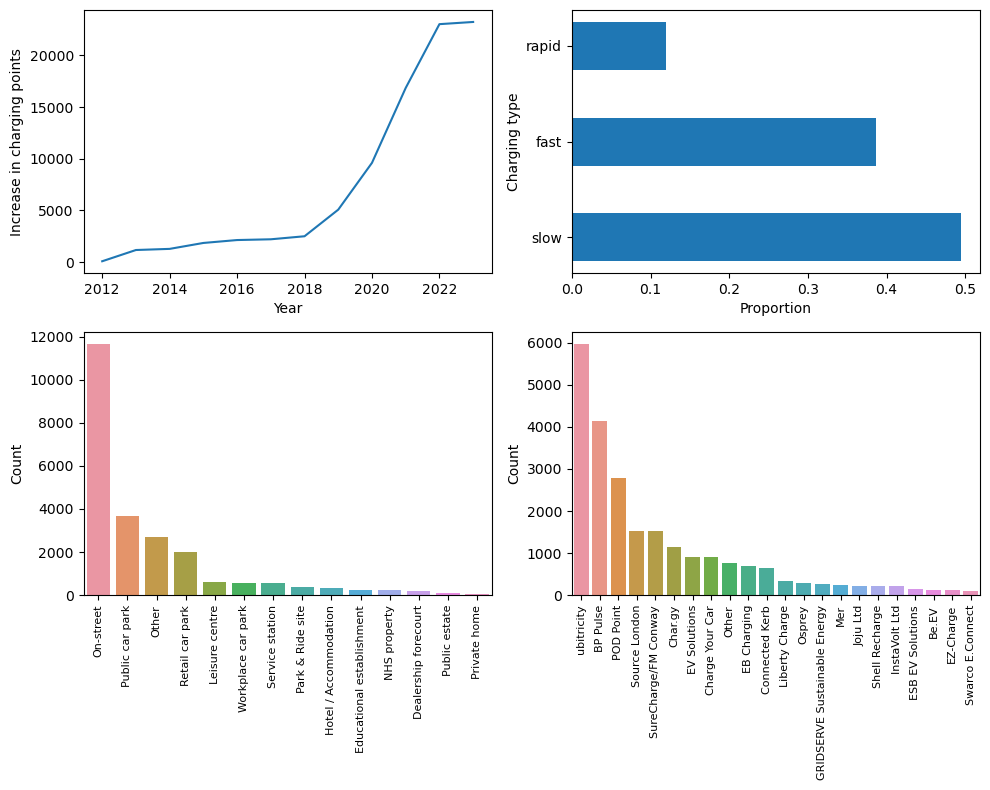

In [197]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (10,8))

num_years = charge.groupby('year').count()
ax[0,0].plot(num_years['chargeDeviceID'].cumsum())
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Increase in charging points')

ax[0,1].barh(charge['charge_speed1'].value_counts(normalize = True).index, 
         charge['charge_speed1'].value_counts(normalize = True).values, 
         height = 0.5)
ax[0,1].set_xlabel('Proportion')
ax[0,1].set_ylabel('Charging type')

ax[1,0].set_xticklabels(labels = charge['locationType'].value_counts().index, rotation = 90, fontsize = 8)
sns.barplot(x=charge['locationType'].value_counts().index, y = charge['locationType'].value_counts().values, 
            ax = ax[1,0])
ax[1,0].set_xticklabels(labels = charge['locationType'].value_counts().index, rotation = 90, fontsize = 8)
ax[1,0].set_ylabel('Count')
sns.barplot(x=charge['deviceControllerName'].value_counts().index, y = charge['deviceControllerName'].value_counts().values, 
            ax = ax[1,1])
ax[1,1].set_xticklabels(labels = charge['deviceControllerName'].value_counts().index, rotation = 90, fontsize = 8)
ax[1,1].set_ylabel('Count')
plt.tight_layout()
plt.show()

The cleaned dataset includes 23311 charging points in England. Of these around 50% are slow charging and around 50% are located on street.

11331 of these require payment and 8449 require a subscription. There has been a large increase in the placement of these charging points since 2012, with 12561 charging stations (>50%) created since 2020.

### 3.2 Charging points aggregated by outcode

In [1070]:
# create a heatmap of charging points per postal code
heatmap_df = outcodes[['latitude', 'longitude','charging_points']].copy()

hm = folium.Map(location=[52.9, -1.1],
               zoom_start=6)
HeatMap(heatmap_df, 
        min_opacity=0.4,
        blur = 18
               ).add_to(folium.FeatureGroup(name='Heat Map').add_to(hm))
folium.LayerControl().add_to(hm)

hm

In [199]:
# look at the descriptive analysis per number of charging points
outcodes['charging_points'].describe()

count    2147.000000
mean       10.839311
std        32.098720
min         0.000000
25%         1.000000
50%         4.000000
75%         9.000000
max       717.000000
Name: charging_points, dtype: float64

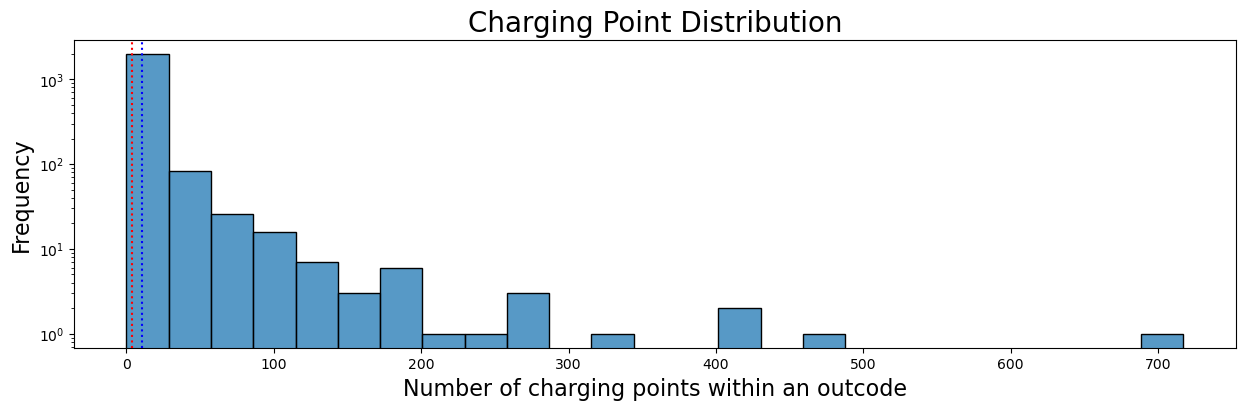

In [200]:
# plot a histogram showing the distribution of charging points 
fig, ax = plt.subplots(figsize=(15, 4))
sns.histplot(outcodes['charging_points'], ax=ax, bins=25)
ax.set_yscale('log')
ax.set_xlabel('Number of charging points within an outcode', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Charging Point Distribution', fontsize=20)
ax.axvline(x= outcodes['charging_points'].mean(), color='blue', linestyle='dotted')
ax.axvline(x= outcodes['charging_points'].median(), color='red', linestyle='dotted')
plt.show()

In [1316]:
# investigate the charging point that has 700
outcodes[outcodes['charging_points'] == 717]

outcode  latitude  longitude   district urban_code  urban  urban_index  \
1708     SW6  51.47675   -0.19986  London SW         A1    1.0          1.0   

                 authority_1 authority_2 authority_3  ...  \
1708  Hammersmith and Fulham        none        none  ...   

                             shortest_coords_out   dist_in   flow_in  \
1708  (51.495368804733225, -0.34433949709832484)  0.886074  0.129079   

      dist_out  flow_out    mean_price  median_price    parea_mean  \
1708  0.840556  0.410587  1.111230e+06      830000.0  11446.282131   

      parea_median  area_km2  
1708  10746.268657  5.248538  

[1 rows x 52 columns]

In [1317]:
# count how many outcodes have 0 charging points
outcodes[outcodes['charging_points'] == 0].shape

(480, 52)

In [2993]:
# count how many outcodes have more than 100 charging points
outcodes[outcodes['charging_points'] > 100].shape

(35, 49)

Initial investigation of charging points aggregated per location shows a very wide spread. 480 out of 2147 outcodes have no charging points. The mean value of ~11 charging points per outcode is clearly being skewed by a few very large values as seen by the median value of 4 charging points and the histogram above. Despite a max value of 717 charging points in one outcode, less than 2% of outcodes have more than 100 charging points.

Initial inspection of the heatmap above shows areas of intensity centred around major cities (London, Birmingham, Manchester, Newcastle etc.)

### 3.3 Traffic data

#### Locations of traffic sites & charging points aggregated by outcode

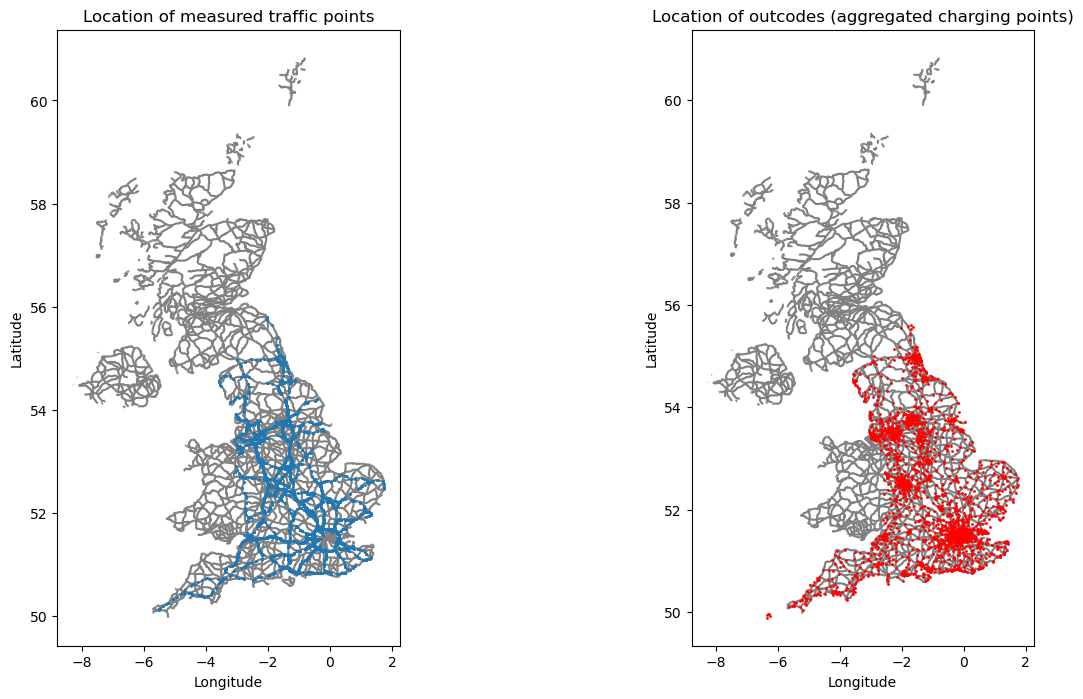

In [601]:
# Inspect locations of recorded traffic points vs locations of aggregated charging point data (outcodes)

# import shapefile of uk road system
roads_sh = gpd.read_file('./data/GBR_rds/GBR_roads.shp')
# create tuples of longitude and latitude and a geodataframe for traffic points 
geometry = [Point(xy) for xy in zip(traffic['longitude'], traffic['latitude'])]
geo_df = gpd.GeoDataFrame(traffic, crs = 'epsg:4326', geometry = geometry)
# create tuples of longitude and latitude and a geodataframe for outcodes
geometry_outcodes = [Point(xy) for xy in zip(outcodes['longitude'], outcodes['latitude'])]
geo_outcodes = gpd.GeoDataFrame(outcodes, crs = 'epsg:4326', geometry = geometry_outcodes)
# plot traffic points along the graph
fig,ax = plt.subplots(ncols = 2, figsize =(15,8))
roads_sh.plot(ax=ax[0], color = 'grey', zorder=1)
roads_sh.plot(ax=ax[1], color = 'grey', zorder=1)
geo_df.plot(ax =ax[0], zorder=2, markersize = 1)
ax[0].set_title('Location of measured traffic points')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
geo_outcodes.plot(ax =ax[1], zorder=3, markersize = 1,color ='r')
ax[1].set_title('Location of outcodes (aggregated charging points)')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude');

#### Average traffic flow densities around England

In [578]:
# look at where the busiest areas are
# create a heatmap of traffic flow around England
heatmap_df2 = traffic[['latitude', 'longitude','flow_cars']].copy()

hm_traf = folium.Map(location=[52.9, -1.1],
               zoom_start=6)
HeatMap(heatmap_df2, 
        min_opacity=0.4,
        blur = 18
               ).add_to(folium.FeatureGroup(name='Heat Map').add_to(hm_traf))
folium.LayerControl().add_to(hm_traf)

hm_traf

#### Determining the traffic flow around an outcode
In order to determine the traffic flow around each outcode, the shortest distance to a main road had to be combined with the average traffic flow at that road. The inital approach to this was to 

In [204]:
# check the distribution
outcodes[['dist_in', 'traffic_in','dist_out','traffic_out']].describe()

dist_in   traffic_in     dist_out  traffic_out
count  2147.000000  2147.000000  2147.000000  2147.000000
mean      9.280077   137.385998     9.744105   155.696496
std       7.871419   111.978011     8.131173   127.833293
min       0.035292     0.121007     0.096281     3.164332
25%       4.151523    63.192780     4.317351    66.245174
50%       7.024665   108.314614     7.477457   112.170851
75%      12.031924   164.580982    12.640607   208.694409
max      72.939031   787.637349    74.777312   808.024477

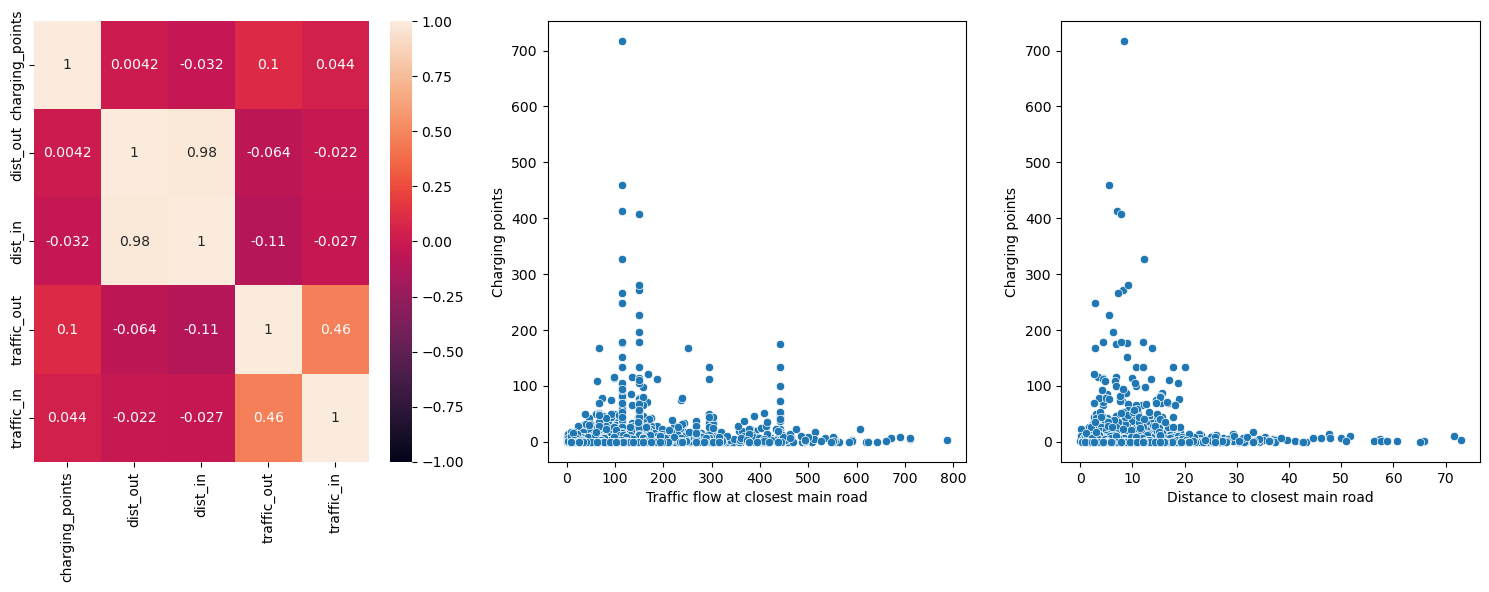

In [205]:
# Create plots showing the relationship between charging points and distances to and traffic flow at closest main road
fig, ax = plt.subplots(ncols = 3, figsize = (15,6))
sns.heatmap(data = outcodes[['charging_points', 'dist_out','dist_in', 'traffic_out', 'traffic_in']].corr(), annot = True, 
           vmin = -1, vmax = 1, ax = ax[0])
sns.scatterplot(x = outcodes['traffic_in'], y = outcodes['charging_points'], ax =ax[1])
ax[1].set_xlabel('Traffic flow at closest main road')
ax[1].set_ylabel('Charging points')
sns.scatterplot(x = outcodes['dist_in'], y = outcodes['charging_points'], ax =ax[2])
ax[2].set_xlabel('Distance to closest main road')
ax[2].set_ylabel('Charging points')
plt.tight_layout()
plt.show()

In [1082]:
# make a copy of the original df so we can come back to this data
df = outcodes.copy()
# calculate a metric for traffic flow
# scale the traffic distances 
scaler = MinMaxScaler()
cols = ['dist_in','traffic_in','dist_out','traffic_out']
# cols = ['dist_in','dist_out']

df[cols] = scaler.fit_transform(df[cols])

In [1084]:
# create a metric of the distance to main roads and the relative flow in and flow out
df['dist_in'] = 1-df['dist_in']
df['flow_in'] = df['dist_in'] * df['traffic_in']
df['dist_out'] = 1-df['dist_out']
df['flow_out'] = df['dist_out']*df['traffic_out']

In [1085]:
# sccales the traffic flows so that they are between zero and one
df[['flow_in','flow_out']] = scaler.fit_transform(df[['flow_in','flow_out']])

In [1087]:
df[['outcode','dist_in','traffic_in', 'flow_in']].head(3)

outcode   dist_in  traffic_in   flow_in
0     AL1  0.923685    0.119666  0.111558
1    AL10  0.967634    0.459468  0.448715
2     AL2  0.970759    0.119666  0.117243

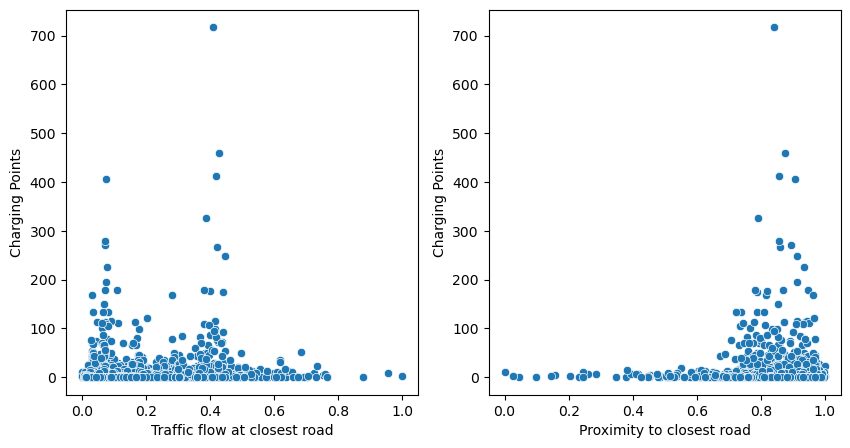

In [1076]:
# plot the traffic flows in and out against charging point locations
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))
sns.scatterplot(data = df, x = 'flow_out', y = 'charging_points', ax = ax[0])
ax[0].set_xlabel('Traffic flow at closest road')
ax[0].set_ylabel('Charging Points')
sns.scatterplot(data = df, x = 'dist_out', y = 'charging_points', ax = ax[1])
ax[1].set_xlabel('Proximity to closest road')
ax[1].set_ylabel('Charging Points')
plt.show()

In [1077]:
# look at the points that are have very high values
df[['outcode','charging_points','dist_in', 'traffic_in', 'road_in','dist_out','traffic_out','road_out',
  'flow_in','flow_out']][df['flow_in']>0.8]

outcode  charging_points   dist_in  traffic_in road_in  dist_out  \
3       AL3                5  0.890180    0.903477      M1  0.903878   
820    KT14                1  1.000000    0.839567     M25  0.995234   
822    KT16                3  0.990822    1.000000     M25  1.000000   
992     M27                9  0.959983    0.876662     M60  0.970445   

     traffic_out road_out   flow_in  flow_out  
3       0.811782       M1  0.811707  0.753217  
820     0.715249      M25  0.847344  0.730724  
822     0.974158      M25  1.000000  1.000000  
992     0.067581      M60  0.849377  0.067323

In [196]:
# look at charging points that have low values but high charging points
df[['outcode','charging_points','dist_in', 'traffic_in', 'road_in','dist_out','traffic_out','road_out',
  'flow_in','flow_out']][(df['flow_in']>0.2)&(df['charging_points']>100)]

outcode  charging_points   dist_in  traffic_in road_in  dist_out  \
375      CV2              112  0.940486  186.308345      M6  0.951168   
379      CV3              122  0.963249  168.283600     A45  0.966378   
535      E14              134  0.757263  440.716876     M11  0.738401   
538      E17              175  0.905571  440.716876     M11  0.787050   
1062     MK9              168  0.960439  250.920136      A5  0.961632   
1692    SW17              113  0.815125  295.638105      A3  0.778203   
1694    SW19              133  0.853428  295.638105      A3  0.787843   

      traffic_out road_out   flow_in  flow_out  
375     96.819362       M6  0.224524  0.116982  
379    168.486867      A45  0.207710  0.206830  
535     91.139410       A2  0.427646  0.085487  
538    440.716876      M11  0.511399  0.440619  
1062   233.740184       A5  0.308804  0.285524  
1692   170.964618      A23  0.308790  0.169005  
1694    38.900574       A3  0.323300  0.038931

In [197]:
# look at the distributions of traffic parameters
df[['dist_in','dist_out', 'traffic_in', 'traffic_out', 'flow_in', 'flow_out']].describe()

dist_in      dist_out   traffic_in  traffic_out      flow_in  \
count  2.147000e+03  2.147000e+03  2147.000000  2147.000000  2147.000000   
mean   8.731919e-01  8.708129e-01   137.385998   155.696496     0.154139   
std    1.079700e-01  1.088787e-01   111.978011   127.833293     0.128069   
min    1.110223e-16 -2.220446e-16     0.121007     3.164332     0.000000   
25%    8.354456e-01  8.320280e-01    63.192780    66.245174     0.068617   
50%    9.041287e-01  9.011640e-01   108.314614   112.170851     0.120436   
75%    9.435388e-01  9.434787e-01   164.580982   208.694409     0.186351   
max    1.000000e+00  1.000000e+00   787.637349   808.024477     1.000000   

          flow_out  
count  2147.000000  
mean      0.173363  
std       0.145101  
min       0.000000  
25%       0.070112  
50%       0.124481  
75%       0.237655  
max       1.000000

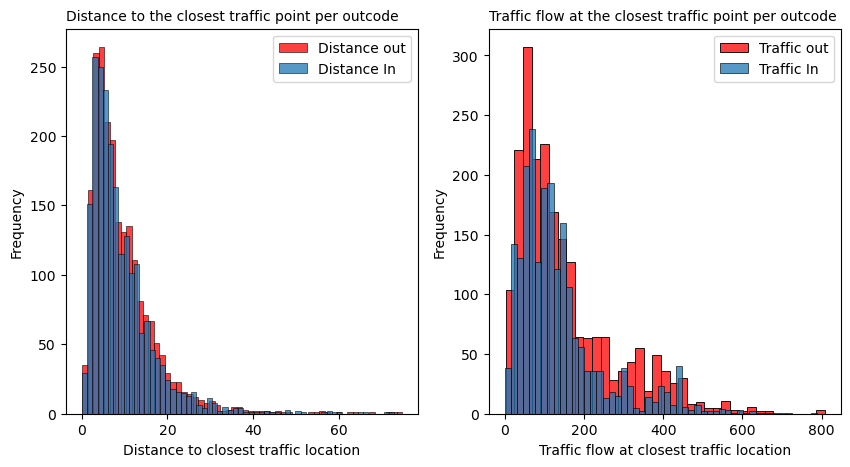

In [198]:
# Plot the distribution of the distances and traffic
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))
sns.histplot(data = outcodes, x ='dist_out', color = 'r', ax = ax[0])
sns.histplot(data = outcodes, x ='dist_in', palette = 'tab10', ax = ax[0])

ax[0].set_xlabel('Distance to closest traffic location')
ax[0].set_ylabel('Frequency')
ax[0].legend(labels = ['Distance out', 'Distance In'])
ax[0].set_title('Distance to the closest traffic point per outcode', loc = 'left', fontsize = 10)

sns.histplot(data = outcodes, x ='traffic_out', color = 'r', ax = ax[1])
sns.histplot(data = outcodes, x ='traffic_in', palette = 'tab10', ax = ax[1])

ax[1].set_xlabel('Traffic flow at closest traffic location')
ax[1].set_ylabel('Frequency')
ax[1].legend(labels = ['Traffic out', 'Traffic In'])
ax[1].set_title('Traffic flow at the closest traffic point per outcode', loc = 'left', fontsize = 10)

plt.show()

In [199]:
# group the traffic values into quartiles and assign a value based on this
# create a copy of the df
df2 = outcodes.copy()

In [200]:
# define a function to map the traffic values depending on which quartile they fall into
def traffic_vals(x):
    if x >= 0 and x < Q1:
        return 0.25
    elif x >= Q1 and x < Q2:  
        return 0.5
    elif x >= Q2 and x < Q3:  
        return 0.75
    elif x >= Q3 and x <= max_t:
        return 1

In [201]:
# define the quartiles for the traffic towards an outcode and map the values 
min_t = outcodes['traffic_in'].describe().loc['min']
Q1 = outcodes['traffic_in'].describe().loc['25%']
Q2 = outcodes['traffic_in'].describe().loc['50%']
Q3 = outcodes['traffic_in'].describe().loc['75%']
max_t = outcodes['traffic_in'].describe().loc['max']

df2['traffic_in'] = df2['traffic_in'].map(traffic_vals)

In [202]:
# define the quartiles for the traffic away from an outcode and map the values 
min_t = outcodes['traffic_out'].describe().loc['min']
Q1 = outcodes['traffic_out'].describe().loc['25%']
Q2 = outcodes['traffic_out'].describe().loc['50%']
Q3 = outcodes['traffic_out'].describe().loc['75%']
max_t = outcodes['traffic_out'].describe().loc['max']

df2['traffic_out'] = df2['traffic_out'].map(traffic_vals)

In [203]:
# scale the traffic distances and traffic flows for the dfs with & without outliers
scaler = MinMaxScaler()
# cols = ['dist_in','traffic_in','dist_out','traffic_out']
cols = ['dist_in','dist_out']

df2[cols] = scaler.fit_transform(df2[cols])

In [204]:
df2['dist_in'] = 1-df2['dist_in']
df2['flow_in'] = df2['dist_in'] * df2['traffic_in']
df2['dist_out'] = 1-df2['dist_out']
df2['flow_out'] = df2['dist_out']*df2['traffic_out']

In [205]:
# sccales the traffic flows so that they are between zero and one
df2[['flow_in','flow_out']] = scaler.fit_transform(df2[['flow_in','flow_out']])

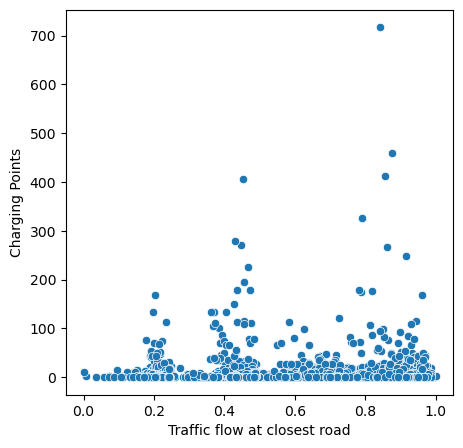

In [206]:
# plot the updated traffic metric
fig, ax = plt.subplots(figsize = (5,5))
sns.scatterplot(data = df2, x = 'flow_out', y ='charging_points')
ax.set_xlabel('Traffic flow at closest road')
ax.set_ylabel('Charging Points')
plt.show();

In [1091]:
# In both of the graphs above we can see there a few outliers at the upper end
# calculate what these outliers are user 3IQ + Q3
def upper_outliers(col):
    Q3 = outcodes[col].describe().loc['75%']
    Q1 = outcodes[col].describe().loc['25%']
    upper = Q3 + 3*(Q3-Q1)
    return upper

di_outlier = upper_outliers('dist_in')
do_outlier = upper_outliers('dist_out')
ti_outlier = upper_outliers('traffic_in')
to_outlier = upper_outliers('traffic_out')

print(di_outlier)
print(do_outlier)
print(ti_outlier)
print(to_outlier)

35.6731305
37.610372999999996
468.74558715688613
636.0421164211743


In [1122]:
# create a version without outliers
df3 = outcodes.copy()
df3 = df3[(df3['dist_in']<di_outlier)&(df3['dist_out']<do_outlier)]
df3 = df3[(df3['traffic_in']<ti_outlier)&(df3['traffic_out']<to_outlier)]

In [1123]:
# look at the dimensions of the new df
df3.shape

(2077, 50)

In [1124]:
# define the quartiles for the traffic towards an outcode and map the values 
min_t = df3['traffic_in'].describe().loc['min']
Q1 = df3['traffic_in'].describe().loc['25%']
Q2 = df3['traffic_in'].describe().loc['50%']
Q3 = df3['traffic_in'].describe().loc['75%']
max_t = df3['traffic_in'].describe().loc['max']

df3['traffic_in'] = df3['traffic_in'].map(traffic_vals)

# define the quartiles for the traffic away from an outcode and map the values 
min_t = df3['traffic_out'].describe().loc['min']
Q1 = df3['traffic_out'].describe().loc['25%']
Q2 = df3['traffic_out'].describe().loc['50%']
Q3 = df3['traffic_out'].describe().loc['75%']
max_t = df3['traffic_out'].describe().loc['max']

df3['traffic_out'] = df3['traffic_out'].map(traffic_vals)

In [1125]:
# scale the traffic distances and traffic flows for the dfs with & without outliers
scaler = MinMaxScaler()
# cols = ['dist_in','traffic_in','dist_out','traffic_out']
cols = ['dist_in','dist_out']

df3[cols] = scaler.fit_transform(df3[cols])

In [1126]:
# calculate a traffic metric for each
df3['dist_in'] = 1-df3['dist_in']
df3['flow_in'] = df3['dist_in'] * df2['traffic_in']
df3['dist_out'] = 1-df3['dist_out']
df3['flow_out'] = df3['dist_out']*df3['traffic_out']

In [1127]:
# scales the traffic flows so that they are between zero and one
df3[['flow_in','flow_out']] = scaler.fit_transform(df3[['flow_in','flow_out']])

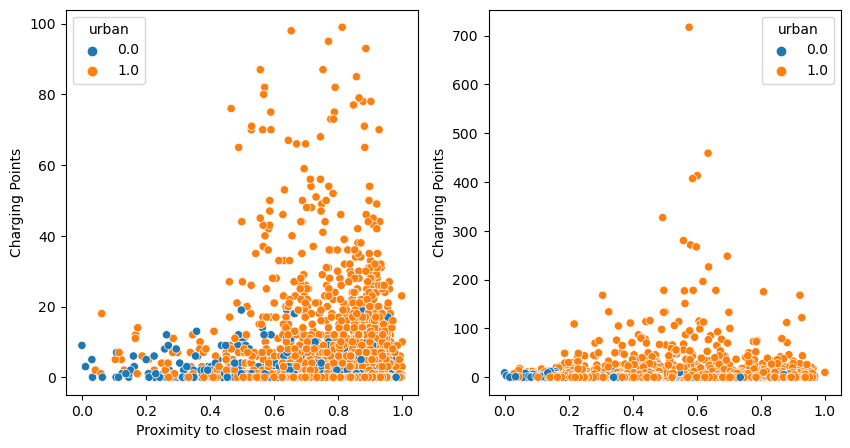

In [1128]:
# plot the inverse of the distance against charging points
fig, ax = plt.subplots(ncols = 2,figsize = (10,5))

sns.scatterplot(data = df3[df3['charging_points']<100], x = 'dist_in', y = 'charging_points', 
                hue = 'urban', palette = 'tab10', ax = ax[0])
ax[0].set_xlabel('Proximity to closest main road')
# ax[0].set_xlim(0.3,1)
ax[0].set_ylabel('Charging Points')

sns.scatterplot(data= df3, x = 'flow_in', y = 'charging_points', 
                hue = 'urban', 
                palette = 'tab10', ax = ax[1])
ax[1].set_xlabel('Traffic flow at closest road')
ax[1].set_ylabel('Charging Points');

In [215]:
# look at the proportion of all charging points and their location
all_locs = pd.DataFrame(charge['locationType'].value_counts())
all_locs['propotion'] = all_locs['locationType']/all_locs['locationType'].sum()
all_locs

locationType  propotion
On-street                         11639   0.499292
Public car park                    3698   0.158638
Other                              2682   0.115053
Retail car park                    1995   0.085582
Leisure centre                      603   0.025868
Workplace car park                  583   0.025010
Service station                     561   0.024066
Park & Ride site                    388   0.016645
Hotel / Accommodation               323   0.013856
Educational establishment           245   0.010510
NHS property                        221   0.009481
Dealership forecourt                206   0.008837
Public estate                       108   0.004633
Private home                         59   0.002531

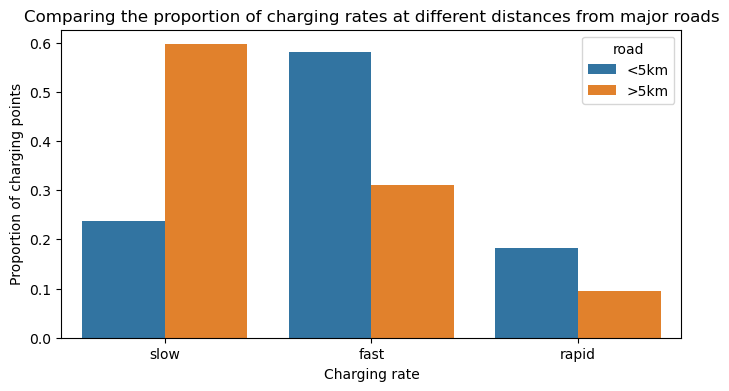

In [225]:
# proximity to major roads increases the proportion of fast and rapid chargers (e.g. motorway services)
fig, ax = plt.subplots(figsize = (8,4))

near_roads = outcodes[outcodes['dist_in']<5]
near_r = (near_roads['rapid']*near_roads['charging_points']).round(0).sum()/near_roads['charging_points'].sum()
near_f = (near_roads['fast']*near_roads['charging_points']).round(0).sum()/near_roads['charging_points'].sum()
near_s = (near_roads['slow']*near_roads['charging_points']).round(0).sum()/near_roads['charging_points'].sum()

far_roads = outcodes[outcodes['dist_in']>5]
far_r = (far_roads['rapid']*far_roads['charging_points']).round(0).sum()/far_roads['charging_points'].sum()
far_f = (far_roads['fast']*far_roads['charging_points']).round(0).sum()/far_roads['charging_points'].sum()
far_s = (far_roads['slow']*far_roads['charging_points']).round(0).sum()/far_roads['charging_points'].sum()

c_rates = pd.DataFrame({'charging' : ['slow','fast','rapid','slow','fast','rapid'],
             'proportion' : [near_s,near_f, near_r, far_s, far_f, far_r], 
             'road' : ['<5km','<5km','<5km','>5km','>5km','>5km']})

sns.barplot(data = c_rates, x = 'charging', y = 'proportion', hue = 'road', ax = ax)
ax.set_xlabel('Charging rate')
ax.set_ylabel('Proportion of charging points')
ax.set_title('Comparing the proportion of charging rates at different distances from major roads')
plt.show()

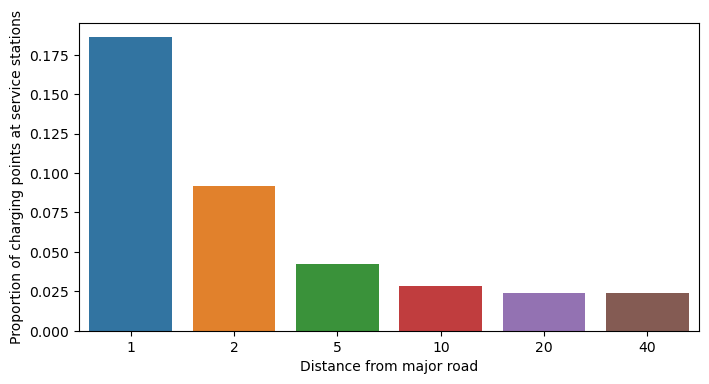

In [1105]:
service_s = []
for distance in [1,2,5,10,20,40]:
    dists = outcodes[outcodes['dist_in']<distance]
    dists['Service station'] = dists['Service station']*dists['charging_points']
    ss = dists['Service station'].sum()
    cps = dists['charging_points'].sum()
    service_s.append(ss/cps)

sstations = pd.DataFrame({'dist': [1,2,5,10,20,40],
            'service stations': service_s})

fig, ax = plt.subplots(figsize = (8,4))
sns.barplot(x = sstations['dist'], y = sstations['service stations'], ax=ax)
ax.set_xlabel('Distance from major road')
ax.set_ylabel('Proportion of charging points at service stations')
plt.show()

In [961]:
# create a heatmap of charging points per postal code
heat_traf = traffic[['latitude']].copy()
heat_traf['longitude'] = traffic['longitude'].copy()
heat_traf['flow'] = traffic['flow_cars'].copy()

hm = folium.Map(location=[51.5074, 0.1078],
                    zoom_start = 10)
HeatMap(heat_traf, 
        min_opacity=0.4,
        blur = 18
               ).add_to(folium.FeatureGroup(name='Heat Map').add_to(hm))
folium.LayerControl().add_to(hm)

hm

From the above work we can see that there is very little relationship between the building of EV stations and proximity to busy, main roads. This is further highlighted by the fact that only 2% of all charging points are located at service stations, suggesting the initial strategy in their placement was not taking into consideration long distance traffic. The 2021 government issued report on building a comprehensive EV network suggests that the number of EV points at motorway stations will need to increase approximately 4 fold to meet demand.<sup>1</sup>

After the initial calculation of comparing outcodes with high traffic flow and low traffic flow, it was clear that the traffic value was having a much higher impact than the distance value. This meant that although some areas area very close to roads which are still relatively very busy, their metric of traffic flow is very low. It was attempted to scaled this by grouping the traffic fows. However, inevitably further work could be done on how to calculate this metric of traffic flow.

A potential flaw in the evaluation method here is also highlighted in the heatmap above. The collected traffic data is only for major roads and certain A roads are not included. For example the traffic flow around the centre of London would be lower than around the outskirts where the M25 is. Therefore this is making the assumption that charging points should be located in areas of longer distance traffic not in cities, where there is significant, local traffic. A further limiation arose from the number of API calls that could be made, meaning only one traffic point could be mapped per location. 

Having determined that traffic is not a key factor in the installation of charging points, this leaves the question, what factor were influential in how they were placed?

<sup>1</sup>https://www.gov.uk/government/publications/electric-vehicle-charging-market-study-final-report/final-report

### 3.4 Other variables

After the inital EDA, other variables were investigated to see if there were any correlations to charging points.

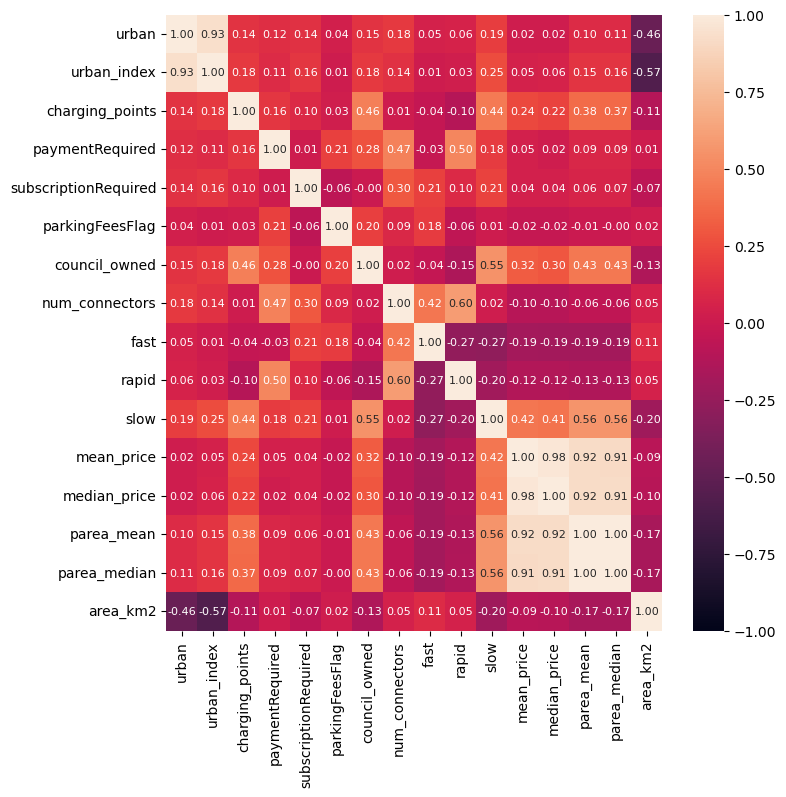

In [3025]:
# plot a heatmap of the other variables
cols = ['urban',
       'urban_index','charging_points',
       'paymentRequired', 'subscriptionRequired', 'parkingFeesFlag',
       'council_owned', 'num_connectors','fast', 'rapid', 'slow','mean_price', 'median_price', 'parea_mean',
       'parea_median','area_km2']

fig,ax = plt.subplots(figsize = (8,8))
# mask = np.triu(np.ones_like(outcodes.corr()))
sns.heatmap(outcodes[cols].corr(), annot = True, vmax = 1, vmin = -1, annot_kws={'size': 8}, fmt = '.2f', ax = ax)
plt.show()

Compare the availability of charging points in urban vs rural areas. Outcodes all have a code with the following meanings as assigned by the ONS in the original dataset:

**A1** Urban major conurbation  
**B1** Urban minor conurbation  
**C1** Urban city and town  
**C2** Urban city and town (in a sparse setting)  
**D1** Rural town and fringe  
**D2** Rural town and fringe (in a sparse setting)  
**E1** Rural village  
**E2** Rural village (in a sparse setting)  
**F1** Rural hamlet/isolated dwellings  
**F2** Rural hamlet/isolated dwellings (in a sparse setting)

In [2799]:
# compare rural vs urban areas
urban_nums = outcodes.groupby('urban_code')[['charging_points']].sum()
urban_nums['proportion'] = urban_nums['charging_points']/urban_nums['charging_points'].sum()
urban_nums

charging_points  proportion
urban_code                             
A1                    14152    0.608113
B1                      522    0.022430
C1                     7378    0.317033
C2                       17    0.000730
D1                      696    0.029907
D2                      115    0.004942
E1                      255    0.010957
E2                       17    0.000730
F1                       84    0.003609
F2                       36    0.001547

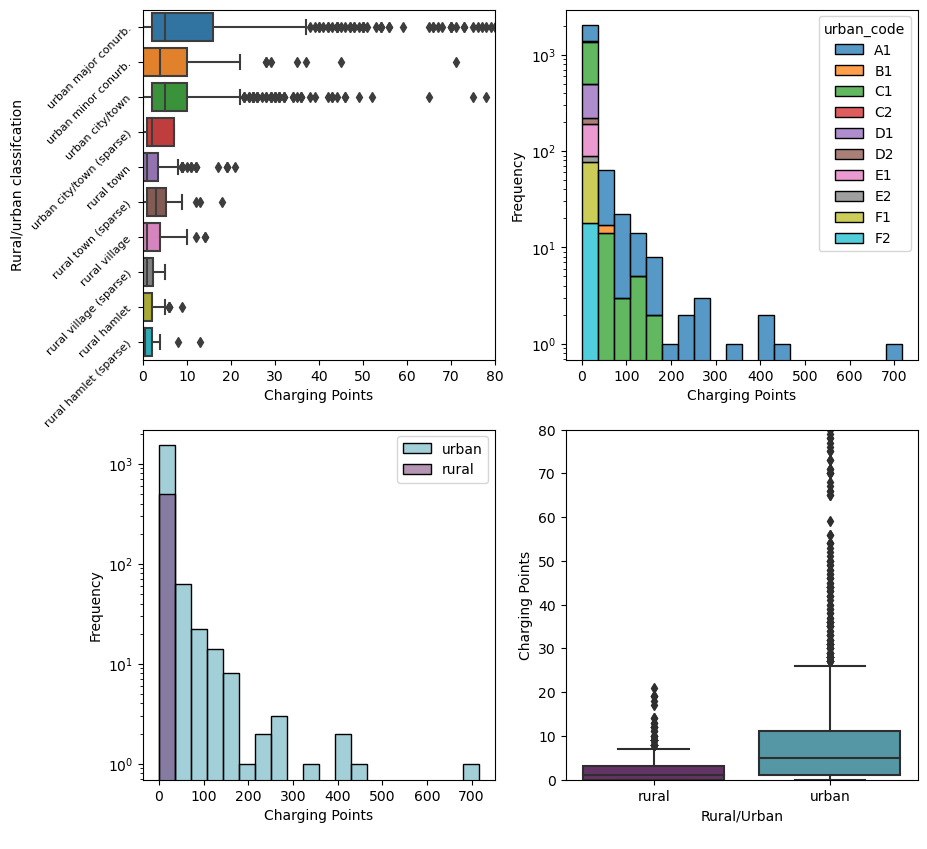

In [1748]:
# plot the variation in charging points with rural vs urban areas
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))

sns.boxplot(data = outcodes.sort_values(by = 'urban_code'), 
            y = 'urban_code', x = 'charging_points', ax = ax[0,0])
ax[0,0].set_xlim(0,80)
ax[0,0].set_yticklabels(labels = ['urban major conurb.','urban minor conurb.', 'urban city/town',
                                  'urban city/town (sparse)','rural town','rural town (sparse)', 
                                  'rural village','rural village (sparse)','rural hamlet', 'rural hamlet (sparse)'], 
                        fontsize = 8, rotation = 45)

ax[0,0].set_xlabel('Charging Points', fontsize = 10)
ax[0,0].set_ylabel('Rural/urban classifcation', fontsize = 10)

sns.histplot(data = outcodes.sort_values(by = 'urban_code'), x = 'charging_points', 
             bins =20, hue = 'urban_code', multiple = 'stack', legend = True,
             ax = ax[0,1])
ax[0,1].set_yscale('log')
# ax[0,1].legend(['urban major conurb.','urban minor conurb.', 
#                         'urban city/town','urban city/town (sparse setting)',
#                         'rural town','rural town (sparse setting)', 
#                         'rural village','rural village (sparse setting)', 
#                          'rural hamlet', 'rural hamlet (sparse setting)'])
ax[0,1].set_xlabel('Charging Points\n', fontsize = 10)
ax[0,1].set_ylabel('Frequency', fontsize = 10)


sns.histplot(data = outcodes.sort_values(by = 'urban'), x = 'charging_points', 
             bins =20, hue = 'urban', multiple = 'layer', palette = ['#6c2b6d','#47a0b3'],
             ax = ax[1,0])
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('Charging Points\n', fontsize = 10)
ax[1,0].set_ylabel('Frequency', fontsize = 10)
ax[1,0].legend(labels = ['urban','rural'])

sns.boxplot(data = outcodes.sort_values(by = 'urban'), 
            x = 'urban', y = 'charging_points', palette = ['#6c2b6d','#47a0b3'], ax = ax[1,1])
ax[1,1].set_xticklabels(labels = ['rural', 'urban'])
ax[1,1].set_ylim(0,80)
ax[1,1].set_xlabel('Rural/Urban\n', fontsize = 10)
ax[1,1].set_ylabel('Charging Points', fontsize = 10)

plt.show()

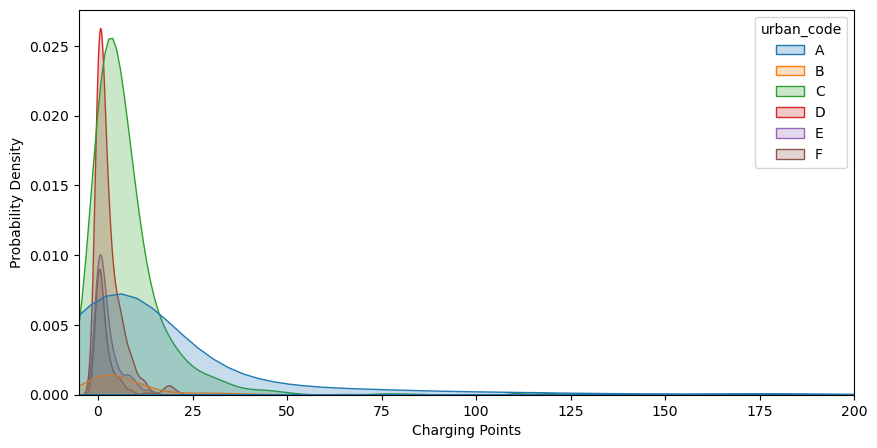

In [231]:
# map the codes to single values - it is too granular but would still be interesting to see if we see more info than rural/urban
letter = re.compile(r'[A-Z]')
def get_code(x):
    try:
        return re.search(letter,x).group()
    except:
        return np.nan
    
outcodes['urban_code'] = outcodes['urban_code'].map(get_code)  

# plot the result
fig, ax = plt.subplots(figsize = (10,5))
sns.kdeplot(data = outcodes.sort_values(by = 'urban_code'),
            x = 'charging_points', hue = 'urban_code', fill = True, ax = ax)
ax.set_xlabel('Charging Points')
ax.set_ylabel('Probability Density')
ax.set_xlim(-5,200)
plt.show()

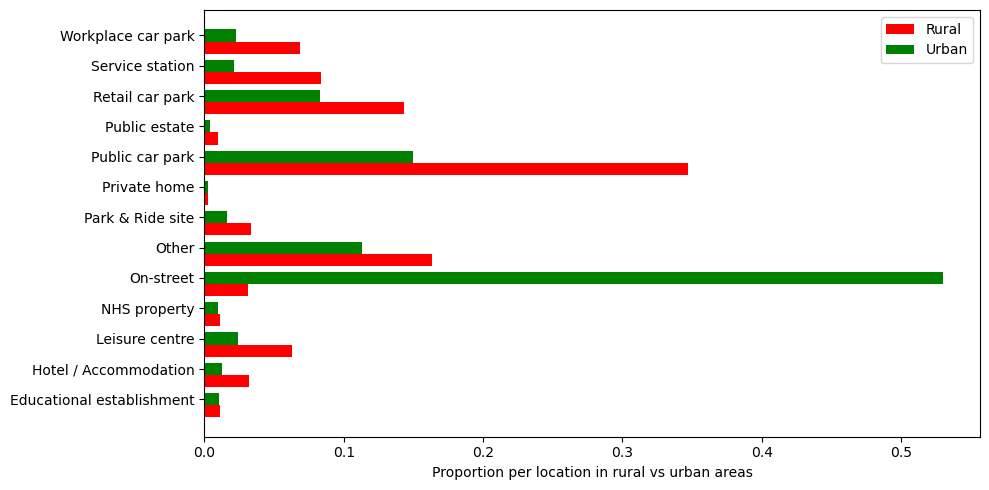

In [1130]:
# look at the most common locations for urban vs rural
charge_loc = outcodes.copy()
locs = ['Educational establishment', 'Hotel / Accommodation', 'Leisure centre',
       'NHS property', 'On-street', 'Other', 'Park & Ride site',
       'Private home', 'Public car park', 'Public estate', 'Retail car park','Service station', 'Workplace car park']
for location in locs:
    charge_loc[location] = (charge_loc[location]*charge_loc['charging_points']).round(0)
    

fig, ax = plt.subplots(figsize = (10,5))

urban_locs = charge_loc.groupby('urban')[locs].sum().T
urban_locs = urban_locs/urban_locs.sum()
ind = np.arange(len(urban_locs))
width = 0.4

ax.barh(ind, urban_locs[0.0], width, color='red', label='Rural')
ax.barh(ind + width, urban_locs[1.0], width, color='green', label='Urban')

ax.set(yticks=ind + width, yticklabels=urban_locs.index)
ax.set_xlabel('Proportion per location in rural vs urban areas')
ax.legend()

plt.tight_layout()
plt.show()

In [2865]:
# Number of outcodes in rural locations
outcodes.groupby('urban')['outcode'].count()

urban
0.0     495
1.0    1645
Name: outcode, dtype: int64

#### Demand in rural vs urban areas
Despite 30% of outcodes falling in rural areas, and the fact these outcodes make up >50% of the geographical area in England, only ~ 5% of charging points in England are located in these areas.

This follows literature which describes a risk of 'charging point deserts' in rural areas or at tourist spots.<sup>1</sup> This is explained due to the relatively high connection costs and lower demand. However, it should also be considered that some of these locations are also in proximity to relatively busy roads. It would additionally be interesting to evaluate the change in demand (through change in population sizes) during summer/ holiday periods. 

It would be useful to investigate population data, however, population data per postal codes was last released in 2011. Therefore this would not be an accurate representation of the current population.

From the work above we can see that there is a huge discrepancy between the number of charging points in urban areas. How can this discrepancy be explained?

<sup>1</sup>https://www.gov.uk/government/publications/electric-vehicle-charging-market-study-final-report/final-report

#### Investigating what separates urban areas
Some urban areas have very high numbers of charging points while some have none. The next stage was focused on whether we could find a differentiating feature between these locations. 

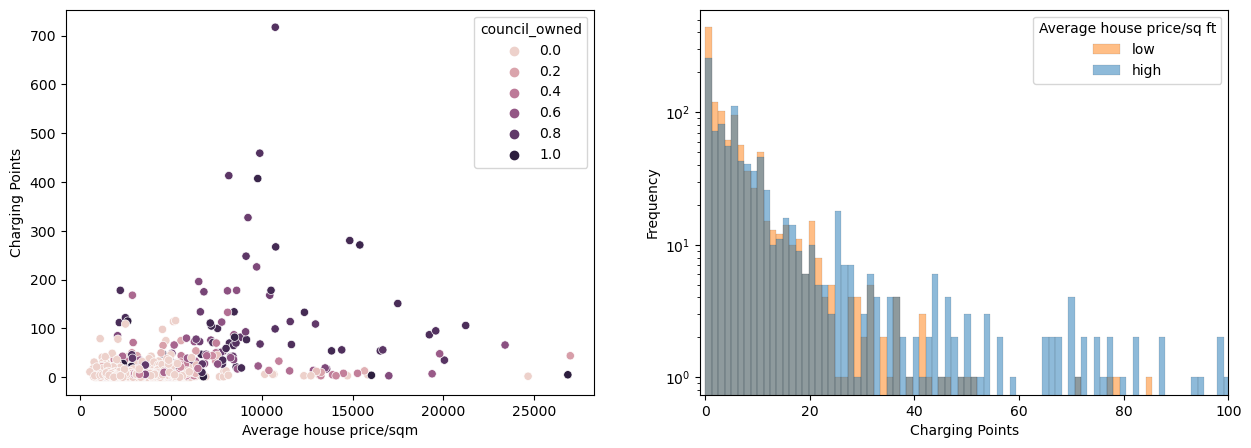

In [238]:
# Look at the proportion charging points in urban areas that are council funded
# Separate charging points in urban areas by areas that have house price per square foot above the average
fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
sns.scatterplot(data = outcodes[outcodes['urban'] == 1], x = 'parea_median', y ='charging_points', 
                hue = 'council_owned', ax =ax[0])
ax[0].set_xlabel('Average house price/sqm')
ax[0].set_ylabel('Charging Points')

sns.histplot(data = outcodes[outcodes['urban'] == 1], x = outcodes['charging_points'], 
             hue = outcodes['parea_median'].map(lambda x: 'high' if x > outcodes['parea_median'].median() else 'low'),
            ax = ax[1])
ax[1].set_xlim(-1,100)
ax[1].legend(title='Average house price/sq ft', labels = ['low', 'high'])
ax[1].set_yscale('log')
ax[1].set_xlabel('Charging Points')
ax[1].set_ylabel('Frequency')

plt.show()

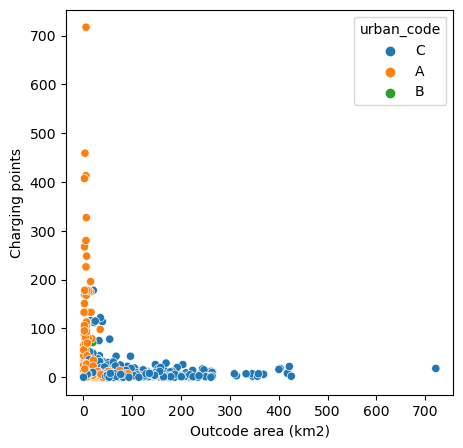

In [3034]:
# comparing number of charging points to area of an outcode shows that this is another measure of urban 
# check how the outcodes are defined
fig, ax = plt.subplots(figsize = (5,5))
sns.scatterplot(data = outcodes[outcodes['urban'] == 1], x = 'area_km2', y ='charging_points',
               hue ='urban_code', ax =ax)
ax.set_xlabel('Outcode area (km2)')
ax.set_ylabel('Charging points')
plt.show()

#### Impact of location
Do different geographical districts and regions have marked differences in the number of charging points?

In [454]:
# Check the districts which are coming up with the highest numbers
outcodes.groupby('district')[['charging_points']].sum().sort_values(by = 'charging_points', ascending = False)[:15]

charging_points
district                            
London W                        2938
London SW                       2864
London NW                       1130
London SE                       1106
London E                        1035
Coventry                         828
Newcastle upon Tyne              661
Twickenham                       633
London N                         622
Milton Keynes                    457
Nottingham                       431
Brighton                         424
Manchester                       348
Bristol                          299
Oxford                           286

In [2869]:
# look at the districts within urban areas
outcodes[outcodes['urban']==1].groupby('urban_code')['district'].value_counts()

urban_code  district           
A1          Birmingham             62
            Liverpool              44
            Manchester             44
            Newcastle upon Tyne    38
            London SE              29
                                   ..
C2          Carlisle                1
            Exeter                  1
            Lincoln                 1
            Taunton                 1
            York                    1
Name: district, Length: 126, dtype: int64

In [1669]:
# look at the 10 outcodes with the highest number of charging points
top_10 = outcodes.sort_values(by = 'charging_points', ascending = False)[:10]
top_10

outcode  latitude  longitude   district urban_code  urban  urban_index  \
1708     SW6  51.47675   -0.19986  London SW         A1    1.0          1.0   
1908      W6  51.49246   -0.22805   London W         A1    1.0          1.0   
1888     W12  51.50777   -0.22890   London W         A1    1.0          1.0   
1911      W9  51.52607   -0.19070   London W         A1    1.0          1.0   
1686    SW11  51.46630   -0.16427  London SW         A1    1.0          1.0   
1904      W2  51.51508   -0.17816   London W         A1    1.0          1.0   
1237     NW8  51.53117   -0.17175  London NW         A1    1.0          1.0   
1890     W14  51.49488   -0.20923   London W         A1    1.0          1.0   
1906      W4  51.49118   -0.26268   London W         A1    1.0          1.0   
1235     NW6  51.54142   -0.19442  London NW         A1    1.0          1.0   

                 authority_1             authority_2             authority_3  \
1708  Hammersmith and Fulham                    none                    none   
1908  Hammersmith and Fulham                Hounslow                    none   
1888  Hammersmith and Fulham                  Ealing                    none   
1911             Westminster  Kensington and Chelsea                  Camden   
1686              Wandsworth                    none                    none   
1904             Westminster                  Ealing  Kensington and Chelsea   
1237             Westminster                  Camden                   Brent   
1890  Hammersmith and Fulham  Kensington and Chelsea                    none   
1906                Hounslow                  Ealing  Hammersmith and Fulham   
1235                  Camden                   Brent             Westminster   

      ...  traffic_in                                  coords_in   dist_out  \
1708  ...  113.789597  (51.49149656873351, -0.29499908467816477)  12003.746   
1908  ...  113.789597  (51.49149656873351, -0.29499908467816477)   9331.955   
1888  ...  113.789597  (51.49149656873351, -0.29499908467816477)  10763.423   
1911  ...  149.391697  (51.57548594349572, -0.23486805421727724)   7104.703   
1686  ...  113.789597  (51.49149656873351, -0.29499908467816477)  15731.334   
1904  ...  149.391697  (51.57548594349572, -0.23486805421727724)  10747.198   
1237  ...  149.391697  (51.57548594349572, -0.23486805421727724)   7987.760   
1890  ...  113.789597  (51.49149656873351, -0.29499908467816477)  10483.966   
1906  ...  113.789597  (51.49149656873351, -0.29499908467816477)   6500.391   
1235  ...  149.391697  (51.57548594349572, -0.23486805421727724)   5082.920   

                                      coords_out  traffic_out    mean_price  \
1708  (51.495368804733225, -0.34433949709832484)   386.154945  1.111230e+06   
1908  (51.495368804733225, -0.34433949709832484)   386.154945  9.347500e+05   
1888  (51.495368804733225, -0.34433949709832484)   386.154945  8.517932e+05   
1911   (51.57481265488363, -0.23434574613470754)    67.701621  8.752034e+05   
1686  (51.495368804733225, -0.34433949709832484)   386.154945  9.211176e+05   
1904   (51.57481265488363, -0.23434574613470754)    67.701621  1.339722e+06   
1237   (51.57481265488363, -0.23434574613470754)    67.701621  1.615545e+06   
1890  (51.495368804733225, -0.34433949709832484)   386.154945  1.122657e+06   
1906  (51.495368804733225, -0.34433949709832484)   386.154945  9.613985e+05   
1235   (51.57481265488363, -0.23434574613470754)    67.701621  8.527475e+05   

      median_price    parea_mean  parea_median  area_km2  
1708      830000.0  11446.282131  10746.268657  5.248538  
1908      765000.0  10239.589164   9894.736842  3.064175  
1888      735000.0   8582.322883   8189.655172  4.979529  
1911      645000.0  11286.903601   9782.608696  1.922561  
1686      765000.0   9643.827069   9245.683505  5.789028  
1904      860000.0  15781.997436  14849.206349  5.168603  
1237      840000.0  17156.148139  15403.289847  2.690902  
1890      705000.0  11940.597102  10770.61

In [1112]:
# the top ten outcodes are all in london
# sum the charging points across districts
sum_district = outcodes.groupby('district', as_index = False)[['charging_points']].sum()
top_sum = sum_district.sort_values(by = 'charging_points', ascending = False)[:15]
# save london districts as a variable
london = ['London E',
 'London EC',
 'London N',
 'London NW',
 'London SE',
 'London SW',
 'London W',
 'London WC']
# find the number of charging points that are in London and what proportion that is of the total in England
num_london = sum_district['charging_points'][sum_district['district'].isin(london)].sum()
prop_london = num_london/outcodes['charging_points'].sum()
print('Number of English charging points in London: ', num_london)
print('\nProportion of English charging points in London: ', prop_london)
print('\nTop 5 districts with the highest number of charging points:')      
top_sum[:5]

Number of English charging points in London:  9887

Proportion of English charging points in London:  0.42484530766586454

Top 5 districts with the highest number of charging points:


district  charging_points
50   London W             2938
49  London SW             2864
47  London NW             1130
48  London SE             1106
44   London E             1035

In [1113]:
# Find the average number of charging points per district
avg_district = outcodes.groupby('district', as_index = False)[['charging_points']].mean()
top_districts = avg_district.sort_values(by = 'charging_points', ascending = False)[:15]
bottom_districts = avg_district.sort_values(by = 'charging_points', ascending = True)[:15]

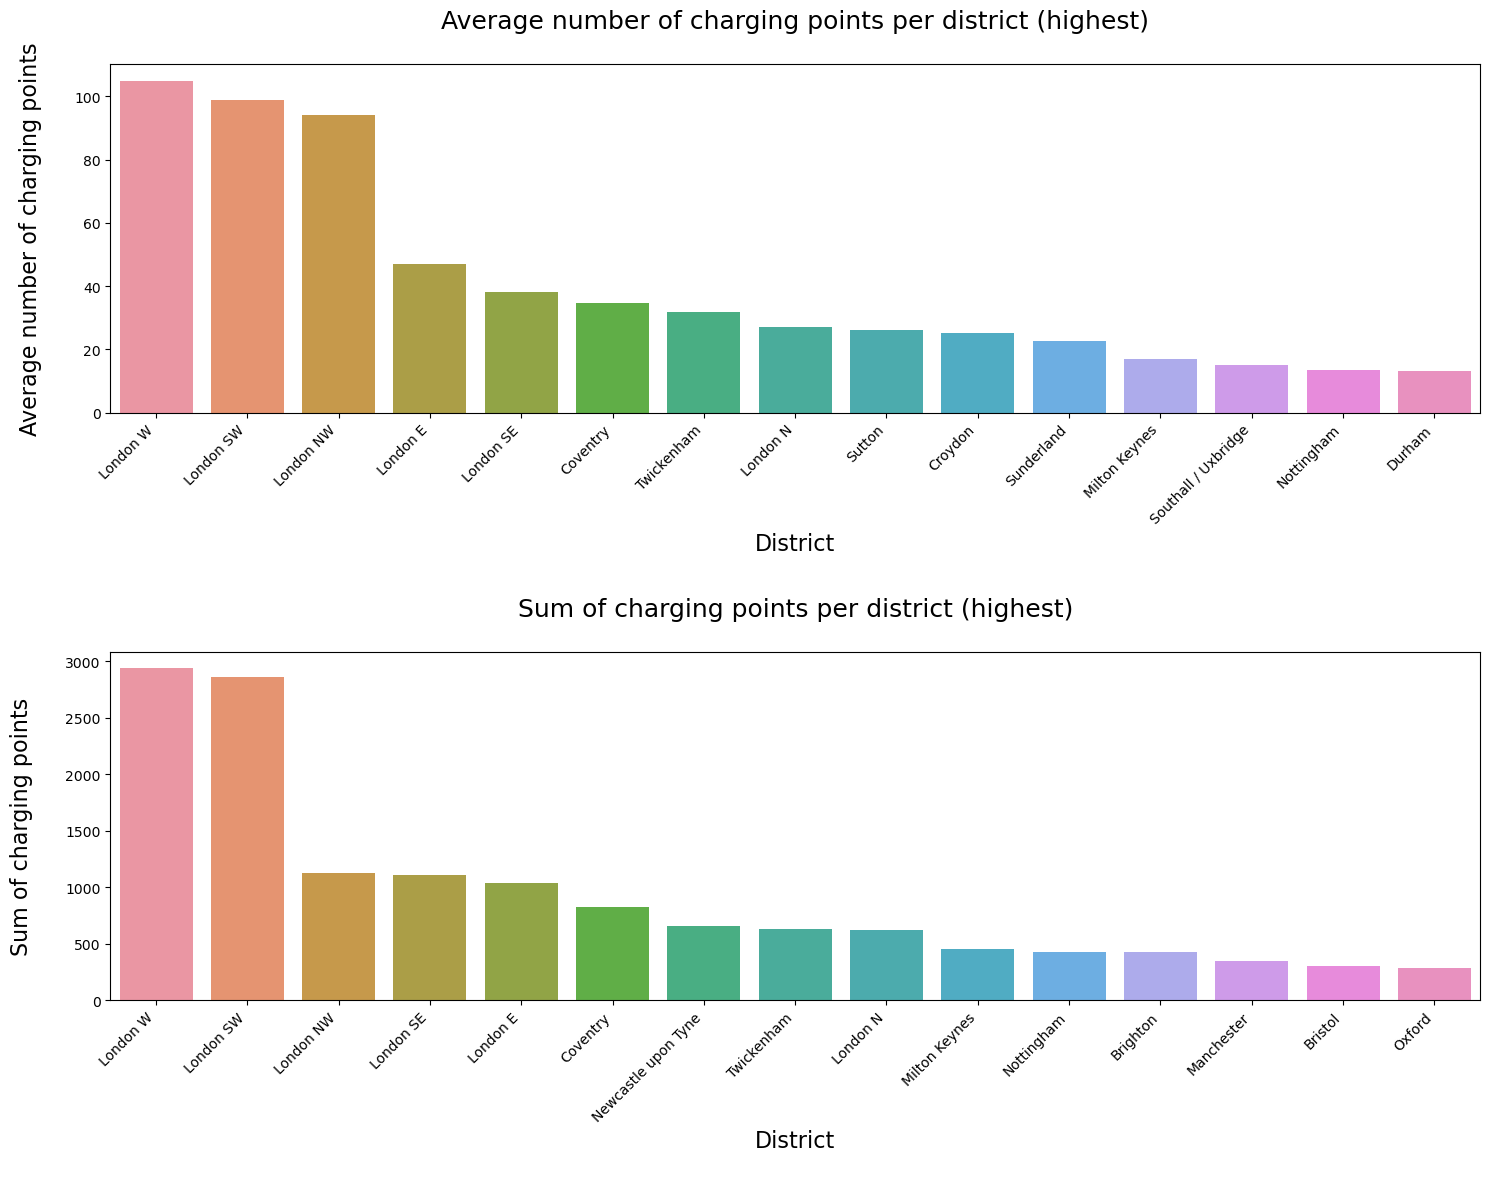

In [1114]:
# Plot the districts with the highest number of charging points
fig,ax = plt.subplots(nrows = 2, figsize = (15,12))

sns.barplot(data = top_districts, x= 'district', y ='charging_points', ax = ax[0])
ax[0].set_xticklabels(labels = top_districts['district'].values, rotation = 45, horizontalalignment='right')
ax[0].set_xlabel('District\n', fontsize = 16)
ax[0].set_ylabel('Average number of charging points\n', fontsize = 16)
ax[0].set_title('Average number of charging points per district (highest)\n', fontsize = 18)

sns.barplot(data = top_sum, x= 'district', y ='charging_points', ax = ax[1])
ax[1].set_xticklabels(labels = top_sum['district'].values, rotation = 45, horizontalalignment='right')
ax[1].set_xlabel('District\n', fontsize = 16)
ax[1].set_ylabel('Sum of charging points\n', fontsize = 16)
ax[1].set_title('Sum of charging points per district (highest)\n', fontsize = 18)

plt.tight_layout()
plt.savefig("./images/districts.png",bbox_inches='tight')

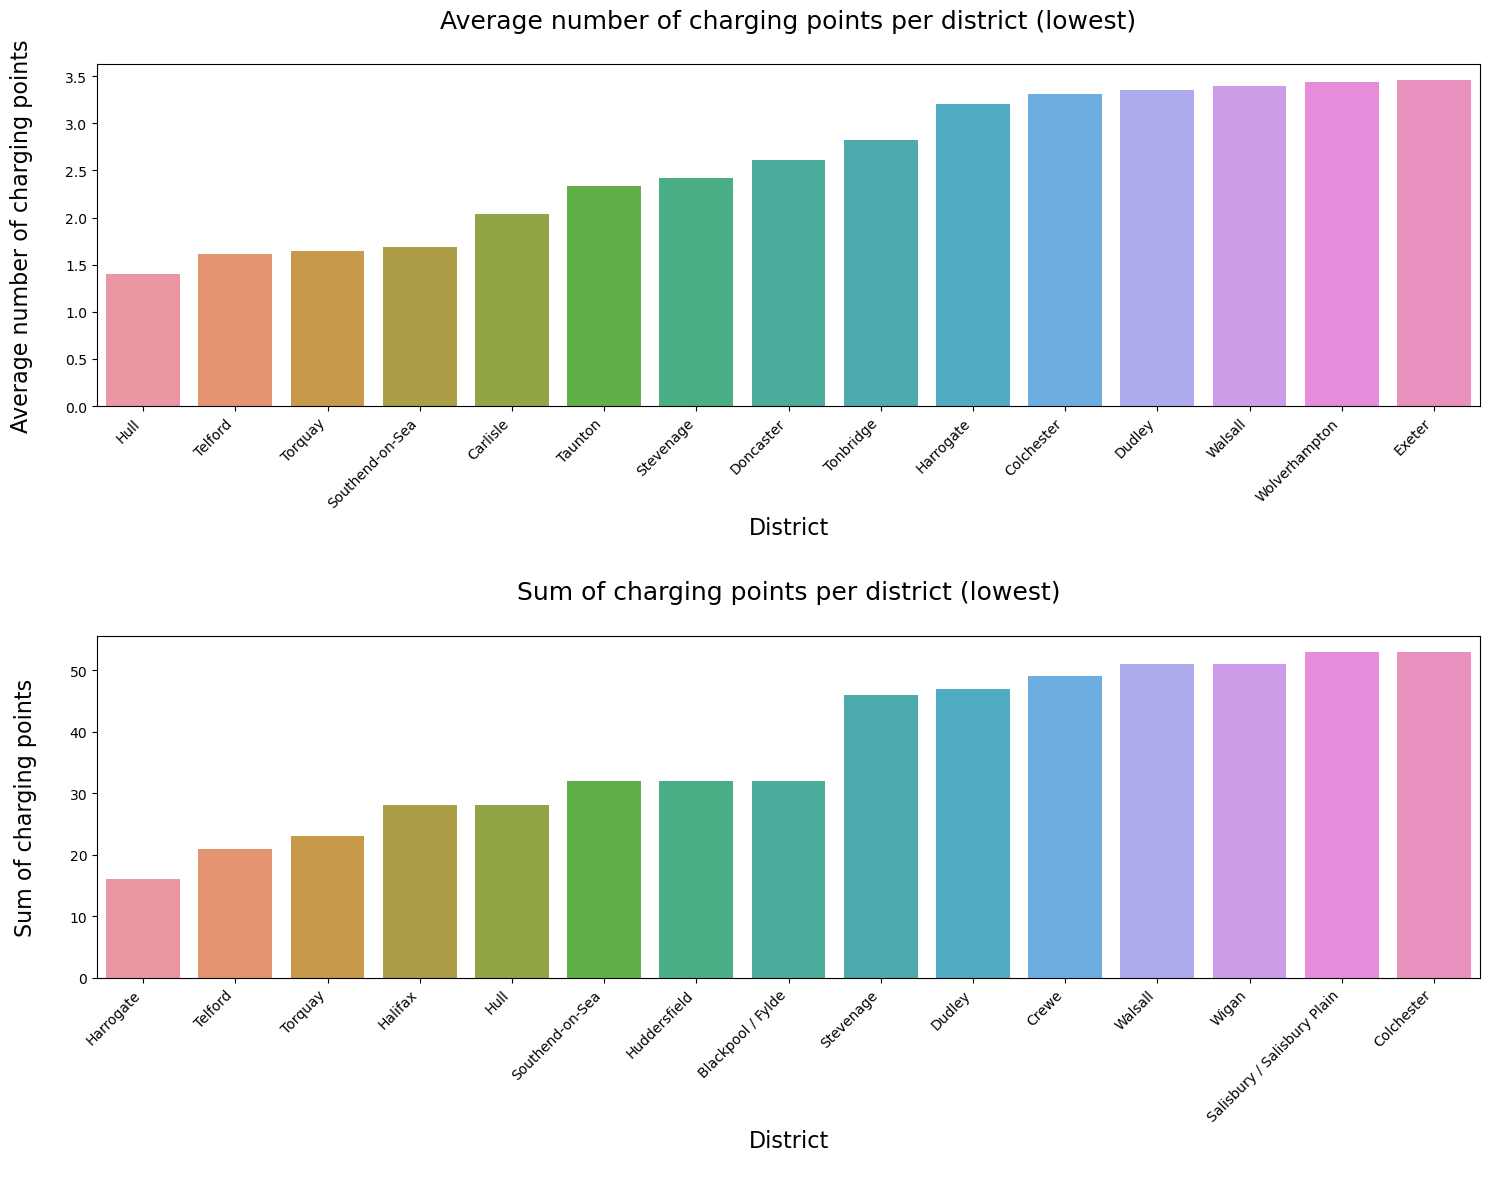

In [2884]:
# Plot the districts with the lowest number of charging points 
fig,ax = plt.subplots(nrows = 2, figsize = (15,12))

sns.barplot(data = bottom_districts, x= 'district', y ='charging_points', ax = ax[0])
ax[0].set_xticklabels(labels = bottom_districts['district'].values, rotation = 45, horizontalalignment='right')
ax[0].set_xlabel('District\n', fontsize = 16)
ax[0].set_ylabel('Average number of charging points\n', fontsize = 16)
ax[0].set_title('Average number of charging points per district (lowest)\n', fontsize = 18)

bottom_sum = sum_district.sort_values(by = 'charging_points', ascending = True)[:15]
sns.barplot(data = bottom_sum, x= 'district', y ='charging_points', ax = ax[1])
ax[1].set_xticklabels(labels = bottom_sum['district'].values, rotation = 45, horizontalalignment='right')
ax[1].set_xlabel('District\n', fontsize = 16)
ax[1].set_ylabel('Sum of charging points\n', fontsize = 16)
ax[1].set_title('Sum of charging points per district (lowest)\n', fontsize = 18)

plt.tight_layout()
plt.show()

In [1116]:
# compare house prices per district
price_dist = outcodes.groupby('district')[['charging_points','mean_price','median_price','parea_mean', 'parea_median']].mean()
price_dist.sort_values(by = 'charging_points')

charging_points    mean_price  median_price    parea_mean  \
district                                                                     
Hull                    1.400000  1.796019e+05  1.582348e+05   1858.874201   
Telford                 1.615385  2.404481e+05  2.132712e+05   2285.050857   
Torquay                 1.642857  3.562832e+05  2.974411e+05   3285.411027   
Southend-on-Sea         1.684211  3.384584e+05  3.091615e+05   3882.678394   
Carlisle                2.033333  2.011949e+05  1.764356e+05   1800.713540   
...                          ...           ...           ...           ...   
London SE              38.137931  5.435915e+05  4.754967e+05   6599.068026   
London E               47.045455  5.304679e+05  4.841762e+05   6584.697948   
London NW              94.166667  9.130778e+05  6.604091e+05   9658.063581   
London SW              98.758621  1.362130e+06  9.800839e+05  12573.858566   
London W              104.928571  1.768908e+06  1.253198e+06  14432.078206   

                 parea_median  
district                       
Hull              1804.639715  
Telford           2241.722575  
Torquay           3107.189907  
Southend-on-Sea   3731.266610  
Carlisle          1718.176868  
...                       ...  
London SE         6439.830768  
London E          6391.353613  
London NW         8953.411875  
London SW        11971.396789  
London W         13683.973661  

[96 rows x 5 columns]

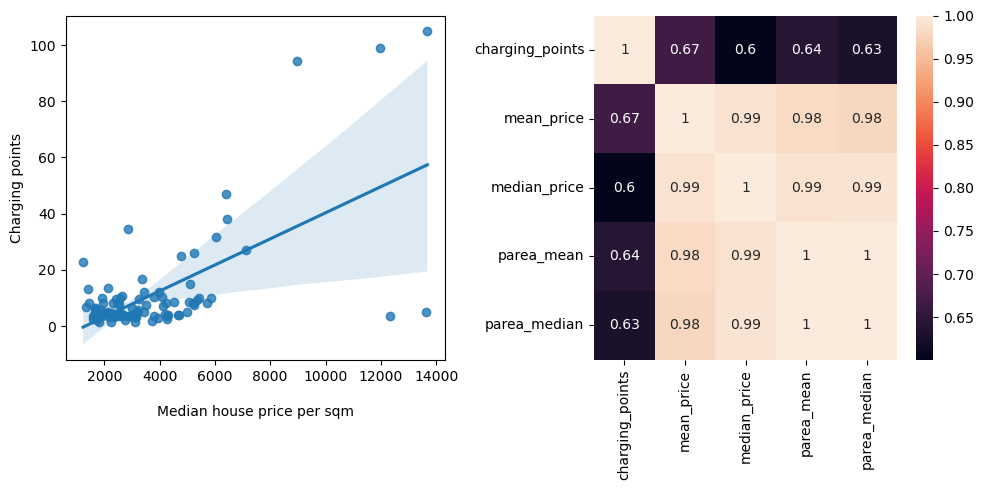

In [1120]:
# compare house prices of districts to number of charging points
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))
sns.regplot(data = price_dist, x = 'parea_median', y = 'charging_points', ax = ax[0])
ax[0].set_xlabel('\nMedian house price per sqm')
ax[0].set_ylabel('Charging points')

# top_areas = price_dist[price_dist.index.isin(top_districts['district'].unique())]
# bottom_areas = price_dist[price_dist.index.isin(bottom_districts['district'].unique())]
sns.heatmap(price_dist.corr(), annot = True, ax = ax[1])

plt.tight_layout()
plt.show()

In [245]:
# Look at the number of onstreet charging points per district
onstreet = outcodes[['outcode','district','charging_points','On-street']]
onstreet['onstreet'] = (onstreet['On-street']*onstreet['charging_points']).round(0)
onstreet = onstreet.groupby('district')[['charging_points','onstreet']].sum().sort_values(by = 'onstreet')

print('number of onstreet chargers outside of london: ', onstreet['onstreet'][~onstreet.index.isin(london)].sum())

onstreet['proportion'] = onstreet['onstreet']/onstreet['onstreet'].sum()
onstreet.sort_values(by = 'onstreet', ascending = False)

number of onstreet chargers outside of london:  2732.0


charging_points  onstreet  proportion
district                                                   
London W                         2938    2750.0    0.236457
London SW                        2864    2693.0    0.231556
London NW                        1130    1039.0    0.089338
London SE                        1106     904.0    0.077730
London E                         1035     847.0    0.072829
...                               ...       ...         ...
Bolton                             69       0.0    0.000000
Bristol                           299       0.0    0.000000
Cleveland / Teesside              237       0.0    0.000000
Bradford                          127       0.0    0.000000
Bath                              123       0.0    0.000000

[96 rows x 3 columns]

In [1681]:
# Investigate districts with signficant spread (e.g. some areas have very high numbers and some very low)
districts = []
min_vals = []
max_vals = []
for district in outcodes['district'].unique():
    df = outcodes[outcodes['district'] == district]
    districts.append(district)
    min_vals.append(df['charging_points'].min())
    max_vals.append(df['charging_points'].max())
    
ranges=pd.DataFrame({'district' : districts, 'max_charging' : max_vals, 'min_charging' : min_vals})    
ranges['range'] = ranges['max_charging'] - ranges['min_charging']
ranges.sort_values(by = 'range', ascending = False).head()

district  max_charging  min_charging  range
77  London SW           717             0    717
86   London W           459             0    459
55  London NW           271             0    271
16   Coventry           178             0    178
25   London E           175             0    175

From the above analysis, it is clear that there is a huge discrepancy between different regions. London has a very high concentration of charging points. However, even within London there is a large spread, with some of the highest and lowest number of charging points in the country. The next steps involved an a deeper dive into just London locations to see if these discrencies could be explained.

In [944]:
# create a copy of the shape file data
shp = shapefile.copy()
shp.rename(columns = {'PostDist': 'outcode'}, inplace = True)
# merge the charging points to this data
shp = shp.merge(outcodes[['outcode','charging_points', 'parea_median','council_owned', 'authority_1']], on = 'outcode')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


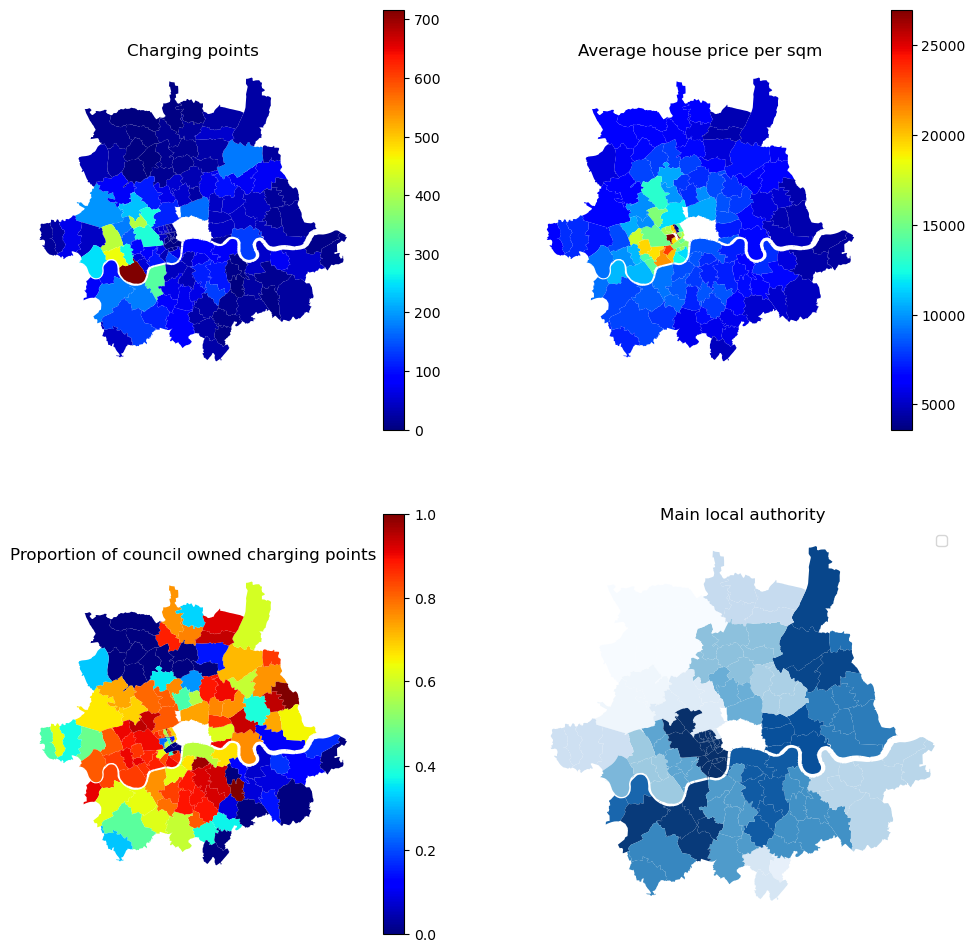

In [945]:
# subset the shape file for London
def london(x):
    try:
        return re.search(r'^(SW)\d|^(SE)\d|^(NW)\d|^(N)\d|^(E)\d|^(W)\d', x).group()
    except:
        return np.nan
all_vals = shp['outcode'].map(london)
london_index = all_vals[~all_vals.isna()].index

# create a df and plot with number of charging points and average house price
london = shp.loc[london_index]

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (12,12))
london.plot(ax=ax[0,0], column = 'charging_points', legend = True, cmap = 'jet')
ax[0,0].axis('off')
ax[0,0].set_title('Charging points')
london.plot(ax=ax[0,1], column = 'parea_median', legend = True, cmap = 'jet')
ax[0,1].axis('off')
ax[0,1].set_title('Average house price per sqm')
london.plot(ax=ax[1,0], column = 'council_owned', legend = True, cmap = 'jet')
ax[1,0].axis('off')
ax[1,0].set_title('Proportion of council owned charging points')
london.plot(ax=ax[1,1], column = 'authority_1', legend = True, cmap = 'Blues')
ax[1,1].axis('off')
ax[1,1].legend()
ax[1,1].set_title('Main local authority')
# cmaps = ['viridis', 'jet', 'blues']
plt.show()

It was noticed from the above that areas of high concentrations could be grouped by being covered by the same local authorities. 

In [2063]:
# look at the local authorities of the areas with the most charging points
outcodes[['outcode','authority_1','charging_points','council_owned']].loc[london_ind].sort_values(by = 'charging_points', 
                                                                                 ascending = False)[:20]

outcode             authority_1  charging_points  council_owned
1708     SW6  Hammersmith and Fulham              717       0.846583
1908      W6  Hammersmith and Fulham              459       0.847495
1888     W12  Hammersmith and Fulham              413       0.813559
1911      W9             Westminster              407       0.948403
1686    SW11              Wandsworth              327       0.755352
1904      W2             Westminster              280       0.900000
1237     NW8             Westminster              271       0.937269
1890     W14  Hammersmith and Fulham              267       0.902622
1906      W4                Hounslow              248       0.814516
1235     NW6                  Camden              226       0.685841
1229    NW10                   Brent              196       0.663265
1693    SW18              Wandsworth              178       0.629213
1886     W10  Kensington and Chelsea              178       0.904494
1690    SW15              Wandsworth              177       0.627119
538      E17          Waltham Forest              175       0.714286
1063      N1               Islington              168       0.738095
1887     W11  Kensington and Chelsea              151       0.887417
535      E14           Tower Hamlets              134       0.761194
1516    SE22               Southwark              134       0.925373
1699    SW1V             Westminster              133       0.902256

In [605]:
# Look at the number of charging points where the main local authority is Hammsersmith and Fulham
outcodes['charging_points'][outcodes['authority_1'] == 'Hammersmith and Fulham'].value_counts()

717    1
413    1
267    1
459    1
Name: charging_points, dtype: int64

### Conclusions from EDA

#### Rural vs Urban
After further EDA it is clear that there is a sparsity in rural areas of England. However, this does not necessarily match demand especially considering regions that still have a proximity to busy roads. As indicated by data<sup>1</sup>, there is a lack of onstreet electric car charging stations outside of London, and in general a massive monopoloy in London, with 42.4% of all charging stations located in London. Other populous cities such as Birmingham and Manchester have only 274 and 348 charging points in total respectively, compared to London's 9887.

#### Effect of Affluency
There is some correlation with the affluency of an area as measured by average house prices. The areas with very high densities tend to also have higher than average house prices, which is logical consider the high cost of electric cars. However this is not consistent. For example in London there are very affluent areas with very low numbers of charging points. Here there seems much more dependency on the local authorities. 

#### Districts / Local Authorities
During EDA it was discovered that there is a marked difference between different regions in England. A high proportion of all charging points in England are found in London. There also seems to be a trend to show that areas of high number of charging points are often covered by the same local authority. Research showed the existence of several government funded EV charging station schemes in the past few years. Schemes including the Go Ultra Low City Scheme<sup>2</sup>, the the On-Street Residential Chargepoint Scheme<sup>3</sup> and the Ultra Low Emission Taxi Infrastructure Scheme<sup>4</sup> are likely to have had an impact on the density of charging points within specific areas. For example, the Go Ultra low city scheme awarded the following areas the following amounts in 2016 for initatives to support the uptake of electric vehicles:
    
1. London councils & Greater London Authority (GLA) (£13 mil)
2. Milton Keynes (£9 mil)
3. Bristol (£7 mil)
4. Nottinghamshire & Derby (£6 mil)
5. Oxford, Dundee, York & North west regions (South Gloucestershire, North Somerset, Bath & North East Somerset) (£5 mil)
      
Meanwhile, the On-Street Residential Chargepoint Scheme is awarding local authorities free advice and up to 60% of the capital costs for EV schemes, and the Ultra Low Emission Taxi Infrastructure Scheme awarded a total of £20 million for the implementation of local EV taxi schemes. 

The authorities that were awarded funded from the various governments schemes, are also the areas within the dataset that have the highest numbers of charging points. The districts with the highest number of charging points were some of the winners of the Go Ultra Low cities scheme (London (inc. greater London), Milton Keynes, Bristol & Oxford), and local authorities with the highest numbers were among the winners of the Ultra Low Emission Tax Infrastructure bid (Coventry, Brighton and Hove, Manchester and Nottingham). Further reasearch showed that areas such as Hammersmith and Fulham, and Westminster, with very high number of charging points, have had big local initiatives to increase the number of electric car charging stations.<sup>5,6</sup> 

It seems that local government is a huge driving force in the placement of EV charging stations. Unfortunately, the data here was aggregated by outcode, which can be covered by multiple local authorities. We can get a further clue here from the proportions of charging points that are coucil/borough owned. For future work, it may make sense to reconsider the method by which the charging point data is aggregated. However, for the purpose of modelling, the main 3 authorities per outcode were considered.

<sup>1</sup>https://www.gov.uk/government/publications/electric-vehicle-charging-market-study-final-report/final-report  
<sup>2</sup>https://www.gov.uk/government/news/40-million-to-drive-green-car-revolution-across-uk-cities  
<sup>3</sup>https://www.gov.uk/government/publications/grants-for-local-authorities-to-provide-residential-on-street-chargepoints/grants-to-provide-residential-on-street-chargepoints-for-plug-in-electric-vehicles-guidance-for-local-authorities#about-the-on-street-residential-chargepoint-scheme  
<sup>4</sup>https://www.gov.uk/government/publications/ultra-low-emission-taxi-infrastructure-scheme-round-2  
<sup>5</sup>https://www.lbhf.gov.uk/transport-and-roads/electric-vehicles  
<sup>6</sup>https://www.westminster.gov.uk/parking/electric-vehicles

# 4. Modelling

### 4.1 Regression models

The initial hypothesis was that the location of EV stations could be predicted by traffic flow around a certain area. Therefore, for the initial model only the traffic variables were included. 

In [791]:
# create the predictor and target variables
X = df2[['dist_in','dist_out', 'flow_in', 'flow_out']]
y = outcodes['charging_points']

In [792]:
# Create a test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle = True, random_state=3)

# scale the values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [793]:
# create a linear regression model
def linear_regression(model, X_train, y_train, X_test, y_test):
    cvs = cross_val_score(model, X_train, y_train, cv=5)
    cvs_mean = np.mean(cvs)
    model.fit(X_train,y_train)
    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    results = pd.Series([cvs_mean, train_score, test_score], index = ['cross validation mean', 'training score', 'test_score'])
    return pd.DataFrame({'LR results' : results})

# instantiate a model
model = LinearRegression()
# fit and score the model using the function above
linear_regression(model, X_train, y_train, X_test, y_test)

LR results
cross validation mean    0.026440
training score           0.041377
test_score               0.034257

In [794]:
# evaluate the significance of these variables using stats models
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
predictions = results.predict(sm.add_constant(X))
print("R2-score: ", results.rsquared)
print("RMSE:", np.sqrt(mean_squared_error(y, predictions)))

R2-score:  0.04027768100662332
RMSE: 31.438321660554223


In [795]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        charging_points   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     22.47
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           3.33e-18
Time:                        17:29:42   Log-Likelihood:                -10449.
No. Observations:                2147   AIC:                         2.091e+04
Df Residuals:                    2142   BIC:                         2.094e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4582      5.562      0.981      0.327      -5.449      16.366
dist_in      243.1150     30.650      7.932      0.000     183.008     303.222
dist_out    -246.3335     30.199     -8.157      0.000    -305.557    -187.110
flow_in       11.6589      3.055      3.816      0.000       5.668      17.650
flow_out       2.2429      3.112      0.721      0.471      -3.860       8.346
==============================================================================
Omnibus:                     3496.952   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2439003.944
Skew:                          10.469   Prob(JB):                         0.00
Kurtosis:                     166.786   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Conclusions from initial model**

Despite the fact that the regression model has not been tuned, it is clear that the traffic variables alone are not strongly predicting the location of charging points. This is unsurprising after the initial EDA, where no relationship was seen between areas of high traffic density and areas of high charging station density. It can therefore be concluded that the inital hypothesis that locations of charging points can be predicted from the surrounding traffic flow can be rejected.

Leading on from this, additional variables will be added in, to see if we can conclude what features are predicting charging point hotspots. The first approach was to put all of the variables that might have an affect in, then using regularization and statsmodels, determine the important features. 

In [915]:
# ensure the urban code is just mapped to a single letter
df2['urban_code'] = df2['urban_code'].map(get_code)  

In [596]:
df2.head()

outcode  latitude  longitude   district urban_code  urban  urban_index  \
0     AL1  51.74836   -0.32237  St Albans         C1    1.0     1.000000   
1    AL10  51.75958   -0.22920  St Albans         C1    1.0     0.997455   
2     AL2  51.72064   -0.33353  St Albans         C1    1.0     0.940816   
3     AL3  51.77781   -0.37057  St Albans         C1    1.0     0.637270   
4     AL4  51.77133   -0.29398  St Albans         C1    1.0     0.712665   

       authority_1          authority_2           authority_3  ...  \
0        St Albans                 none                  none  ...   
1  Welwyn Hatfield                 none                  none  ...   
2        St Albans            Hertsmere                  none  ...   
3        St Albans              Dacorum  Central Bedfordshire  ...   
4        St Albans  North Hertfordshire       Welwyn Hatfield  ...   

  traffic_out road_out                     coords_out     mean_price  \
0         0.5     A414  (51.73326068970592, -0.347...  581985.165173   
1         1.0    A1(M)  (51.7644824572925, -0.2371...  339066.693125   
2         0.5     A414  (51.73326068970592, -0.347...  520485.739383   
3         1.0       M1  (51.76745104994985, -0.415...  615109.849253   
4         1.0    A1(M)  (51.7644824572925, -0.2371...  592852.597302   

   median_price   parea_mean  parea_median   area_km2   flow_in  flow_out  
0      487000.0  6849.261857   6639.444444  10.121563  0.461843  0.459428  
1      320000.0  4247.504242   4117.042707  15.548443  0.967634  0.974245  
2      487000.0  5418.181315   5173.416199  27.268665  0.485380  0.486573  
3      550000.0  6349.965822   6026.065546  69.641401  0.890180  0.903878  
4      557000.0  5935.174982   5789.473684  49.539222  0.917932  0.927769  

[5 rows x 52 columns]

In [598]:
# create a new set of predictors with additional variables
X2 = df2[['outcode','district', 'urban_code','council_owned','parea_median','dist_in','flow_in', 'charging_points']].copy()
X2.head()

outcode   district urban_code  council_owned  parea_median   dist_in  \
0     AL1  St Albans         C1            0.3   6639.444444  0.923685   
1    AL10  St Albans         C1            0.0   4117.042707  0.967634   
2     AL2  St Albans         C1            0.0   5173.416199  0.970759   
3     AL3  St Albans         C1            0.0   6026.065546  0.890180   
4     AL4  St Albans         C1            0.0   5789.473684  0.917932   

    flow_in  charging_points  
0  0.461843               10  
1  0.967634               17  
2  0.485380                9  
3  0.890180                5  
4  0.917932                3

In [916]:
# create a new set of predictors with additional variables
X2 = df2[['district', 'urban_code','council_owned','parea_median','dist_in','flow_in', 'charging_points']].copy()

# the price variable still has some missing values - drop these
X2.dropna(inplace = True)
# create the target variable
y2 = X2.pop('charging_points')

# dummify the additonal variables
X2 = pd.get_dummies(X2, columns = ['urban_code','district'], drop_first = True)

In [917]:
# Create a test train split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, shuffle = True, random_state=1)

In [918]:
# scale the numerical values in our train and test sets using standard scaler
scaler = StandardScaler()
X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

In [919]:
# run a loop of Regressor models
def regressor_models(X_train, X_test, y_train, y_test):
    models = [LinearRegression(),
              DecisionTreeRegressor(),
              RandomForestRegressor()]

    for model in models:
        print(model)
        print()
        model.fit(X_train, y_train)
        cvs = cross_val_score(model, X_train, y_train, cv=5)
        cvs_mean = np.mean(cvs)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        print('Cross val mean: ', cvs_mean)
        print('Score on train set: ', train_score)
        print('Score on test set: ', test_score)
        print()
        print('-'*60)
        print()
        
regressor_models(X2_train, X2_test, y2_train, y2_test)      

LinearRegression()

Cross val mean:  0.33867273866963044
Score on train set:  0.48244403130709945
Score on test set:  0.295787426931197

------------------------------------------------------------

DecisionTreeRegressor()

Cross val mean:  -0.04375844785753045
Score on train set:  1.0
Score on test set:  0.33868610177901226

------------------------------------------------------------

RandomForestRegressor()

Cross val mean:  0.4824822693248267
Score on train set:  0.9334801369661296
Score on test set:  0.3983634795816813

------------------------------------------------------------



In [920]:
# apply a ridge CV to try and tune parameters
# create a model instance 
optimal_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)
# fit the model
optimal_ridge.fit(X2_train,y2_train)
# find the optimal alpha
ridge_alpha = optimal_ridge.alpha_
# evaluate the model on the training set
train_score = optimal_ridge.score(X2_train, y2_train)
#  evaluate on the test set
test_score = optimal_ridge.score(X2_test, y2_test)
# cross validate the results from the optimal alpha
model = Ridge(alpha=ridge_alpha)
cvs_ridge = cross_val_score(model, X2_train, y2_train, cv=5)
# Display results
print('Ridge')
print('Optimal alpha: ', ridge_alpha)
print('\nTrain score: ', train_score) 
print('\nMean cross val score: ', np.mean(cvs_ridge))
print('\nTest score:', test_score) 

Ridge
Optimal alpha:  1464.9713983072863

Train score:  0.38693367372302867

Mean cross val score:  0.34227645889362857

Test score: 0.23645044218056277


In [921]:
# look at the magnitude of the coefficients from ridge regression
coef_ridge = pd.DataFrame(list(zip(X2.columns, optimal_ridge.coef_)), columns = ['variable','coefficient'])
coef_ridge['abs'] = abs(coef_ridge['coefficient'])
coef_ridge.sort_values(by = 'abs', ascending = False)[:10]

variable  coefficient       abs
58   district_London W     4.726491  4.726491
0        council_owned     4.345497  4.345497
55  district_London NW     2.847571  2.847571
57  district_London SW     2.446618  2.446618
52   district_London E     1.657296  1.657296
1         parea_median     1.641143  1.641143
24   district_Coventry     1.379885  1.379885
56  district_London SE     1.220576  1.220576
6         urban_code_D    -1.151196  1.151196
3              flow_in     0.800900  0.800900

In [922]:
# apply a lasso CV to try and tune parameters
# create a model instance 
optimal_lasso = LassoCV(n_alphas=500, cv=10)
# fit the model
optimal_lasso.fit(X2_train,y2_train)
# find the optimal alpha
lasso_alpha = optimal_lasso.alpha_
# evaluate the model on the training set
train_score = optimal_lasso.score(X2_train, y2_train)
#  evaluate on the test set
test_score = optimal_lasso.score(X2_test, y2_test)
# cross validate the results from the optimal alpha
model = Lasso(alpha=lasso_alpha)
cvs_lasso = cross_val_score(model, X2_train, y2_train, cv=5)
# Display results
print('Lasso')
print('Optimal alpha: ', lasso_alpha)
print('\nTrain score: ', train_score) 
print('\nMean cross val score: ', np.mean(cvs_lasso))
print('\nTest score:', test_score) 

Lasso
Optimal alpha:  0.09393968495364967

Train score:  0.4792570606263683

Mean cross val score:  0.3540419075655235

Test score: 0.29861737654985787


In [923]:
# look at the magnitude of the coefficients from lasso regression
coef_lasso = pd.DataFrame(list(zip(X2.columns, optimal_lasso.coef_)), columns = ['variable','coefficient'])
coef_lasso['abs'] = abs(coef_lasso['coefficient'])
coef_lasso.sort_values(by = 'abs', ascending = False)[:10]

variable  coefficient        abs
58    district_London W    11.863623  11.863623
57   district_London SW     7.806787   7.806787
0         council_owned     6.713780   6.713780
55   district_London NW     6.530658   6.530658
1          parea_median    -6.283294   6.283294
52    district_London E     3.750540   3.750540
56   district_London SE     3.584891   3.584891
24    district_Coventry     2.611734   2.611734
95  district_Twickenham     1.868452   1.868452
26     district_Croydon     1.800060   1.800060

In [924]:
# Find the coefficients which lasso has reduced to 0
print(coef_lasso[coef_lasso['coefficient'] == 0].shape[0])
coef_lasso['variable'][coef_lasso['coefficient'] == 0].values

23


array(['urban_code_B', 'urban_code_C', 'district_Bournemouth',
       'district_Canterbury', 'district_Colchester',
       'district_Darlington', 'district_Dartford', 'district_Durham',
       'district_Exeter', 'district_Gloucester', 'district_Harrogate',
       'district_Ipswich', 'district_Lancaster', 'district_Leeds',
       'district_Leicester', 'district_Manchester', 'district_Norwich',
       'district_Reading',
       'district_Rochester / Medway (now sometimes known as Maidstone)',
       'district_Salisbury / Salisbury Plain', 'district_Tonbridge',
       'district_Truro', 'district_Wigan'], dtype=object)

In [925]:
# apply an Elasticnet CV to try and tune parameters
# create a model instance 
optimal_en = ElasticNetCV(l1_ratio=np.linspace(0.01, 1.0, 25), n_alphas=100, cv=10)
# fit the model
optimal_en.fit(X2_train,y2_train)
# find the optimal alpha and l1 ration
en_alpha = optimal_en.alpha_
l1_ratio = optimal_en.l1_ratio_
# evaluate the model on the training set
train_score = optimal_en.score(X2_train, y2_train)
# evaluate on the test set
test_score = optimal_en.score(X2_test, y2_test)
# cross validate the results from the optimal alpha
model = ElasticNet(alpha=en_alpha, l1_ratio = l1_ratio)
cvs_en = cross_val_score(model, X2_train, y2_train, cv=5)
# Display results
print('Elasticnet')
print('Optimal alpha: ', en_alpha)
print('L1 Ratio: ', l1_ratio)
print('\nTrain score: ', train_score) 
print('\nMean cross val score: ', np.mean(cvs_en))
print('\nTest score:', test_score) 

Elasticnet
Optimal alpha:  0.05189551459955311
L1 Ratio:  0.34

Train score:  0.47824061258245754

Mean cross val score:  0.36518357846444355

Test score: 0.29660401248617685


In [926]:
# look at the magnitude of the coefficients from lasso regression
coef_en = pd.DataFrame(list(zip(X2.columns, optimal_en.coef_)), columns = ['variable','coefficient'])
coef_en['abs'] = abs(coef_lasso['coefficient'])
coef_en.sort_values(by = 'abs', ascending = False)[:10]

variable  coefficient        abs
58    district_London W    11.011757  11.863623
57   district_London SW     7.020069   7.806787
0         council_owned     6.624039   6.713780
55   district_London NW     6.124191   6.530658
1          parea_median    -5.368803   6.283294
52    district_London E     3.426206   3.750540
56   district_London SE     3.154416   3.584891
24    district_Coventry     2.429621   2.611734
95  district_Twickenham     1.615578   1.868452
26     district_Croydon     1.641961   1.800060

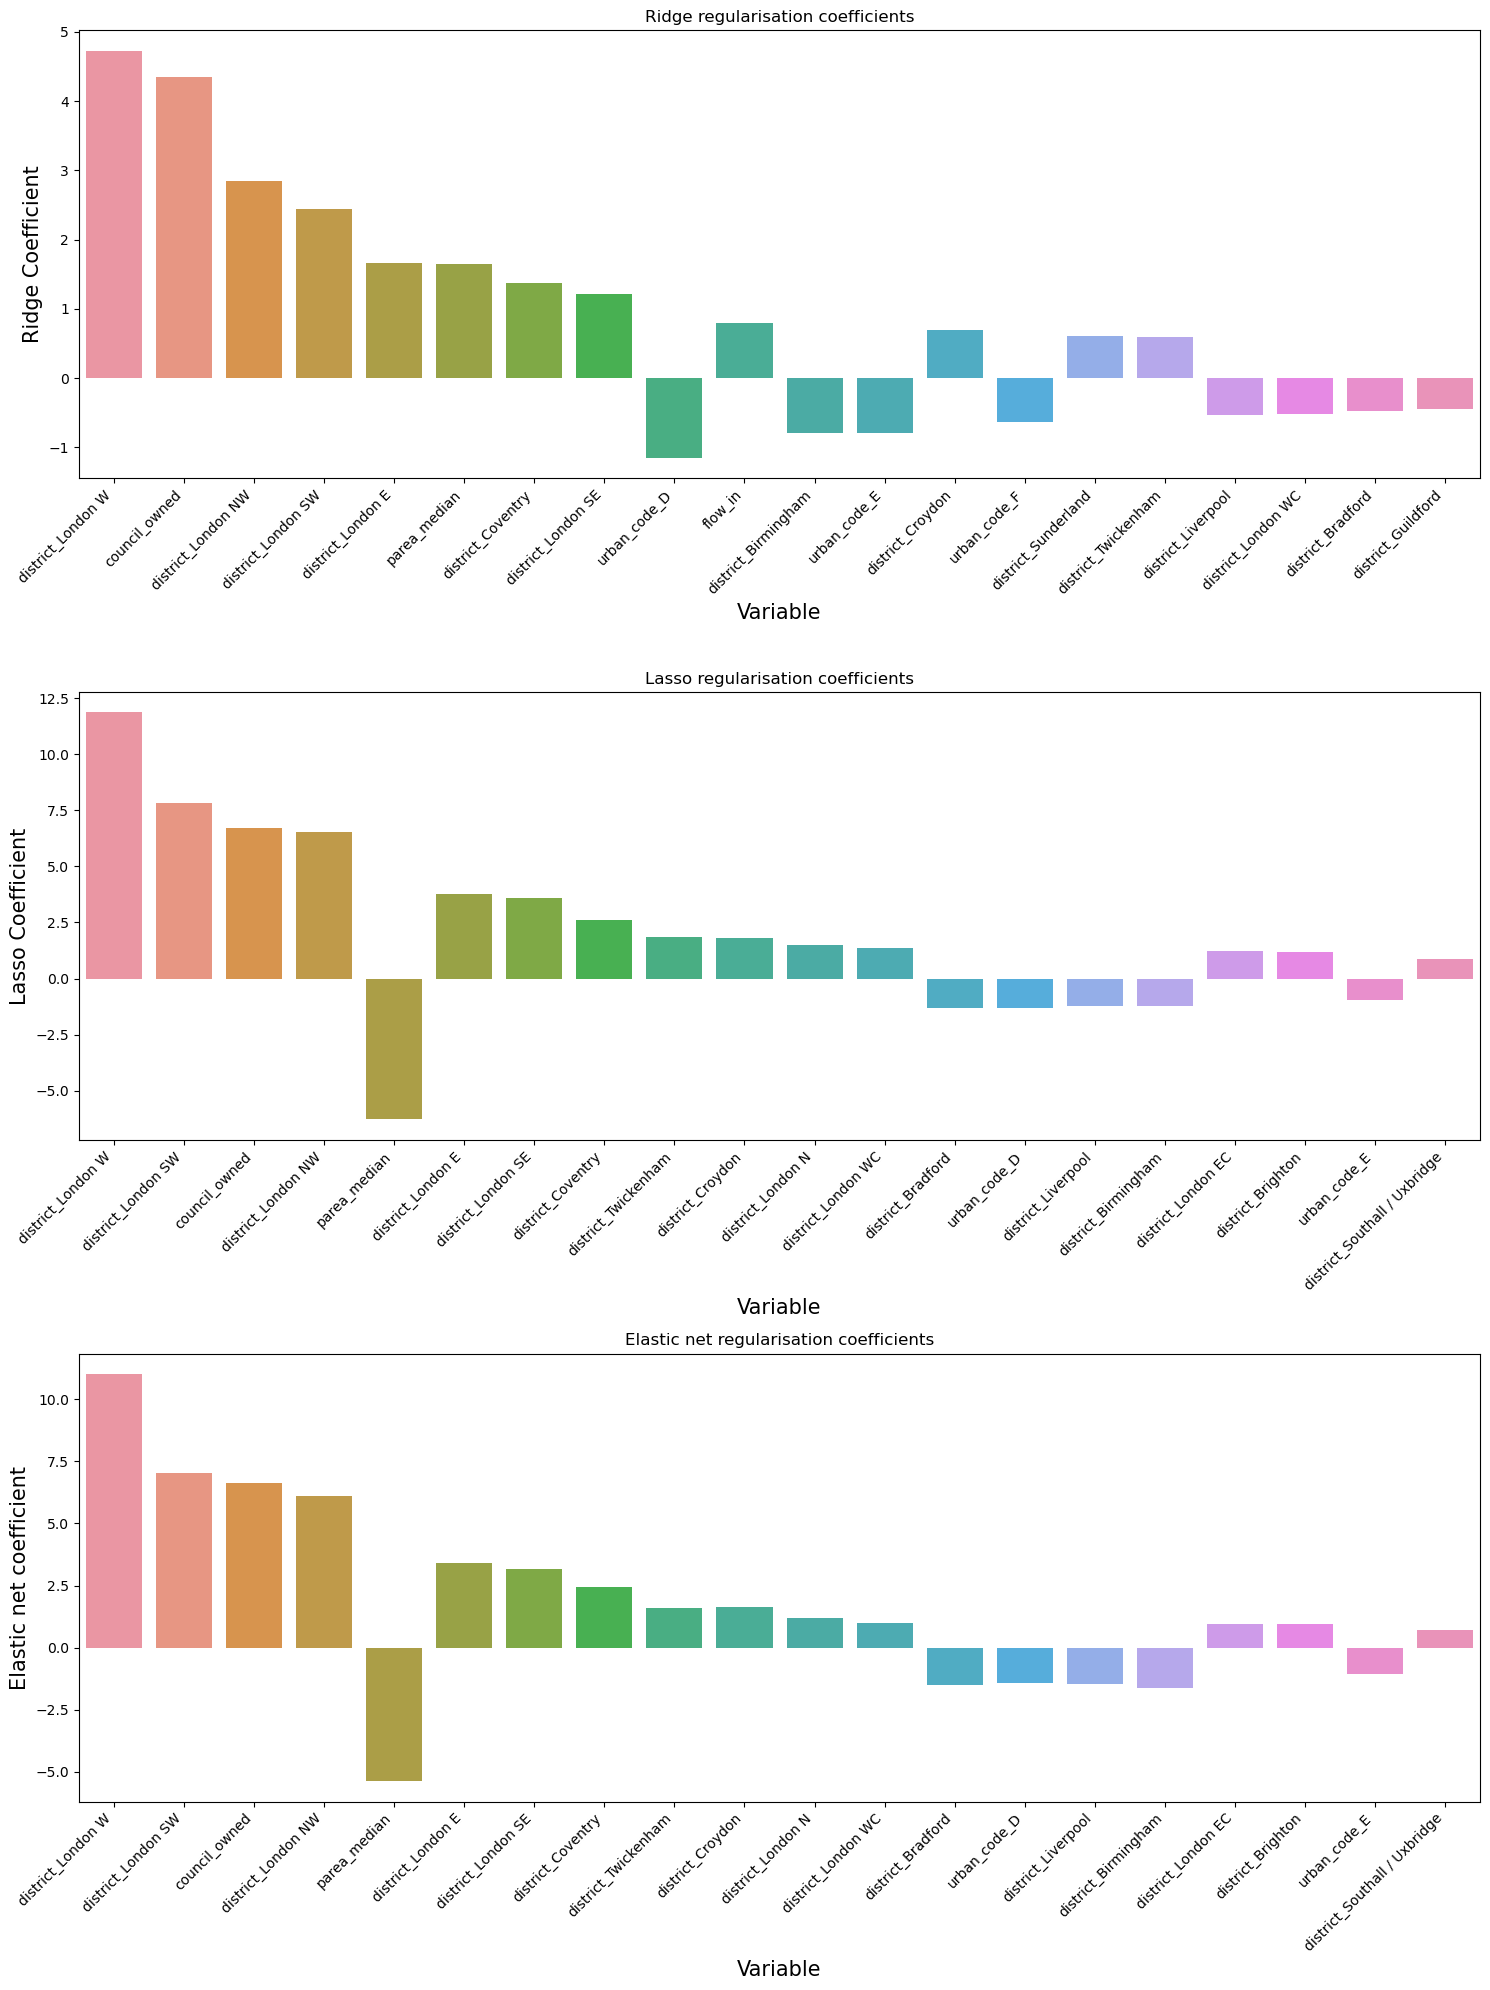

In [927]:
# plot the 20 coefficents with the greatest magnitude from each method of regularization
fig, ax = plt.subplots(nrows = 3, figsize = (15,20))

ridge_largest = coef_ridge.sort_values(by = 'abs', ascending = False)[:20]
sns.barplot(data = ridge_largest, x = 'variable', y = 'coefficient', ax = ax[0])
ax[0].set_xlabel("Variable\n", fontsize = 15)
ax[0].set_ylabel("Ridge Coefficient", fontsize = 15)
ax[0].set_xticklabels(labels = ridge_largest['variable'], rotation = 45, horizontalalignment='right')
ax[0].set_title('Ridge regularisation coefficients')

lasso_largest = coef_lasso.sort_values(by = 'abs', ascending = False)[:20]
sns.barplot(data = lasso_largest, x = 'variable', y = 'coefficient', ax=ax[1])
ax[1].set_xlabel("Variable", fontsize = 15)
ax[1].set_ylabel("Lasso Coefficient", fontsize = 15)
ax[1].set_xticklabels(labels = lasso_largest['variable'], rotation = 45, horizontalalignment='right')
ax[1].set_title('Lasso regularisation coefficients')

en_largest = coef_en.sort_values(by = 'abs', ascending = False)[:20]
sns.barplot(data = en_largest, x = 'variable', y = 'coefficient', ax=ax[2])
ax[2].set_xlabel("Variable", fontsize = 15)
ax[2].set_ylabel("Elastic net coefficient", fontsize = 15)
ax[2].set_xticklabels(labels = en_largest['variable'], rotation = 45, horizontalalignment='right')
ax[2].set_title('Elastic net regularisation coefficients')

plt.tight_layout()
plt.show()

In [928]:
# Compare the Rsquared scores for each regression model
regression = pd.Series([np.mean(cvs_ridge), np.mean(cvs_lasso), np.mean(cvs_en)], index = ['ridge', 'lasso', 'enet'])
pd.DataFrame({'Regression test scores' : regression})

Regression test scores
ridge                0.342276
lasso                0.354042
enet                 0.365184

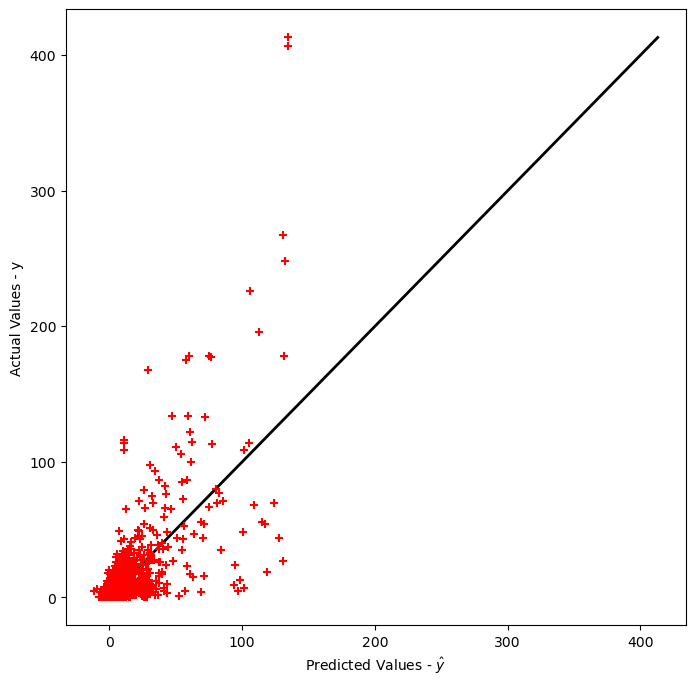

In [929]:
# plot the values of y predicted by the elasticnet method (best predictions) against the true values of y
predictions_train = optimal_en.predict(X2_train)
predictions_test = optimal_en.predict(X2_test)

plt.figure(figsize=(8, 8))
plt.scatter(predictions_train, y2_train, s=30, c='r', marker='+', zorder=10)
plt.plot([y2_train.min(), y2_train.max()], [y2_train.min(), y2_train.max()], c='k', lw=2)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - y")
plt.show()

In [930]:
# calculate the residuals for the elasticnet method for the training dataset
df_train = pd.DataFrame({'y_train': y2_train, 'y_hat' : predictions_train})
df_train['residuals'] = df_train['y_train'] - df_train['y_hat']
df_train.sort_values(by = 'residuals')

y_train       y_hat   residuals
1889       27  130.835126 -103.835126
1901       19  118.401549  -99.401549
1897        7  101.779838  -94.779838
1891        5   96.906711  -91.906711
1894       13   98.362475  -85.362475
...       ...         ...         ...
1235      226  105.944629  120.055371
1890      267  131.095488  135.904512
1062      168   29.310379  138.689621
1911      407  134.613352  272.386648
1888      413  134.459803  278.540197

[1604 rows x 3 columns]

In [931]:
# calculate the residuals for the elasticnet method for the test dataset
df_test = pd.DataFrame({'y_test': y2_test, 'y_hat' : predictions_test})
df_test['residuals'] = df_test['y_test'] - df_test['y_hat']
df_test.sort_values(by = 'residuals')

y_test       y_hat   residuals
1903      25  144.272680 -119.272680
1909      18  127.979532 -109.979532
1893       3  109.829691 -106.829691
1230       4   90.105304  -86.105304
1238      31  105.256883  -74.256883
...      ...         ...         ...
1904     280  121.597337  158.402663
1237     271   99.961561  171.038439
1686     327   77.415359  249.584641
1908     459  131.639095  327.360905
1708     717   76.840285  640.159715

[402 rows x 3 columns]

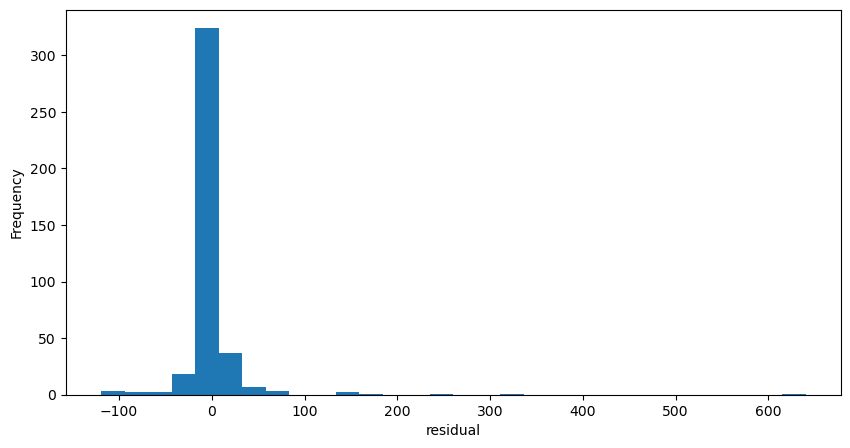

In [932]:
# plot the residuals
fig, ax = plt.subplots(figsize = (10,5))
plt.hist(df_test['residuals'], bins = 30)
plt.xlabel('residual')
plt.ylabel('Frequency');

In [933]:
# areas where the number of charging points is being signficantly overpredicted
# often seem to be London areas where there are currently not many charging stations
overpredict = df_train.sort_values(by = 'residuals')[:20].index

df2.loc[overpredict].head()

outcode  latitude  longitude  district urban_code  urban  urban_index  \
1889     W13  51.51270   -0.31951  London W          A    1.0          1.0   
1901     W1T  51.51980   -0.13473  London W          A    1.0          1.0   
1897     W1J  51.50735   -0.14388  London W          A    1.0          1.0   
1891     W1B  51.51357   -0.13931  London W          A    1.0          1.0   
1894     W1F  51.51261   -0.13502  London W          A    1.0          1.0   

      authority_1  authority_2 authority_3  ... road_out  \
1889       Ealing         none        none  ...       M4   
1901       Camden  Westminster        none  ...       M1   
1897  Westminster    Islington        none  ...       M1   
1891  Westminster         none        none  ...       M1   
1894  Westminster         none        none  ...       M1   

                                      coords_out    mean_price  median_price  \
1889  (51.495368804733225, -0.34433949709832484)  7.030226e+05      650000.0   
1901   (51.57481265488363, -0.23434574613470754)  1.700451e+06     1341800.0   
1897   (51.57481265488363, -0.23434574613470754)  3.520916e+06     2339702.5   
1891   (51.57481265488363, -0.23434574613470754)  3.641710e+06     2137500.0   
1894   (51.57481265488363, -0.23434574613470754)  1.425075e+06      870000.0   

        parea_mean  parea_median  area_km2                   geometry  \
1889   7789.925756   7578.536184  3.855688  POINT (-0.31951 51.51270)   
1901  14025.889545  13491.620112  0.392006  POINT (-0.13473 51.51980)   
1897  21593.542058  19382.208945  0.398906  POINT (-0.14388 51.50735)   
1891  26856.763926  26856.763926  0.184625  POINT (-0.13931 51.51357)   
1894  11397.477522  15659.340659  0.207185  POINT (-0.13502 51.51261)   

       flow_in  flow_out  
1889  0.709624  0.870841  
1901  0.631125  0.423732  
1897  0.633409  0.421039  
1891  0.632075  0.424113  
1894  0.627180  0.418571  

[5 rows x 53 columns]

**Initial modelling conclusions**

Although the model scores can be slightly improved with regularization, each of the models are giving quite low Rsquared scores (particularly for the test sets). The highest Rsquared is from the elasticnet method (with an L1 ratio of 0.2). However, there is not a significant difference between the models.

Looking at the coefficients, we can see some consistency across the models of which variables are having an impact on predicting the number of charging points. In all models the districts of London W and London SW are having the a very high impact, with the elasticnet model suggesting that an outcode being located in one of these districts is going to increase the average number of charging points by 10.5 and 6.6 times respectively. The proportion of council owned charging points is also showing up as an important indicator, suggesting that local government is a crucial driving force in the installation of EV charging stations. One discrepancy between the 3 regularization models is the impact of the parea_median variable (median house price per sqm). In the ridge model, the indication is that areas with higher average house price per sqm, have a higher number of charging points. However, elasticnet and lasso show the inverse relationship.

Based on these results, a deeper dive should be taken into the impact of each variable with statsmodels. However, based on the high skew of the target variable, it was also concluded that this problem would be better resolved with a classification approach, predicting high vs low number of charging points as opposed to the precise number.

#### Use councils instead of district

In [1159]:
# create predictor and target variables using local authority (only the main local authority)
X3 = df2[['authority_1', 'parea_median', 'council_owned','urban_code', 'charging_points']]
X3.dropna(inplace = True)

y3 = X3.pop('charging_points')

In [1160]:
# Dummify predictor variables
X3 = pd.get_dummies(X3, drop_first = True)

In [1161]:
# Create a test train split
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.2, shuffle = True, random_state=1)

In [1162]:
# run a loop of Regressor models
def regressor_models(X_train, X_test, y_train, y_test, X, y):
    models = [LinearRegression(),
              DecisionTreeRegressor(),
              RandomForestRegressor()]

    for model in models:
        print(model)
        print()
        model.fit(X_train, y_train)
        cvs = cross_val_score(model, X, y, cv=5)
        cvs_mean = np.mean(cvs)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        print('Cross val mean: ', cvs_mean)
        print('Score on train set: ', train_score)
        print('Score on test set: ', test_score)
        print()
        print('-'*60)
        print()
        
regressor_models(X3_train, X3_test, y3_train, y3_test, X3, y3)    

LinearRegression()

Cross val mean:  -3.2224191631401036e+16
Score on train set:  0.6463309326524938
Score on test set:  0.5818745481297032

------------------------------------------------------------

DecisionTreeRegressor()

Cross val mean:  -0.12984805383314973
Score on train set:  0.9999995437422144
Score on test set:  0.49948743834295506

------------------------------------------------------------

RandomForestRegressor()

Cross val mean:  0.2554378965573902
Score on train set:  0.9278996712416301
Score on test set:  0.6308627186108923

------------------------------------------------------------



In [1163]:
# apply a ridge CV to try and tune parameters
# create a model instance 
optimal_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)
# fit the model
optimal_ridge.fit(X3_train,y3_train)
# find the optimal alpha
ridge_alpha = optimal_ridge.alpha_
# evaluate the model on the training set
train_score = optimal_ridge.score(X3_train, y3_train)
#  evaluate on the test set
test_score = optimal_ridge.score(X3_test, y3_test)
# cross validate the results from the optimal alpha
model = Ridge(alpha=ridge_alpha)
cvs_ridge = cross_val_score(model, X3_train, y3_train, cv=5)
# Display results
print('Ridge')
print('Optimal alpha: ', ridge_alpha)
print('\nTrain score: ', train_score) 
print('\nMean cross val score: ', np.mean(cvs_ridge))
print('\nTest score:', test_score) 

Ridge
Optimal alpha:  1.1226677735108137

Train score:  0.5901071043220809

Mean cross val score:  0.4279151953536931

Test score: 0.5305578290587851


In [1164]:
# look at the magnitude of the coefficients from ridge regression
coef_ridge = pd.DataFrame(list(zip(X3.columns, optimal_ridge.coef_)), columns = ['variable','coefficient'])
coef_ridge['abs'] = abs(coef_ridge['coefficient'])
coef_ridge.sort_values(by = 'abs', ascending = False)[:10]

variable  coefficient         abs
112  authority_1_Hammersmith an...   188.423628  188.423628
279         authority_1_Wandsworth    86.327081   86.327081
30               authority_1_Brent    74.356142   74.356142
65            authority_1_Coventry    69.019021   69.019021
32   authority_1_Brighton and Hove    52.787924   52.787924
134  authority_1_Kensington and...    38.802561   38.802561
278     authority_1_Waltham Forest    38.706948   38.706948
240          authority_1_Southwark    35.814605   35.814605
1                    council_owned    34.509745   34.509745
158             authority_1_Merton    34.229949   34.229949

In [1165]:
# apply a lasso CV to try and tune parameters
# create a model instance 
optimal_lasso = LassoCV(n_alphas=500, cv=10)
# fit the model
optimal_lasso.fit(X3_train,y3_train)
# find the optimal alpha
lasso_alpha = optimal_lasso.alpha_
# evaluate the model on the training set
train_score = optimal_lasso.score(X3_train, y3_train)
#  evaluate on the test set
test_score = optimal_lasso.score(X3_test, y3_test)
# cross validate the results from the optimal alpha
model = Lasso(alpha=lasso_alpha)
cvs_lasso = cross_val_score(model, X3_train, y3_train, cv=5)
# Display results
print('Lasso')
print('Optimal alpha: ', lasso_alpha)
print('\nTrain score: ', train_score) 
print('\nMean cross val score: ', np.mean(cvs_lasso))
print('\nTest score:', test_score) 

Lasso
Optimal alpha:  89.06921230643711

Train score:  0.12094501529667534

Mean cross val score:  0.1302042334473728

Test score: 0.13020034682070103


In [1166]:
# apply an Elasticnet CV to try and tune parameters
# create a model instance 
optimal_en = ElasticNetCV(l1_ratio=np.linspace(0.01, 1.0, 25), n_alphas=100, cv=10)
# fit the model
optimal_en.fit(X3_train,y3_train)
# find the optimal alpha and l1 ration
en_alpha = optimal_en.alpha_
l1_ratio = optimal_en.l1_ratio_
# evaluate the model on the training set
train_score = optimal_en.score(X3_train, y3_train)
# evaluate on the test set
test_score = optimal_en.score(X3_test, y3_test)
# cross validate the results from the optimal alpha
model = ElasticNet(alpha=en_alpha, l1_ratio = l1_ratio)
cvs_en = cross_val_score(model, X3_train, y3_train, cv=5)
# Display results
print('Elasticnet')
print('Optimal alpha: ', en_alpha)
print('L1 Ratio: ', l1_ratio)
print('\nTrain score: ', train_score) 
print('\nMean cross val score: ', np.mean(cvs_en))
print('\nTest score:', test_score) 

Elasticnet
Optimal alpha:  12247.991949227748
L1 Ratio:  0.01

Train score:  0.12093957629661944

Mean cross val score:  0.13021406350858272

Test score: 0.1298490118556952


In [1193]:
# create predictor and target variables using top 3 local authorities 
X3 = df2[['authority_1','authority_2', 'authority_3','urban_code', 'charging_points']]
X3.dropna(inplace = True)

y3 = X3.pop('charging_points')

In [1194]:
# Dummify predictor variables
X3 = pd.get_dummies(X3, drop_first = True)

In [1195]:
# Create a test train split
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.2, shuffle = True, random_state=1)

In [1196]:
# apply a ridge CV to try and tune parameters
# create a model instance 
optimal_ridge = RidgeCV(alphas=np.logspace(0, 5, 200), cv=10)
# fit the model
optimal_ridge.fit(X3_train,y3_train)
# find the optimal alpha
ridge_alpha = optimal_ridge.alpha_
# evaluate the model on the training set
train_score = optimal_ridge.score(X3_train, y3_train)
#  evaluate on the test set
test_score = optimal_ridge.score(X3_test, y3_test)
# cross validate the results from the optimal alpha
model = Ridge(alpha=ridge_alpha)
cvs_ridge = cross_val_score(model, X3_train, y3_train, cv=5)
# Display results
print('Ridge')
print('Optimal alpha: ', ridge_alpha)
print('\nTrain score: ', train_score) 
print('\nMean cross val score: ', np.mean(cvs_ridge))
print('\nTest score:', test_score) 

Ridge
Optimal alpha:  1.3354515629298989

Train score:  0.7377826795544818

Mean cross val score:  0.41053942017054224

Test score: 0.6157928780804829


In [1197]:
# look at the magnitude of the coefficients from ridge regression
coef_ridge = pd.DataFrame(list(zip(X3.columns, optimal_ridge.coef_)), columns = ['variable','coefficient'])
coef_ridge['abs'] = abs(coef_ridge['coefficient'])
coef_ridge.sort_values(by = 'abs', ascending = False)[:10]

variable  coefficient         abs
110  authority_1_Hammersmith an...   332.773495  332.773495
277         authority_1_Wandsworth   121.796369  121.796369
664  authority_3_Hammersmith an...    89.833689   89.833689
63            authority_1_Coventry    61.986866   61.986866
238          authority_1_Southwark    56.923404   56.923404
616             authority_3_Camden    55.977844   55.977844
276     authority_1_Waltham Forest    52.269361   52.269361
132  authority_1_Kensington and...    49.049941   49.049941
606              authority_3_Brent    48.406972   48.406972
347             authority_2_Camden    47.364421   47.364421

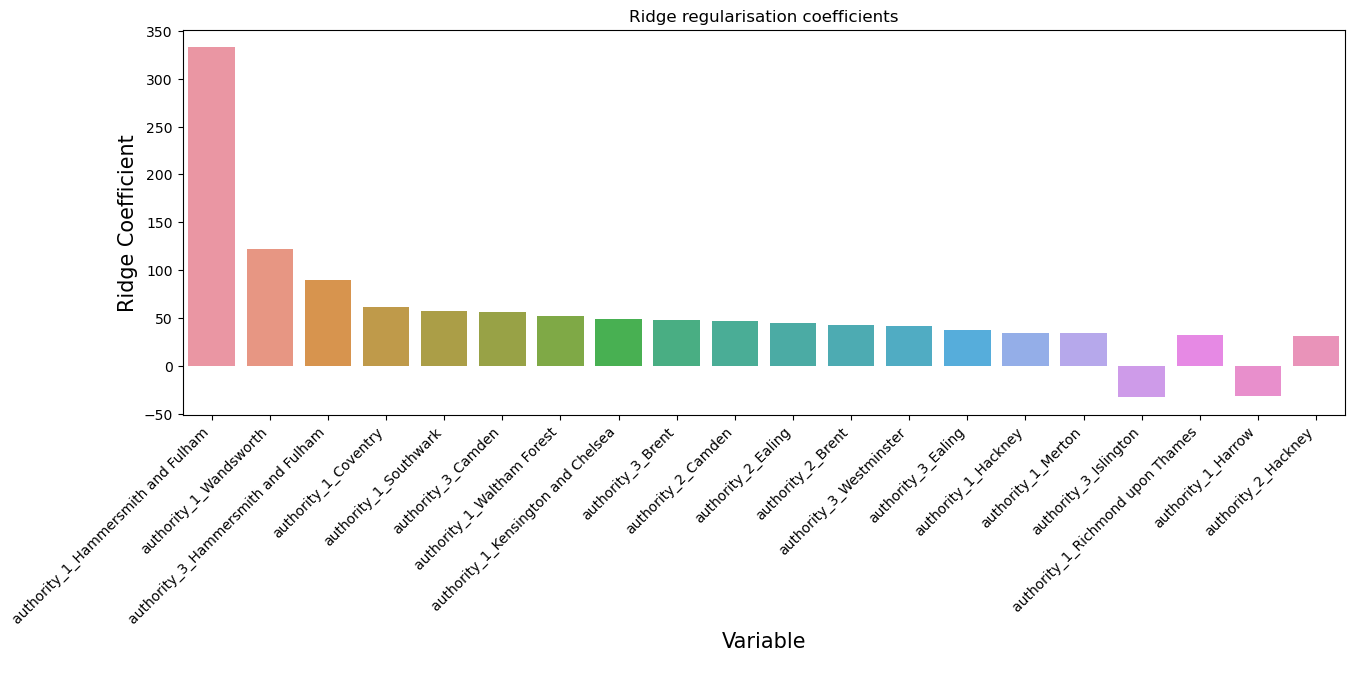

In [1199]:
# plot the 20 coefficents with the greatest magnitude from each method of regularization
fig, ax = plt.subplots(figsize = (15,5))

ridge_largest = coef_ridge.sort_values(by = 'abs', ascending = False)[:20]
sns.barplot(data = ridge_largest, x = 'variable', y = 'coefficient', ax = ax)
ax.set_xlabel("Variable\n", fontsize = 15)
ax.set_ylabel("Ridge Coefficient", fontsize = 15)
ax.set_xticklabels(labels = ridge_largest['variable'], rotation = 45, horizontalalignment='right')
ax.set_title('Ridge regularisation coefficients')
plt.show()

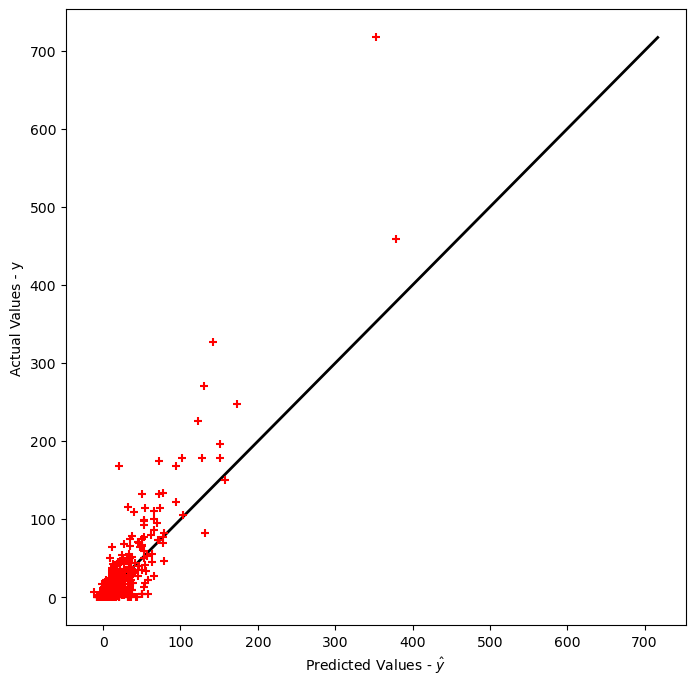

In [1231]:
# plot the values of y predicted by the elasticnet method (best predictions) against the true values of y
predictions_train = optimal_ridge.predict(X3_train)
predictions_test = optimal_ridge.predict(X3_test)

plt.figure(figsize=(8, 8))
plt.scatter(predictions_train, y3_train, s=30, c='r', marker='+', zorder=10)
plt.plot([y3_train.min(), y3_train.max()], [y3_train.min(), y3_train.max()], c='k', lw=2)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - y")
plt.show()

In [1188]:
# Create a decision tree regressor
regressor = DecisionTreeRegressor(max_depth=None, 
                                  random_state=1)

In [1189]:
# Define hyperparameters for a gridsearch
params = {'max_depth': [1,2,3,4,5,10,15,20],
    'max_features': [0.1,0.25,0.5,0.75,0.9,1]}

# instantiate the gridsearch cv model
dr_gridsearch = GridSearchCV(regressor, params, cv = 5)

In [1190]:
# fit the gridsearch
dr_gridsearch.fit(X3_train, y3_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 10, 15, 20],
                         'max_features': [0.1, 0.25, 0.5, 0.75, 0.9, 1]})

In [1192]:
# Extract the best model and use it to score the test set
dr_best = dr_gridsearch.best_estimator_

dr_best.score(X3_test,y3_test)

0.4055086494532818

### 4.2 Stats models

In [368]:
# adding the intercept manually
sm.add_constant(X2).head()

const  council_owned  parea_median   flow_in  flow_out   dist_in  dist_out  \
0    1.0            0.3   6639.444444  0.111684  0.123104  0.923685  0.918857   
1    1.0            0.0   4117.042707  0.448796  0.447950  0.967634  0.974245   
2    1.0            0.0   5173.416199  0.117376  0.130378  0.970759  0.973146   
3    1.0            0.0   6026.065546  0.811720  0.753822  0.890180  0.903878   
4    1.0            0.0   5789.473684  0.425744  0.426581  0.917932  0.927769   

   urban_code_A  urban_code_B  urban_code_C  ...  district_Truro  \
0             0             0             1  ...               0   
1             0             0             1  ...               0   
2             0             0             1  ...               0   
3             0             0             1  ...               0   
4             0             0             1  ...               0   

   district_Twickenham  district_Wakefield  district_Walsall  \
0                    0                   0                 0   
1                    0                   0                 0   
2                    0                   0                 0   
3                    0                   0                 0   
4                    0                   0                 0   

   district_Warrington  district_Watford  district_Wigan  \
0                    0                 0               0   
1                    0                 0               0   
2                    0                 0               0   
3                    0                 0               0   
4                    0                 0               0   

   district_Wolverhampton  district_Worcester  district_York  
0                       0                   0              0  
1                       0                   0              0  
2                       0                   0              0  
3                       0                   0              0  
4                       0                   0              0  

[5 rows x 109 columns]

In [788]:
model = sm.OLS(y2, sm.add_constant(X2))
results = model.fit()
predictions = results.predict(sm.add_constant(X2))
print("R2-score: ", results.rsquared)
print("RMSE:", np.sqrt(mean_squared_error(y2, predictions)))

R2-score:  0.2902874146180805
RMSE: 0.4203638205034242


In [373]:
# look at the summary of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        charging_points   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     12.63
Date:                Sun, 29 Jan 2023   Prob (F-statistic):          4.07e-153
Time:                        12:24:59   Log-Likelihood:                -9329.2
No. Observations:                2006   AIC:                         1.887e+04
Df Residuals:                    1899   BIC:                         1.947e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                             10.0565      5.095      1.974      0.049       0.063      20.050
council_owned                                                     33.0253      3.214     10.274      0.000      26.721      39.329
parea_median                                                      -0.0025      0.001     -4.876      0.000      -0.004      -0.002
flow_in                                                           -6.0703      5.983     -1.015      0.310     -17.804       5.664
flow_out                                                          15.1596      5.127      2.957      0.003       5.104      25.215
dist_in                                                           43.3262     30.626      1.415      0.157     -16.738     103.390
dist_out                                                         -38.8340     30.572     -1.270      0.204     -98.792      21.124
urban_code_A                                                       1.8258      2.773      0.658      0.510      -3.613       7.265
urban_code_B                                                       5.3546      4.654      1.150      0.250      -3.773      14.482
urban_code_C                                                       3.8242      1.683      2.272      0.023       0.523       7.126
urban_code_D                                                      -0.2710      1.802     -0.150      0.880      -3.805       3.263
urban_code_E                                                       0.1002      2.531      0.040      0.968      -4.863       5.063
urban_code_F                                                      -0.7773      2.921     -0.266      0.790      -6.506       4.951
district_Bath                                                     -2.8712      6.066     -0.473      0.636     -14.767       9.025
district_Birmingham                                              -10.3999      3.405     -3.055      0.002     -17.077      -3.723
district_Blackburn                                               -12.4321      7.387     -1.683      0.093     -26.920       2.056
district_Blackpool / Fylde                                       -11.3256      9.291     -1.219      0.223     -29.546       6.895
district_Bolton                                                   -5.8193      8.380     -0.694      0.487     -22.253      10.615
district_Bournemouth                                              -6.7596      5.240     -1.290      0.197     -17.037       3.517
district_Bradford                                                -17.2441      5.652     -3.051      0.002     -28.328      -6.160
district_Brighton                                                  5.1

### 4.3 Classification models

#### 4.2.1 Initial models

In [216]:
# Create a classification model 
df_class = df2.copy()

q1 = df2['charging_points'].describe()['25%']
q2 = df2['charging_points'].describe()['50%']
q3 = df2['charging_points'].describe()['75%']

In [217]:
# map the charging points to 0 or 1 depending on if the number is above or below the median
df_class['charging_points'] = df_class['charging_points'].map(lambda x: 0 if x < q2 else 1)
df_class['charging_points'].value_counts(normalize = True)

1    0.50163
0    0.49837
Name: charging_points, dtype: float64

In [218]:
# create the predictor and target variables
X_class = df_class[['district', 'urban_code','council_owned','parea_median','traffic_in','traffic_out','dist_in','dist_out', 'charging_points']].copy()
X_class.dropna(inplace = True)
y_class = X_class.pop('charging_points')

In [219]:
# dummify the additonal variables
X_class = pd.get_dummies(X_class, columns = ['urban_code','district'])
# Create a test train split
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_class, y_class, test_size=0.2, stratify = y_class, shuffle = True, random_state=1)

In [220]:
# scale the numerical values in our train and test sets using standard scaler
scaler = StandardScaler()
Xc_train = scaler.fit_transform(Xc_train)
Xc_test = scaler.transform(Xc_test)

In [876]:
# run a loop of Regressor models
models = [KNeighborsClassifier(),
          LogisticRegression(solver='lbfgs', multi_class='ovr'),
          DecisionTreeClassifier(),
          SVC(gamma='scale'),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

for model in models:
        print(model)
        print()
        model.fit(Xc_train, yc_train)
        cvs = cross_val_score(model, Xc_train, yc_train, cv=5)
        cvs_mean = np.mean(cvs)
        train_score = model.score(Xc_train, yc_train)
        test_score = model.score(Xc_test, yc_test)
        print('Cross val mean: ', cvs_mean)
        print('Score on train set: ', train_score)
        print('Score on test set: ', test_score)
        print()
        print('-'*60)
        print()

KNeighborsClassifier()

Cross val mean:  0.6502686915887851
Score on train set:  0.7711970074812967
Score on test set:  0.6616915422885572

------------------------------------------------------------

LogisticRegression(multi_class='ovr')

Cross val mean:  0.6913979750778816
Score on train set:  0.7437655860349127
Score on test set:  0.6741293532338308

------------------------------------------------------------

DecisionTreeClassifier()

Cross val mean:  0.6246884735202491
Score on train set:  1.0
Score on test set:  0.6691542288557214

------------------------------------------------------------

SVC()

Cross val mean:  0.6726927570093457
Score on train set:  0.7537406483790524
Score on test set:  0.681592039800995

------------------------------------------------------------

RandomForestClassifier()

Cross val mean:  0.6889038161993769
Score on train set:  1.0
Score on test set:  0.7089552238805971

------------------------------------------------------------

ExtraTreesClassifie

In [1200]:
#### With council parameters
# create the predictor and target variables
X_class2 = df_class[['authority_1','authority_2', 'authority_3','urban_code', 'charging_points']].copy()
X_class2.dropna(inplace = True)
y_class2 = X_class2.pop('charging_points')

In [1201]:
# dummify the additonal variables
X_class2 = pd.get_dummies(X_class2, drop_first = True)
# Create a test train split
Xc2_train, Xc2_test, yc2_train, yc2_test = train_test_split(
    X_class2, y_class2, test_size=0.2, stratify = y_class2, shuffle = True, random_state=1)

In [1202]:
# run a loop of Regressor models
models = [KNeighborsClassifier(),
          LogisticRegression(solver='lbfgs', multi_class='ovr'),
          DecisionTreeClassifier(),
          SVC(gamma='scale'),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

for model in models:
        print(model)
        print()
        model.fit(Xc2_train, yc2_train)
        cvs = cross_val_score(model, Xc2_train, yc2_train, cv=5)
        cvs_mean = np.mean(cvs)
        train_score = model.score(Xc2_train, yc2_train)
        test_score = model.score(Xc2_test, yc2_test)
        print('Cross val mean: ', cvs_mean)
        print('Score on train set: ', train_score)
        print('Score on test set: ', test_score)
        print()
        print('-'*60)
        print()

KNeighborsClassifier()

Cross val mean:  0.6205704211830828
Score on train set:  0.7547281323877069
Score on test set:  0.6226415094339622

------------------------------------------------------------

LogisticRegression(multi_class='ovr')

Cross val mean:  0.6648601001902568
Score on train set:  0.8144208037825059
Score on test set:  0.7004716981132075

------------------------------------------------------------

DecisionTreeClassifier()

Cross val mean:  0.6477492101726275
Score on train set:  0.8947990543735225
Score on test set:  0.6533018867924528

------------------------------------------------------------

SVC()

Cross val mean:  0.6501090921785273
Score on train set:  0.8321513002364066
Score on test set:  0.7004716981132075

------------------------------------------------------------

RandomForestClassifier()

Cross val mean:  0.6388926707510778
Score on train set:  0.8947990543735225
Score on test set:  0.6745283018867925

--------------------------------------------------

#### 4.2.2 Logistic regression

In [1059]:
# define the hyperparameters for a gridsearch
gs_params = {'penalty': ['l1', 'l2'],
             'solver': ['liblinear'],
             'C': np.logspace(-3, 0, 50)}

In [1060]:
# instantiate the model
logreg = LogisticRegression(max_iter = 1000)
lr_gridsearch = GridSearchCV(logreg, gs_params, cv=5)

In [879]:
# fit and evaluate model on the training set
lr_gridsearch.fit(Xc_train, yc_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([0.001     , 0.0011514 , 0.00132571, 0.00152642, 0.00175751,
       0.00202359, 0.00232995, 0.0026827 , 0.00308884, 0.00355648,
       0.00409492, 0.00471487, 0.00542868, 0.00625055, 0.00719686,
       0.00828643, 0.00954095, 0.01098541, 0.01264855, 0.01456348,
       0.01676833, 0.01930698, 0.02222996, 0.02559548, 0.02947052,
       0.03393222, 0.0390694 , 0.04498433, 0.05179475, 0.05963623,
       0.06866488, 0.07906043, 0.09102982, 0.10481131, 0.12067926,
       0.13894955, 0.15998587, 0.184207  , 0.21209509, 0.24420531,
       0.28117687, 0.32374575, 0.37275937, 0.42919343, 0.49417134,
       0.5689866 , 0.65512856, 0.75431201, 0.86851137, 1.        ]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [880]:
# Print the mean cross-validated score of the best_estimator
lr_gridsearch.best_score_

0.6994879283489096

In [881]:
# print the best parameters
lr_gridsearch.best_params_

{'C': 0.13894954943731375, 'penalty': 'l1', 'solver': 'liblinear'}

In [882]:
# save the best estimator
best_lr = lr_gridsearch.best_estimator_

# score the best estimator on the test data
best_lr.score(Xc_test, yc_test)

0.6940298507462687

In [883]:
# show a table of the logistic regression coefficients
lr_coefs = pd.DataFrame(best_lr.coef_, columns = X_class.columns).T
lr_coefs.columns = ['lr_coef']
lr_coefs['odds_ratio'] = np.exp(lr_coefs['lr_coef'])
lr_coefs.sort_values(by = 'odds_ratio')

lr_coef  odds_ratio
urban_code_D                 -0.416210    0.659542
urban_code_F                 -0.314422    0.730211
urban_code_E                 -0.260201    0.770897
district_Hull                -0.248983    0.779593
district_Liverpool           -0.225628    0.798015
...                                ...         ...
urban_code_C                  0.155573    1.168327
district_Newcastle upon Tyne  0.160559    1.174167
district_Oxford               0.195032    1.215350
district_London SE            0.229373    1.257811
council_owned                 0.759187    2.136538

[108 rows x 2 columns]

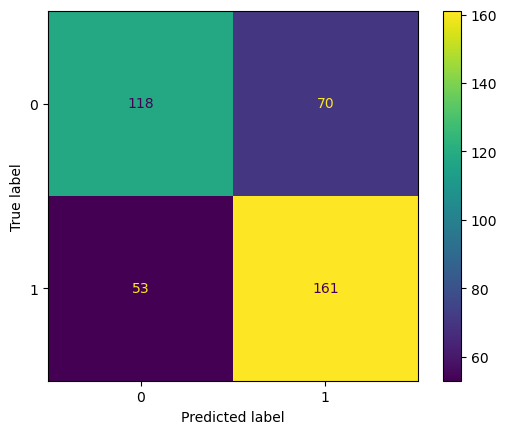

In [884]:
# plot the confusion matrix
plot_confusion_matrix(best_lr, Xc_test, yc_test);

In [885]:
# print the classification report
print(classification_report(yc_test, best_lr.predict(Xc_test)))

              precision    recall  f1-score   support

           0       0.69      0.63      0.66       188
           1       0.70      0.75      0.72       214

    accuracy                           0.69       402
   macro avg       0.69      0.69      0.69       402
weighted avg       0.69      0.69      0.69       402



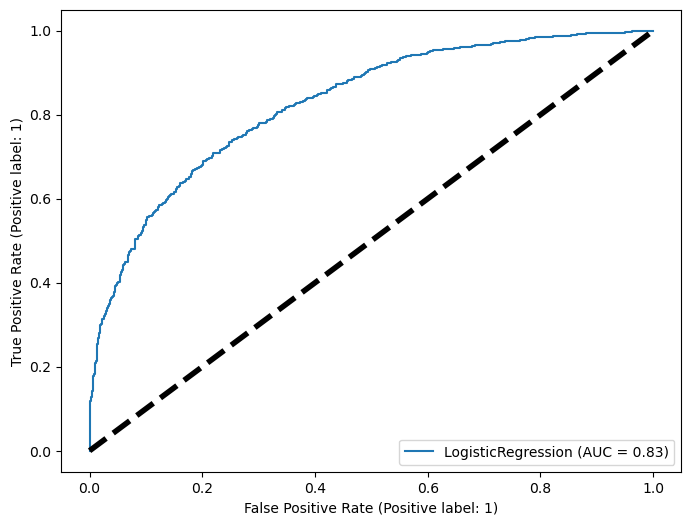

In [886]:
# ROC curve for train set
fig, ax = plt.subplots(figsize=(8, 6))

plot_roc_curve(best_lr, Xc_train, yc_train, ax=ax)
ax.plot([0, 1], [0, 1], 'k--', linewidth=4)

plt.show()

In [718]:
# look at auc score for train
roc_auc_score(yc_train, best_lr.predict_proba(Xc_train)[:, 1])

0.826786636965484

**Interpretation of the coefficients**

Looking at the odds ratio we can see that certain districts such as London districts, Oxford, Newcastle etc. are increasing the odds of having a high number of charging points (as seen by an odds ratio of greater than 1). Conversely having an outcode located in districts such as Birmingham, Liverpool and Hull are decreasing the odds of having a high number of charging points (seen by an odds ratio of less than 1). Outcodes with high proportions of council owned charging points are likely to have to have high numbers of charging points, showing the impact of local government on the installation of these charging stations. Rural areas are decreasing the likelihood of having a high number of charging points with rural codes D, E and F all having around 0.9 times the odds of high number of charging points.

From the confusion matrix and the higher recall score from the classification report, we can see that the model is favouring the prediction of high number of charging points over low number of charging points. This means that the false positives is higher for this grouper and the false negative lower (and vice versa for the low group).  

#### with council params

In [1205]:
yc2_train.shape

(1692,)

In [1207]:
lr_gridsearch.fit(Xc2_train, yc2_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': array([0.001     , 0.0011514 , 0.00132571, 0.00152642, 0.00175751,
       0.00202359, 0.00232995, 0.0026827 , 0.00308884, 0.00355648,
       0.00409492, 0.00471487, 0.00542868, 0.00625055, 0.00719686,
       0.00828643, 0.00954095, 0.01098541, 0.01264855, 0.01456348,
       0.01676833, 0.01930698, 0.02222996, 0.02559548, 0.02947052,
       0.03393222, 0.0390694 , 0.04498433, 0.05179475, 0.05963623,
       0.06866488, 0.07906043, 0.09102982, 0.10481131, 0.12067926,
       0.13894955, 0.15998587, 0.184207  , 0.21209509, 0.24420531,
       0.28117687, 0.32374575, 0.37275937, 0.42919343, 0.49417134,
       0.5689866 , 0.65512856, 0.75431201, 0.86851137, 1.        ]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [1208]:
lr_gridsearch.best_score_

0.6678169345970573

In [1210]:
# save the best estimator
lr = lr_gridsearch.best_estimator_

# score the best estimator on the test data
lr.score(Xc2_test, yc2_test)

0.7004716981132075

In [1218]:
# show a table of the logistic regression coefficients
lr_coefs = pd.DataFrame(lr.coef_, columns = X_class2.columns).T
lr_coefs.columns = ['lr_coef']
lr_coefs['odds_ratio'] = np.exp(lr_coefs['lr_coef'])
lr_coefs.sort_values(by = 'lr_coef', ascending = False)[:20]

lr_coef  odds_ratio
authority_1_North Norfolk       1.143683    3.138305
authority_1_Lambeth             1.090243    2.974997
authority_1_Cherwell            1.079271    2.942535
authority_1_Enfield             1.063411    2.896233
authority_1_Folkestone and ...  1.037996    2.823552
authority_1_Milton Keynes       1.000878    2.720669
authority_1_Sunderland          0.982016    2.669834
authority_1_Richmond upon T...  0.969051    2.635443
authority_1_New Forest          0.957524    2.605238
authority_1_Portsmouth          0.955220    2.599243
authority_1_North Tyneside      0.940462    2.561166
authority_2_Rugby               0.920454    2.510429
authority_1_West Oxfordshire    0.915515    2.498061
authority_1_Carlisle            0.897259    2.452870
authority_1_North Northampt...  0.868494    2.383319
authority_1_West Northampto...  0.865912    2.377172
authority_1_Kensington and ...  0.842640    2.322490
authority_1_Salford             0.840041    2.316462
authority_1_Newham              0.838381    2.312619
authority_2_Camden              0.826049    2.284277

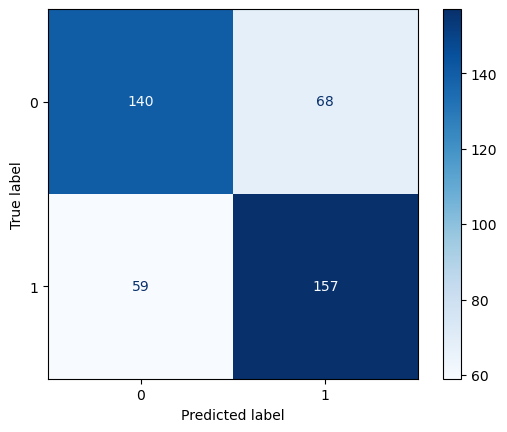

In [1213]:
# plot the confusion matrix
plot_confusion_matrix(lr, Xc2_test, yc2_test, cmap = 'Blues');

#### 4.2.3 Decision tree classifier

In [1221]:
# Create a decision tree classifier
classifier = DecisionTreeClassifier(criterion='gini',
                                  max_depth=None, 
                                  random_state=1)

In [1222]:
# Define hyperparameters for a gridsearch
params = {'max_depth': [1,2,3,4,5,10,15,20],
    'max_features': [0.1,0.25,0.5,0.75,0.9,1]}

# instantiate the gridsearch cv model
dt_gridsearch = GridSearchCV(classifier, params, cv = 5)

In [889]:
# fit the gridsearch
dt_gridsearch.fit(Xc_train, yc_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 10, 15, 20],
                         'max_features': [0.1, 0.25, 0.5, 0.75, 0.9, 1]})

In [890]:
# Find the best parameters from the gridsearch
dt_gridsearch.best_params_

{'max_depth': 10, 'max_features': 0.9}

In [891]:
# Find thes best score from the gridsearch
dt_gridsearch.best_score_

0.6820307632398753

In [892]:
# Extract the best model and use it to score the test set
dt_best = dt_gridsearch.best_estimator_

dt_best.score(Xc_test,yc_test)

0.6467661691542289

In [859]:
# Extract the feature importances
pd.DataFrame(list(zip(X_class.columns, dt_best.feature_importances_)), 
             columns=['Feature', 'Importance']
            ).sort_values(by='Importance', ascending=False)

Feature  Importance
0                    council_owned    0.299565
9                     urban_code_D    0.115823
1                     parea_median    0.093155
5                         dist_out    0.081396
4                          dist_in    0.076681
..                             ...         ...
52                  district_Leeds    0.000000
51              district_Lancaster    0.000000
50   district_Kingston upon Thames    0.000000
49                district_Ipswich    0.000000
107                  district_York    0.000000

[108 rows x 2 columns]

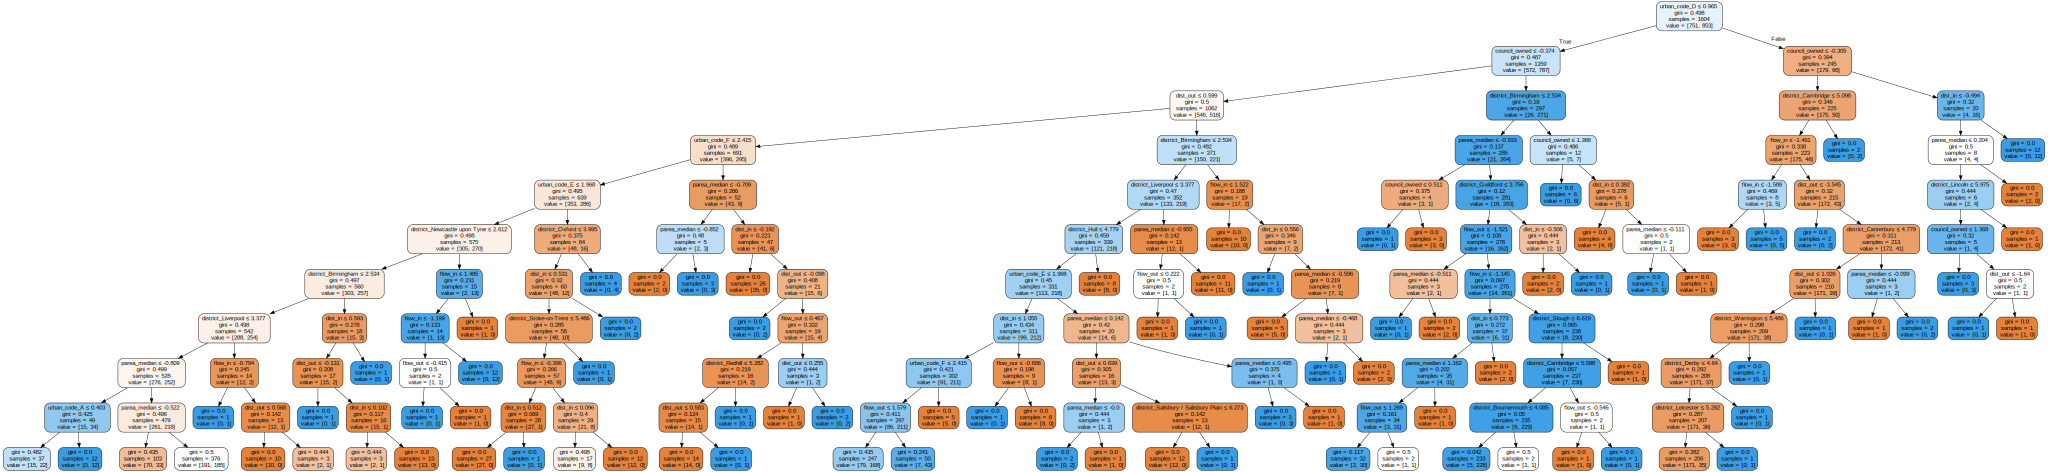

In [787]:
# Show the decision tree
dot_data = export_graphviz(dt_best,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=X_class.columns
                )

graph = graphviz.Source(dot_data) 

graph

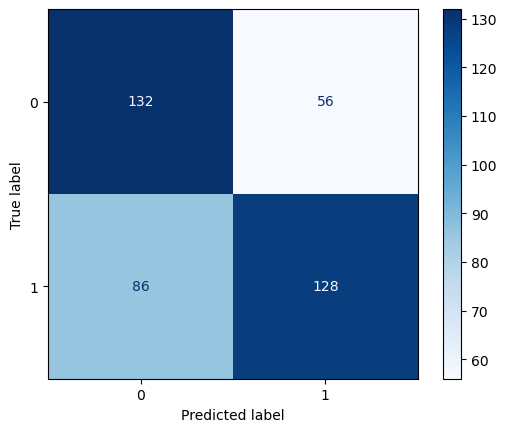

In [893]:
# plot confusion matrix
plot_confusion_matrix(dt_best, Xc_test, yc_test, cmap = 'Blues');

In [894]:
# print the classification report
print(classification_report(yc_test, dt_best.predict(Xc_test)))

              precision    recall  f1-score   support

           0       0.61      0.70      0.65       188
           1       0.70      0.60      0.64       214

    accuracy                           0.65       402
   macro avg       0.65      0.65      0.65       402
weighted avg       0.65      0.65      0.65       402




**Interpretation of feature importances**
Compared to linear regression, the decision tree model is giving a lower accuracy score. However, it also appears to be better at predicting areas with low numbers of charging points than the logistic regression model. Similar features are proving to be impactful for splitting the nodes and maximising gain such as the proportion of council owned charging points and whether it is a rural area (code D, E, F). Here the distance to roads has also been used as a feature to split the decision tree.

#### with council params

In [1223]:
# fit the gridsearch
dt_gridsearch.fit(Xc2_train, yc2_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 10, 15, 20],
                         'max_features': [0.1, 0.25, 0.5, 0.75, 0.9, 1]})

In [1224]:
# Find thes best score from the gridsearch
dt_gridsearch.best_score_

0.6471574941962961

In [1225]:
# Extract the best model and use it to score the test set
dt_best = dt_gridsearch.best_estimator_

dt_best.score(Xc2_test,yc2_test)

0.6533018867924528

#### 4.2.4 Random forest

In [1227]:
# Create a decision tree classifier
rf = RandomForestClassifier(
                           n_estimators=100,
                           random_state=1)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 5, num = 5)]
# Number of features to consider at every split
max_features = [0.1,0.5,0.75,0.9,1]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

In [1228]:
# instantiate the gridsearch cv model
rf_gridsearch = GridSearchCV(rf, random_grid, cv = 5)

In [957]:
# fit the gridsearch
rf_gridsearch.fit(Xc_train, yc_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50],
                         'max_features': [0.1, 0.5, 0.75, 0.9, 1],
                         'n_estimators': [10, 8, 7, 6, 5]})

In [958]:
# Find the best parameters from the gridsearch
rf_gridsearch.best_params_

{'bootstrap': True, 'max_depth': 20, 'max_features': 0.1, 'n_estimators': 8}

In [959]:
# Find thes best score from the gridsearch
rf_gridsearch.best_score_

0.7069820872274143

In [960]:
# Extract the best model and use it to score the test set
rf_best = dt_gridsearch.best_estimator_

rf_best.score(Xc_test,yc_test)

0.6467661691542289

#### with council params

In [1229]:
# fit the gridsearch
rf_gridsearch.fit(Xc2_train, yc2_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50],
                         'max_features': [0.1, 0.5, 0.75, 0.9, 1],
                         'n_estimators': [10, 8, 7, 6, 5]})

In [1230]:
# Find thes best score from the gridsearch
rf_gridsearch.best_score_

0.6566284407673108

#### 4.2.5 Neural Networks

In [223]:
# Recreating logistic regression - gives same test score (0.674)
clf = MLPClassifier(solver='lbfgs',
                    alpha=10**(-10),
                    hidden_layer_sizes=1,
                    activation='identity',
                    random_state=1,
                    batch_size='auto')
clf.fit(Xc_train, yc_train)
print(accuracy_score(yc_test, clf.predict(Xc_test)))

0.6716417910447762


In [235]:
clf = MLPClassifier(solver='sgd',
                    alpha=10**(0),
                    hidden_layer_sizes=(4,4,4,4),
                    activation='relu',
                    random_state=42,
                    batch_size=50,
                    max_iter=1000)
clf.fit(Xc_train, yc_train)
print(accuracy_score(yc_train, clf.predict(Xc_train)))
print(accuracy_score(yc_test, clf.predict(Xc_test)))

0.7780548628428927
0.6915422885572139


In [231]:
clf = MLPClassifier(solver='sgd',
                    alpha=10**(0),
                    hidden_layer_sizes=(8,8,8),
                    activation='relu',
                    random_state=42,
                    batch_size=50,
                    max_iter=1000)
clf.fit(Xc_train, yc_train)
print(accuracy_score(yc_train, clf.predict(Xc_train)))
print(accuracy_score(yc_test, clf.predict(Xc_test)))

0.7780548628428927
0.6940298507462687


In [243]:
clf = MLPClassifier(solver='adam',
                    alpha=10**(0),
                    hidden_layer_sizes=(8,8,8),
                    activation='relu',
                    random_state=42,
                    batch_size=50,
                    max_iter=1000)
clf.fit(Xc_train, yc_train)
print(accuracy_score(yc_train, clf.predict(Xc_train)))
print(accuracy_score(yc_test, clf.predict(Xc_test)))

0.7973815461346634
0.6791044776119403


In [239]:
clf = MLPClassifier(solver='lbfgs',
                    alpha=10**(0),
                    hidden_layer_sizes=(8,8,8),
                    activation='relu',
                    random_state=42,
                    batch_size=50,
                    max_iter=1000)
clf.fit(Xc_train, yc_train)
print(accuracy_score(yc_train, clf.predict(Xc_train)))
print(accuracy_score(yc_test, clf.predict(Xc_test)))

0.9177057356608479
0.6393034825870647


In [240]:
Xc_train.shape

(1604, 112)

In [241]:
113/2

56.5

# Conclusion

The initial hypothesis that locations of electric car charging points could be predicted based on the relative surrounding traffic, can be rejected. From the initial EDA as well as the modelling scores, it could be seen that this was not the case. Further work could be done to look at how this measure of traffic flow around a location was calculated. During the initial attempt it was seen that the traffic value was having a much higher impact than the distance to a main road, meaning locations very close to reasonably busy (but not the busiest) roads were receiving quite a low metric of traffic flow. This was recalculated by grouping the traffic flow according to its relative position in the dataset. However, this did not significantly improve the correlation seen to the number of charging points. It is also worth noting that the traffic data collected only considers major roads (motorways and A roads), meaning it is rather evaluating traffic for long distance journeys as opposed to local traffic (e.g. around a city). There was additionally the blocker that only only the traffic at the closest road could be mapped. This may not give an accurate representation of the surrounding traffic, if there are multiple roads around that location. 

Investigation of other metrics as well as checking literature, suggests that initial charging points were not created in relation to high points of traffic along motorways and A roads. This could be seen by the very low proportion of charging points at service stations (where you would expect them in proximity to main roads). Furthermore literature states that to meet demand the number of charging points along motorways will need to increase by 4 fold. 

Further EDA suggested that there is currently a monopoly of charging points in London, with almost 50% of England EV charging points located there. This could be considered to be in relation to several factors, including wealth of local areas, the existence of the ultralow emission zone, or the relative number of people living in London. On a more granular level, the outcodes within London that have the highest number of charging points, can seemingly be grouped by local authority. For example several of the outcodes with the highest number of charging points are in Hammersmith and Fulham, and Westminster. Further investigation shows that this local boroughs have had strong initiatives into the developement of EV charging stations. Unfortunately the initial data was aggregated by outcodes, which can be covered by more than one local authority. For further work, it may be a worth considering a different method of local aggregation.

Running initial linear regression models with additional variables, showed that only around 30% of the variance in our target variable could be explained with our predictor variables. Due to the high skew in the target variable, this was then made into a classification problem - predicting if an area had a high or low number of charging points (above or below the median number respectively).

The best classification model was the logistic regression model which gave an accuracy score of 0.694 on the test set. The model indicated that the local district, the urban coding of an area and the proportion of council owned charging points were the best predictors. 

Other than limitations in the collection of the traffic data, there were some additional limitations to the methodology used in this project. The dataset does not have any insight into the location of private/home EV charging points. It could be the case that manufacturers or councils do not want to invest in EV charging points if people are likely to charge their cars at home anyway. Further limitations were centred around the difficulty in collecting data aggregated by postcode/outcode. The last census data on this was taken in 2011, and some of the data used was created from that, making the assumption that local authorities and the urban/rural category will not have significantly changed. Additional work could be aimed at improving the matching of addresses used to find the average price per sqm of houses when joining price paid and energy rating data.

In terms of further work, it could be interesting to investigate further the impact of local authorities, for example investigating debt of local councils and whether there is a sparsity of EV charging points in these areas. Ideally further work would also include looking at population densities - if a suitable dataset and method of aggregation could be found. It would be additionally interesting to look at the change in local populations over summer months were traditionally rural areas such as Cornwall, gain an influx of tourists. Seeing as there is a considerable sparsity in rural areas, this may highlight the demand for more EV stations in these areas. 